# Landfill PFAS Mass Balance

### Libraries Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import scipy.stats
import statsmodels.api as sm
from statsmodels.graphics.agreement import mean_diff_plot
from scipy.stats import ks_2samp
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter

### Default Font Settings

In [2]:
# Set default tick label size
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

# Set default font size for title, labels, and legend
plt.rcParams['axes.titlesize'] = 30  # Set the font size for plot titles
plt.rcParams['axes.labelsize'] = 24  # Set the font size for axis labels
plt.rcParams['legend.fontsize'] = 20  # Set the font size for legend
plt.rcParams['legend.title_fontsize'] = 22  # Set the font size for legend

# Set default font family to Arial
plt.rcParams['font.family'] = 'Arial'

# Set default font type for plot titles to bold
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'normal' # for bland-altman plots  
plt.rcParams['axes.labelweight'] = 'bold'  #for stack bars

### 2) Data Import (REQUIRED)

In [3]:
def read_excel_sheet(excel_file, sheet_name):
    """
    Read a specific sheet from an Excel file into a DataFrame.

    Args:
        excel_file (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to read.

    Returns:
        pd.DataFrame or None: A DataFrame containing the sheet data or None if the sheet is not found.
    """
    try:
        # Load the specified sheet from the Excel file into a DataFrame
        df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=1)
        return df
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [4]:
# Example usage:

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Database as of 09-17-2024.xlsm'
#Specify sheet name
sheet_name = 'PFAS Database'

#Call data import function
data_df = read_excel_sheet(excel_file_path, sheet_name)

data_df.head()

Sampling point Date Component  Sample Number  \
0  ANODIZE SOLUTIONS (FPT)-43692.3333333333-10:2F...       259452.0   
1  ANODIZE SOLUTIONS (FPT)-43692.3333333333-11Cl-...       259452.0   
2  ANODIZE SOLUTIONS (FPT)-43692.3333333333-4:2Fl...       259452.0   
3  ANODIZE SOLUTIONS (FPT)-43692.3333333333-6:2Fl...       259452.0   
4  ANODIZE SOLUTIONS (FPT)-43692.3333333333-8:2Fl...       259452.0   

            Sampling Point Sample Name         Sampled Date Analysis  \
0  ANODIZE SOLUTIONS (FPT)         NaN  2019-08-15 08:00:00  PFAS-CL   
1  ANODIZE SOLUTIONS (FPT)         NaN  2019-08-15 08:00:00  PFAS-CL   
2  ANODIZE SOLUTIONS (FPT)         NaN  2019-08-15 08:00:00  PFAS-CL   
3  ANODIZE SOLUTIONS (FPT)         NaN  2019-08-15 08:00:00  PFAS-CL   
4  ANODIZE SOLUTIONS (FPT)         NaN  2019-08-15 08:00:00  PFAS-CL   

                                 Component Qualifiers Result     Units  ...  \
0  10:2Fluorotelomersulfonic Acid (Report)        NaN  <9.40  ppt_wt_v  ...   
1                    11Cl-PF3OUdS (Report)        NaN  <4.70  ppt_wt_v  ...   
2   4:2Fluorotelomersulfonic Acid (Report)        NaN  <4.70  ppt_wt_v  ...   
3   6:2Fluorotelomersulfonic Acid (Report)        NaN  <19.0  ppt_wt_v  ...   
4   8:2Fluorotelomersulfonic Acid (Report)        NaN  <9.40  ppt_wt_v  ...   

  ChainLength         Pseudonym Dominant Contributor           Sector Depth  \
0        12.0  Metal Finisher B                  NaN  Metal Finishing   NaN   
1        10.0  Metal Finisher B                  NaN  Metal Finishing   NaN   
2         6.0  Metal Finisher B                  NaN  Metal Finishing   NaN   
3         8.0  Metal Finisher B                  NaN  Metal Finishing   NaN   
4        10.0  Metal Finisher B                  NaN  Metal Finishing   NaN   

  Edit Notes Field Notes Region Crop  
0        NaN   NaN   NaN    NaN  NaN  
1        NaN   NaN   NaN    NaN  NaN  
2        NaN   NaN   NaN    NaN  NaN  
3        NaN   NaN   NaN    NaN  NaN  
4        NaN   NaN   NaN    NaN  NaN  

[5 rows x 56 columns]

### 3) Import PFAS Compounds Attributes (REQUIRED)

In [4]:
# Import PFAS Attributes

#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Old Databases and Spreadsheets/Database as of 03-25-2024.xlsm'
#Specify sheet name
sheet_name = 'PFAS Attributes'

df_PFAS_Attributes = pd.read_excel(excel_file_path, sheet_name=sheet_name)

In [5]:
# Create a dictionary mapping PFAS Compounds to their corresponding Abbreviation (No need to change)
pfas_mapping = dict(zip(df_PFAS_Attributes['Database'], df_PFAS_Attributes['Abbrev']))

In [6]:
# Load the Excel file into a DataFrame
df = pd.read_excel("U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/PFAS Toolbox_ColorsPalette.xlsx",sheet_name='ColorPalette_NonTOP')

def parse_rgb(rgb_string):
    # Check if rgb_string is a string and not empty
    if isinstance(rgb_string, str) and rgb_string:
        # Remove parentheses and split the string by commas
        rgb_values = rgb_string.strip('()').split(',')
        # Convert each value to float and return as a tuple
        return tuple(int(value)/255 for value in rgb_values)
    else:
        # Handle the case where rgb_string is not a string or is empty
        return None  # or return (0, 0, 0, 0) for a default transparent color, for example



# Create a dictionary with PFAS compounds as keys and corresponding colors as values
compound_colors_dict = {compound: parse_rgb(rgb) for compound, rgb in zip(df['Database'], df['New_RGB'])}
compound_colors_dict_abbrev = {abbrev: parse_rgb(rgb) for abbrev, rgb in zip(df['Abbrev'], df['New_RGB'])}

### Rock Creek Conc BQL

In [26]:
#Specify where the file is saved use '/' instead of '\'
#excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-25-24.xlsx'
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Conc = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc', usecols='C:T', skiprows=26, nrows=14)

df_RC_Conc=df_RC_Conc.set_index('Date')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Conc.columns]
# Reorder columns by indexing df with the desired order
df_RC_Conc = df_RC_Conc[filtered_order]

new_index = df_RC_Conc.index.tolist()  # Convert index to a list for easy manipulation
new_index[9] = '2023-3 (2)'  # Change the index

# Assign the new index back to the DataFrame
df_RC_Conc.index = new_index

df_RC_Conc

PFBA  PFPeA  PFHxA  PFHpA  PFOA  PFNA  PFDA  PFDoA  NEtFOSAA  \
2019-8      52.0   26.0   24.0   10.0   8.5   3.6  3.10   13.0       NaN   
2020-4      63.0   25.0   34.0    9.4  14.0   NaN   NaN    NaN       NaN   
2020-9       NaN    NaN   12.0    NaN   NaN   NaN   NaN    NaN       NaN   
2020-12     31.0   23.0   41.0    8.7  15.0   2.4  3.00    NaN     0.690   
2021-7      28.0   26.0   43.0    6.7  17.0   NaN   NaN    NaN       NaN   
2022-4      17.0   17.0   18.0    4.8  11.0   1.4  1.20    NaN       NaN   
2022-8      36.0   32.0   42.0    9.3  15.0   NaN   NaN    NaN       NaN   
2023-1      26.0   17.0   29.0    6.5  12.0   NaN   NaN    NaN       NaN   
2023-3       NaN    5.9    6.6    NaN   NaN   NaN   NaN    NaN       NaN   
2023-3 (2)   NaN    6.2    6.5    3.0   NaN   NaN   NaN    NaN       NaN   
2023-4       NaN    6.5    NaN    NaN   5.2   NaN   NaN    NaN       NaN   
2023-9      11.0    8.2    NaN    3.1   3.7   NaN   NaN    NaN       NaN   
2023-12     16.5   12.3   19.5    4.7  11.5   1.6  2.30    NaN     0.335   
2024-3       8.9    8.2    6.9    3.2   5.8   1.2  0.88    NaN       NaN   

            NMeFOSAA  PFBS  PFPeS  PFHxS   PFOS  HFPO-DA  6:2FTS  
2019-8           1.1  30.0    NaN    2.2   6.10      NaN     3.5  
2020-4           NaN  39.0    NaN    NaN  14.00      NaN     NaN  
2020-9           NaN   5.4    NaN    NaN   7.80      NaN     NaN  
2020-12          1.2  32.0   0.97    3.9    NaN     0.53     2.7  
2021-7           NaN  37.0    NaN   10.0  11.00      NaN     NaN  
2022-4           1.0  13.0   1.70    3.5  12.00      NaN     NaN  
2022-8           NaN  29.0    NaN    7.9  15.00      NaN     NaN  
2023-1           NaN  23.0    NaN    3.6   6.40      NaN     NaN  
2023-3           NaN   4.5    NaN    3.5   7.40      NaN     NaN  
2023-3 (2)       NaN   4.8    NaN    2.9   7.70      NaN     NaN  
2023-4           NaN   6.9    NaN    NaN    NaN      NaN     NaN  
2023-9           NaN   9.1    NaN    3.5    NaN      NaN     NaN  
2023-12          1.4  14.0   5.23    2.9  10.05      NaN     0.7  
2024-3           NaN   5.0    NaN    2.8  11.00      NaN     NaN

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        #print("Filtered columns:", avg_pivot_table_filtered.columns)
        
        if std_dev_pivot_table is not None and not std_dev_pivot_table.empty:
            std_dev_pivot_table_filtered = std_dev_pivot_table.fillna(0)[avg_pivot_table_filtered.columns]
        else:
            std_dev_pivot_table_filtered = pd.DataFrame(columns=avg_pivot_table_filtered.columns, index=avg_pivot_table_filtered.index)
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values))
            
            #print(f"Plotting {compound}: Values = {avg_values}, Bottom = {bottom}")
            
            bars = ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                          label=compound, yerr=std_dev_values, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)

        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


        ax.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2, ncol=1)
        legend.get_title().set_fontweight('bold')  # Set the legend title to bold

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage assuming 'avg_pivot_table' and 'std_dev_pivot_table' are defined along with 'compound_colors_dict'
# create_stacked_bar_chart_filtered(avg_pivot_table)


c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

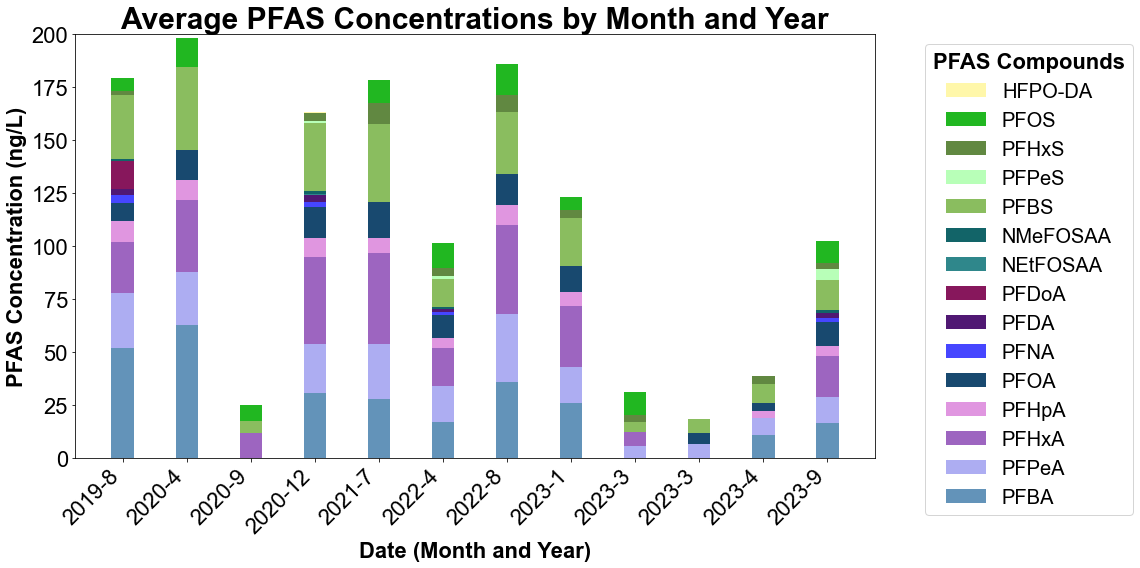

In [11]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC, std_dev_pivot_table=None, figsize=(16, 8), title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=200)

In [25]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Other = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc', usecols='C:V', skiprows=26, nrows=14)

df_RC_Other=df_RC_Other.set_index('Date')

new_index = df_RC_Other.index.tolist()  # Convert index to a list for easy manipulation
new_index[9] = '2023-3 (2)'  # Change the index

# Assign the new index back to the DataFrame
df_RC_Other.index = new_index

df_RC_Other=df_RC_Other[['Total PFAS','Fraction of Rock Creek Flow from Landfill']]

df_RC_Other

Total PFAS  Fraction of Rock Creek Flow from Landfill
2019-8         183.100                                   0.002921
2020-4         198.400                                   0.002598
2020-9          25.200                                   0.001369
2020-12        166.090                                   0.002628
2021-7         178.700                                   0.002656
2022-4         101.600                                   0.003054
2022-8         186.200                                   0.004285
2023-1         123.500                                   0.003997
2023-3          27.900                                   0.000533
2023-3 (2)      31.100                                   0.000533
2023-4          18.600                                   0.002119
2023-9          38.600                                   0.002222
2023-12        103.015                                   0.002293
2024-3          53.880                                   0.002654

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, add_data_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax1 = plt.subplots(figsize=figsize)

        # Stacked Bar Plot
        bottom = np.zeros(len(avg_pivot_table_filtered.index))
        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values)) if std_dev_pivot_table is not None else np.zeros_like(avg_values)
            ax1.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color, label=compound, yerr=std_dev_values, capsize=0)
            bottom += avg_values

        # Line Chart for Landfill Flow
        ax2 = ax1.twinx()
        if add_data_table is not None:
            ax2.plot(add_data_table.index, add_data_table['Fraction of Rock Creek Flow from Landfill'], color='black', label='Fraction of Rock Creek Flow', linewidth=2.0,marker='s', markersize=10)
            ax2.set_ylabel('Fraction of Rock Creek Flow (%)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        # Line Chart for Landfill Flow
        ax2 = ax1.twinx()
        if add_data_table is not None:
            # Iterate over data points to apply custom colors for specified indices
            for i, (x, y) in enumerate(zip(add_data_table.index, add_data_table['Fraction of Rock Creek Flow from Landfill'])):
                if i in [8, 9]:  # Assuming 9th and 10th points are at index 8 and 9 (0-based index)
                    color = 'red'
                elif i in [10, 11]:  # Assuming 11th and 12th points are at index 10 and 11
                    color = 'orange'
                else:
                    color = 'black'
                ax2.plot(x, y, marker='s', markersize=10, color=color, label='Fraction of Rock Creek Flow' if i == 0 else "_nolegend_")

            ax2.set_ylabel('Fraction of Rock Creek Flow (%)', fontsize=axis_label_fontsize, fontproperties=font_bold)

        # Scatter Plot with Trendline for Total PFAS
        """
        if 'Total PFAS' in add_data_table.columns:
            scatter_x = add_data_table.index
            scatter_y = add_data_table['Total PFAS']
            ax1.scatter(scatter_x, scatter_y, color='black', label='Total PFAS', zorder=5)

            # Calculate trendline
            slope, intercept, r_value, p_value, std_err = linregress(range(len(scatter_x)), scatter_y)
            line = slope * np.arange(len(scatter_x)) + intercept
            ax1.plot(scatter_x, line, 'r--', label=f'Trendline: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}\np-value = {p_value:.2f}')
            """

        ax1.set_ylim(0, ylim)
        ax1.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_title(title, fontsize=title_fontsize, fontproperties=font_bold, pad=20)
        ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)
        
        # Combine legend handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        all_handles = handles1 + handles2
        all_labels = labels1 + labels2
        
        # Reverse the order of the legend items
        all_handles.reverse()
        all_labels.reverse()
        
        ax1.legend(handles=all_handles, labels=all_labels, title='Legend', bbox_to_anchor=(1.15, 1.05), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


<ipython-input-46-7159482b4652>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


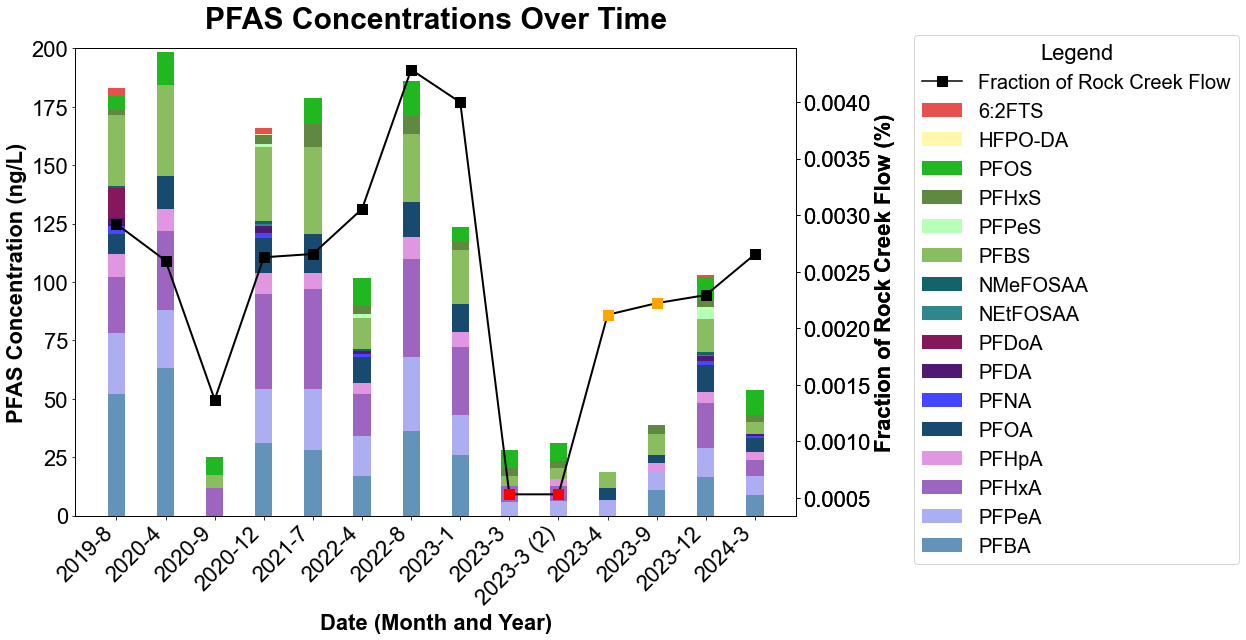

In [47]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Conc, std_dev_pivot_table=None,add_data_table=df_RC_Other, figsize=(18, 9), title='PFAS Concentrations Over Time', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=200)

### Average Concentrations

In [65]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for i, compound in enumerate(avg_pivot_table_filtered.columns):
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            if std_dev_pivot_table is not None:
                std_dev_values = std_dev_pivot_table.get(compound)
                # Only use std_dev_values where they are not NaN
                error_bars = std_dev_values.where(std_dev_values.notna(), None).values
            else:
                error_bars = None
            
            ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                   label=compound, yerr=error_bars if error_bars is not None else None, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)


        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()  # Optional: reverse the order of legend items
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        legend.get_title().set_fontweight('bold')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


In [71]:
#Specify where the file is saved use '/' instead of '\'
#excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 10-2-2024.xlsx'
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Conc = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc', usecols='C:T', skiprows=26, nrows=18)

df_RC_Conc=df_RC_Conc.set_index('Date')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Conc.columns]
# Reorder columns by indexing df with the desired order
df_RC_Conc = df_RC_Conc[filtered_order]
df_RC_Conc=df_RC_Conc.tail(4)

#new_index = ['Current', 'Rock Creek with Landfill Discharing Normally', 'Landfill Not Discharging', 'Landfill Discharging Without Riverbend']  # Replace these with your actual index names
#df_RC_Conc.index = new_index
#df_RC_Conc.drop('Rock Creek with Landfill Discharing Normally',inplace=True)

#new_order = ['Current', 'Landfill Discharging Without Riverbend','Landfill Not Discharging']

# Reordering the DataFrame
#df_RC_Conc = df_RC_Conc.reindex(new_order)

df_RC_Conc

PFBA      PFPeA  \
Date                                                                       
Average                                             28.940000  16.407692   
Average With Landfill Discharging Normally          30.933333  20.722222   
Average With Landfill Not Discharging                     NaN   6.200000   
Average with Landfill Discharging Without River...  11.000000   8.200000   

                                                        PFHxA     PFHpA  \
Date                                                                      
Average                                             23.541667  6.309091   
Average With Landfill Discharging Normally          26.940000  7.033333   
Average With Landfill Not Discharging                6.550000  3.000000   
Average with Landfill Discharging Without River...        NaN  3.100000   

                                                         PFOA  PFNA   PFDA  \
Date                                                                         
Average                                             10.790909  2.04  2.096   
Average With Landfill Discharging Normally          12.200000  2.04  2.096   
Average With Landfill Not Discharging                5.200000   NaN    NaN   
Average with Landfill Discharging Without River...   3.700000   NaN    NaN   

                                                    PFDoA  NEtFOSAA  NMeFOSAA  \
Date                                                                            
Average                                              13.0    0.5125     1.175   
Average With Landfill Discharging Normally           13.0    0.5125     1.175   
Average With Landfill Not Discharging                 NaN       NaN       NaN   
Average with Landfill Discharging Without River...    NaN       NaN       NaN   

                                                     PFBS     PFPeS     PFHxS  \
Date                                                                            
Average                                             18.05  2.633333  4.245455   
Average With Landfill Discharging Normally          22.74  2.633333  4.600000   
Average With Landfill Not Discharging                5.40       NaN  3.200000   
Average with Landfill Discharging Without River...   9.10       NaN  3.500000   

                                                         PFOS  HFPO-DA  6:2FTS  
Date                                                                            
Average                                              9.859091     0.53     2.3  
Average With Landfill Discharging Normally          10.372222     0.53     2.3  
Average With Landfill Not Discharging                7.550000      NaN     NaN  
Average with Landfill Discharging Without River...        NaN      NaN     NaN

In [69]:
#Specify where the file is saved use '/' instead of '\'
#excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 10-2-2024.xlsx'
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Error = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc', usecols='C:T', skiprows=26, nrows=33)

df_RC_Error=df_RC_Error.set_index('Date')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Error.columns]
# Reorder columns by indexing df with the desired order
df_RC_Error = df_RC_Error[filtered_order]

df_RC_Error=df_RC_Error.tail(4)

new_index = ['Current', 'Rock Creek with Landfill Discharing Normally', 'Landfill Not Discharging', 'Landfill Discharging Without Riverbend']  # Replace these with your actual index names
df_RC_Error.index = new_index
df_RC_Error.drop('Rock Creek with Landfill Discharing Normally',inplace=True)
new_order = ['Current', 'Landfill Discharging Without Riverbend','Landfill Not Discharging']

# Reordering the DataFrame
df_RC_Error = df_RC_Error.reindex(new_order)
df_RC_Error

PFBA     PFPeA     PFHxA  \
Current                                 5.554002  2.543858  4.080765   
Landfill Discharging Without Riverbend       NaN       NaN       NaN   
Landfill Not Discharging                     NaN  0.173205  0.050000   

                                           PFHpA      PFOA  PFNA      PFDA  \
Current                                 0.819141  1.341604  0.44  0.455429   
Landfill Discharging Without Riverbend       NaN       NaN   NaN       NaN   
Landfill Not Discharging                     NaN       NaN   NaN       NaN   

                                        PFDoA  NEtFOSAA  NMeFOSAA      PFBS  \
Current                                   NaN    0.1775  0.085391  3.489100   
Landfill Discharging Without Riverbend    NaN       NaN       NaN       NaN   
Landfill Not Discharging                  NaN       NaN       NaN  0.754983   

                                           PFPeS     PFHxS      PFOS  HFPO-DA  \
Current                                 1.315324  0.729678  0.913754      NaN   
Landfill Discharging Without Riverbend       NaN       NaN       NaN      NaN   
Landfill Not Discharging                     NaN  0.300000  0.150000      NaN   

                                          6:2FTS  
Current                                 0.832666  
Landfill Discharging Without Riverbend       NaN  
Landfill Not Discharging                     NaN

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

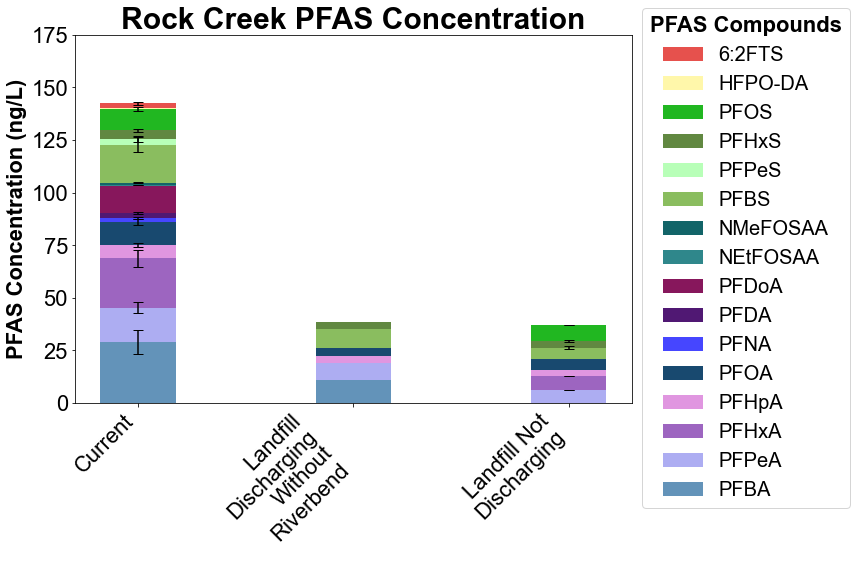

In [70]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Conc, std_dev_pivot_table=df_RC_Error, figsize=(12, 8), title='Rock Creek PFAS Concentration', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=175)

### Rock Creek Conc BDL

In [16]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Conc = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc BDL', usecols='C:T', skiprows=24, nrows=15)

df_RC_Conc=df_RC_Conc.set_index('Date')
df_RC_Conc=df_RC_Conc.iloc[:-1, :-1]
desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Conc.columns]
# Reorder columns by indexing df with the desired order
df_RC_Conc = df_RC_Conc[filtered_order]
df_RC_Conc

PFBA  PFPeA  PFHxA  PFHpA   PFOA  PFNA  PFDA    PFDoA  NEtFOSAA  \
Date                                                                       
2019-8   52.0  26.00   24.0  10.00   8.50  3.60  3.10  13.0000    0.2850   
2020-4   63.0  25.00   34.0   9.40  14.00  2.50  2.50   2.5000    2.5000   
2020-9   10.0   2.55   12.0   2.55   2.55  2.55  2.55   2.5500    2.5500   
2020-12  31.0  23.00   41.0   8.70  15.00  2.40  3.00   0.2250    0.6900   
2021-7   28.0  26.00   43.0   6.70  17.00  2.50  2.50   2.5000    2.5000   
2022-4   17.0  17.00   18.0   4.80  11.00  1.40  1.20   0.2700    0.2700   
2022-8   36.0  32.00   42.0   9.30  15.00  2.50  2.50   2.5000    2.5000   
2023-1   26.0  17.00   29.0   6.50  12.00  1.00  1.50   2.0000    2.5000   
2023-3    5.0   5.90    6.6   1.50   1.50  1.00  1.50   2.0000    2.5000   
2023-3    5.0   6.20    6.5   3.00   1.50  1.00  1.50   2.0000    2.5000   
2023-4   10.0   6.50    4.5   2.50   5.20  2.50  2.50   2.5000    2.5000   
2023-9   11.0   8.20    5.0   3.10   3.70  1.00  1.50   2.0000    2.5000   
2023-12  16.5  12.30   19.5   4.70  11.50  1.60  2.30   0.2125    0.4525   
2024-3    8.9   8.20    6.9   3.20   5.80  1.20  0.88   0.3050    0.4300   

         NMeFOSAA  PFBS  PFPeS  PFHxS    PFOS  HFPO-DA  6:2FTS  
Date                                                            
2019-8       1.10  30.0  0.285   2.20   6.100   0.2850    3.50  
2020-4       3.00  39.0  2.500   2.50  14.000   2.5000   10.00  
2020-9       3.05   5.4  2.550   2.55   7.800   2.5500   10.00  
2020-12      1.20  32.0  0.970   3.90   0.225   0.5300    2.70  
2021-7       3.00  37.0  2.500  10.00  11.000   2.5000   10.00  
2022-4       1.00  13.0  1.700   3.50  12.000      NaN    1.05  
2022-8       3.00  29.0  2.500   7.90  15.000   5.0000     NaN  
2023-1       2.00  23.0  1.500   3.60   6.400   2.0000    2.50  
2023-3       2.00   4.5  1.500   3.50   7.400   2.0000    2.50  
2023-3       2.00   4.8  1.500   2.90   7.700   2.0000    2.50  
2023-4       3.00   6.9  2.500   2.50   5.000   5.0000     NaN  
2023-9       2.00   9.1  1.500   3.50   2.500   2.0000    2.50  
2023-12      1.40  14.0  5.230   2.90  10.050   0.5675    1.30  
2024-3       0.75   5.0  0.305   2.80  11.000   1.2500   15.50

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

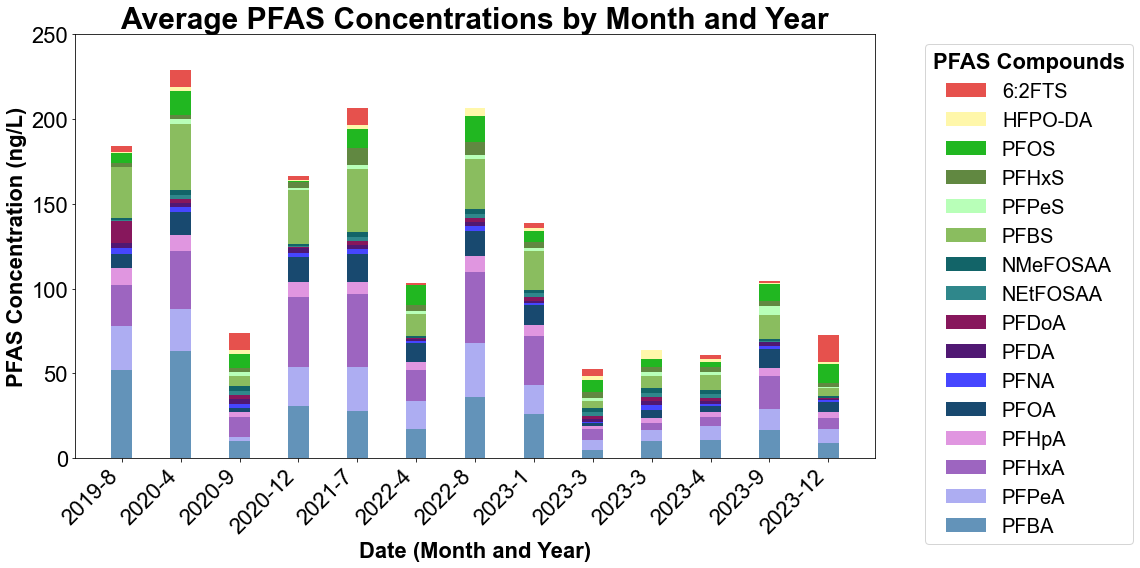

In [17]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Conc, std_dev_pivot_table=None, figsize=(16, 8), title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=250)

### Landfill Comb Conc BQL

In [9]:
def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        #print("Filtered columns:", avg_pivot_table_filtered.columns)
        
        if std_dev_pivot_table is not None and not std_dev_pivot_table.empty:
            std_dev_pivot_table_filtered = std_dev_pivot_table.fillna(0)[avg_pivot_table_filtered.columns]
        else:
            std_dev_pivot_table_filtered = pd.DataFrame(columns=avg_pivot_table_filtered.columns, index=avg_pivot_table_filtered.index)
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values))
            
            #print(f"Plotting {compound}: Values = {avg_values}, Bottom = {bottom}")
            
            bars = ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                          label=compound, yerr=std_dev_values, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)

        ax.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2, ncol=1)
        legend.get_title().set_fontweight('bold')  # Set the legend title to bold

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage assuming 'avg_pivot_table' and 'std_dev_pivot_table' are defined along with 'compound_colors_dict'
# create_stacked_bar_chart_filtered(avg_pivot_table)

In [85]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Conc = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL', usecols='B:S', skiprows=31, nrows=21)

df_Land_Conc=df_Land_Conc.set_index('Date')
df_Land_Conc=df_Land_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
df_Land_Conc = df_Land_Conc[filtered_order]

new_index = df_Land_Conc.index.tolist()  # Convert index to a list for easy manipulation
new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
df_Land_Conc.index = new_index

df_Land_Conc=df_Land_Conc.drop(index=['2023-12'])

df_Land_Conc


PFBA   PFPeA   PFHxA   PFHpA    PFOA   PFNA   PFDA  PFDoA  \
2019-8      2600.0  1700.0  5100.0   750.0  1300.0   50.0   62.0    9.1   
2019-10     3800.0  1700.0  3500.0   670.0  1300.0   88.0   61.0    NaN   
2020-12     2600.0  2200.0  4500.0   770.0  1600.0  130.0  320.0    NaN   
2021-2      2800.0  1500.0  2900.0   610.0  1000.0  100.0  180.0    NaN   
2021-5      3100.0  2200.0  3000.0   720.0  1300.0  150.0  190.0    NaN   
2021-8      7300.0  2600.0  3800.0  1100.0  1700.0  200.0  130.0    NaN   
2021-10     2500.0  1600.0  2000.0   410.0   850.0  110.0  150.0   13.0   
2022-3      4500.0  3400.0  3700.0   960.0  1400.0   96.0   79.0   12.0   
2022-4      3950.0  3900.0  4500.0   695.0  1200.0   63.0  104.0   15.0   
2022-8      3100.0  2700.0  4500.0   750.0  1400.0  100.0  140.0    NaN   
2022-9      4800.0  3600.0  4300.0   900.0  1500.0  120.0  170.0   22.0   
2022-12     3200.0  2800.0  4000.0   940.0  1600.0  140.0  220.0   18.0   
2023-1      2500.0  2500.0  4050.0   790.0  1700.0  155.0  215.0   15.0   
2023-4      2600.0  1100.0  2200.0   680.0  1400.0   73.0   37.0    NaN   
2023-9      2300.0  1200.0  2000.0   760.0  1300.0   75.0   34.0    NaN   
2023-10     4300.0  3800.0  6300.0   920.0  1800.0  300.0  400.0   54.0   
2024-3      3100.0  2100.0  2600.0   600.0  1300.0  110.0   88.0    NaN   
2024-3 (2)  3200.0  2400.0  3000.0   870.0  1600.0   91.0   68.0    NaN   
2024-5      3100.0  3100.0  4200.0   770.0  2000.0  130.0  230.0   13.0   

            NEtFOSAA  NMeFOSAA    PFBS  PFPeS   PFHxS    PFOS  HFPO-DA  6:2FTS  
2019-8          42.0     190.0  5200.0   64.0   460.0   240.0      NaN   360.0  
2019-10        110.0     260.0  3500.0   77.0   580.0   770.0      NaN   630.0  
2020-12        170.0     170.0  5000.0   75.0   580.0   890.0      NaN  1000.0  
2021-2          62.0     260.0  3800.0   38.0   320.0   270.0      NaN   240.0  
2021-5         130.0     450.0  3000.0   38.0   540.0  1500.0      NaN   400.0  
2021-8         140.0     570.0  3200.0  170.0  1300.0  2400.0      NaN     NaN  
2021-10         70.0     530.0  2000.0   21.0   250.0   340.0      NaN   200.0  
2022-3          55.0     580.0  3500.0   47.0   570.0   260.0      NaN   470.0  
2022-4          37.0     115.0  4200.0   22.0   265.0   145.0      NaN   150.0  
2022-8          74.0     210.0  3400.0  190.0   840.0  1900.0      NaN   610.0  
2022-9         150.0     330.0  4300.0   86.0   580.0   680.0      NaN   690.0  
2022-12        290.0     340.0  3700.0   93.0   600.0   980.0      NaN  1000.0  
2023-1         122.0     490.0  3550.0   46.5   440.0   340.0      NaN   370.0  
2023-4         180.0     430.0   870.0  160.0   890.0  1900.0      NaN   810.0  
2023-9         200.0     740.0   930.0  120.0   810.0  1100.0     59.0   710.0  
2023-10         69.0     150.0  6600.0   27.0   400.0   230.0      NaN   250.0  
2024-3          51.0     190.0  1600.0   49.0   470.0   650.0      NaN   380.0  
2024-3 (2)      63.0     280.0  2100.0    NaN   530.0   380.0      NaN   350.0  
2024-5          86.0     250.0  2400.0   33.0   460.0   650.0      NaN   410.0

In [86]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL', usecols='B:T', skiprows=31, nrows=20)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['Total PFAS','Landfill Flow (MGD)']]

new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
df_Land_Other.index = new_index

df_Land_Other=df_Land_Other.drop(index=['2023-12'])

df_Land_Other

Total PFAS  Landfill Flow (MGD)
2019-8         18127.1             0.077610
2019-10        17046.0             0.069192
2020-12        20005.0             0.104075
2021-2         14080.0             0.148910
2021-5         16718.0             0.088985
2021-8         24610.0             0.069768
2021-10        11044.0             0.074318
2022-3         19629.0             0.126118
2022-4         19361.0             0.130448
2022-8         19914.0             0.115451
2022-9         22228.0             0.114265
2022-12        19921.0             0.164141
2023-1         17283.5             0.196257
2023-4         13330.0             0.111119
2023-9         12338.0             0.067547
2023-10        25600.0             0.059908
2024-3         13288.0             0.135961
2024-3 (2)     14932.0             0.135961
2024-5         17832.0             0.099532

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, add_data_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax1 = plt.subplots(figsize=figsize)

        # Stacked Bar Plot
        bottom = np.zeros(len(avg_pivot_table_filtered.index))
        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values)) if std_dev_pivot_table is not None else np.zeros_like(avg_values)
            ax1.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color, label=compound, yerr=std_dev_values, capsize=0)
            bottom += avg_values

        # Line Chart for Landfill Flow
        ax2 = ax1.twinx()
        if add_data_table is not None:
            ax2.plot(add_data_table.index, add_data_table['Landfill Flow (MGD)'], color='blue', label='Landfill Flow (MGD)', linewidth=2.0)
            ax2.set_ylabel('Landfill Flow (MGD)', fontsize=axis_label_fontsize, fontproperties=font_bold)

        # Scatter Plot with Trendline for Total PFAS
        if 'Total PFAS' in add_data_table.columns:
            scatter_x = add_data_table.index
            scatter_y = add_data_table['Total PFAS']
            ax1.scatter(scatter_x, scatter_y, color='black', label='Total PFAS', zorder=5)

            # Calculate trendline
            slope, intercept, r_value, p_value, std_err = linregress(range(len(scatter_x)), scatter_y)
            line = slope * np.arange(len(scatter_x)) + intercept
            ax1.plot(scatter_x, line, 'r--', label=f'Trendline: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}\np-value = {p_value:.2f}')

        ax1.set_ylim(0, ylim)
        ax1.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_title(title, fontsize=title_fontsize, fontproperties=font_bold, pad=20)
        ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)
        
        # Combine legend handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        all_handles = handles1 + handles2
        all_labels = labels1 + labels2
        
        ax1.legend(handles=all_handles, labels=all_labels, title='Legend', bbox_to_anchor=(1.15, 1.05), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")



<ipython-input-87-45b4089ddb2b>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


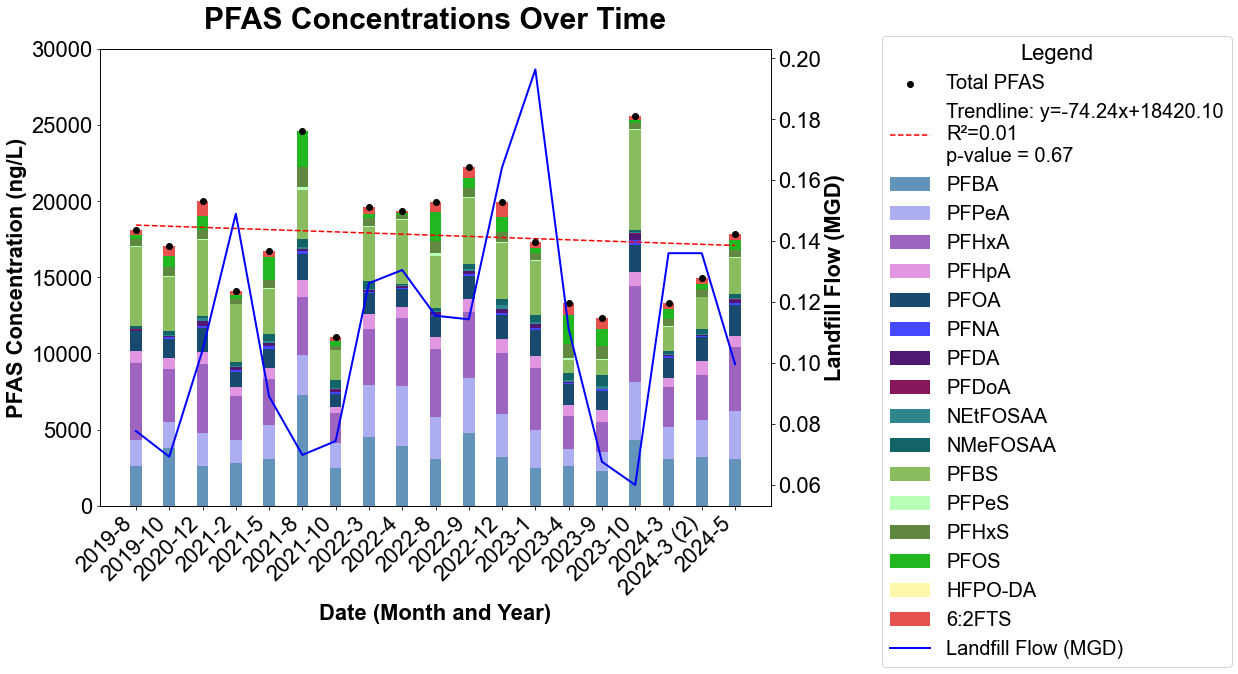

In [88]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Land_Conc, std_dev_pivot_table=None,add_data_table=df_Land_Other, figsize=(18, 9), title='PFAS Concentrations Over Time', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=30000)

#### Landfill Comb Conc BQL (CWS)

In [89]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Conc = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (CWS)', usecols='B:S', skiprows=31, nrows=9)

df_Land_Conc=df_Land_Conc.set_index('Date')
df_Land_Conc=df_Land_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
df_Land_Conc = df_Land_Conc[filtered_order]

#new_index = df_Land_Conc.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Conc.index = new_index

df_Land_Conc=df_Land_Conc.drop(index=['2023-12'])

df_Land_Conc

PFBA   PFPeA   PFHxA  PFHpA    PFOA   PFNA   PFDA  PFDoA  NEtFOSAA  \
Date                                                                           
2019-8  2600.0  1700.0  5100.0  750.0  1300.0   50.0   62.0    9.1      42.0   
2022-4  2800.0  3800.0  4700.0  590.0  1200.0    NaN  110.0    NaN       NaN   
2022-8  3100.0  2700.0  4500.0  750.0  1400.0  100.0  140.0    NaN      74.0   
2023-1  2100.0  2300.0  4000.0  820.0  2000.0  180.0  250.0   16.0     150.0   
2023-4  2600.0  1100.0  2200.0  680.0  1400.0   73.0   37.0    NaN     180.0   
2023-9  2300.0  1200.0  2000.0  760.0  1300.0   75.0   34.0    NaN     200.0   
2024-3  3100.0  2100.0  2600.0  600.0  1300.0  110.0   88.0    NaN      51.0   

        NMeFOSAA    PFBS  PFPeS  PFHxS    PFOS  HFPO-DA  6:2FTS  
Date                                                             
2019-8     190.0  5200.0   64.0  460.0   240.0      NaN   360.0  
2022-4     120.0  4000.0    NaN  250.0   150.0      NaN     NaN  
2022-8     210.0  3400.0  190.0  840.0  1900.0      NaN   610.0  
2023-1     600.0  3400.0   53.0  480.0   350.0      NaN   390.0  
2023-4     430.0   870.0  160.0  890.0  1900.0      NaN   810.0  
2023-9     740.0   930.0  120.0  810.0  1100.0     59.0   710.0  
2024-3     190.0  1600.0   49.0  470.0   650.0      NaN   380.0

In [90]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (CWS)', usecols='B:T', skiprows=31, nrows=8)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['Total PFAS','Landfill Flow (MGD)']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index
df_Land_Other=df_Land_Other.drop(index=['2023-12'])

df_Land_Other

Total PFAS  Landfill Flow (MGD)
Date                                   
2019-8     18127.1             0.077610
2022-4     17720.0             0.130448
2022-8     19914.0             0.115451
2023-1     17089.0             0.196257
2023-4     13330.0             0.111119
2023-9     12338.0             0.067547
2024-3     13288.0             0.135961

<ipython-input-87-45b4089ddb2b>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


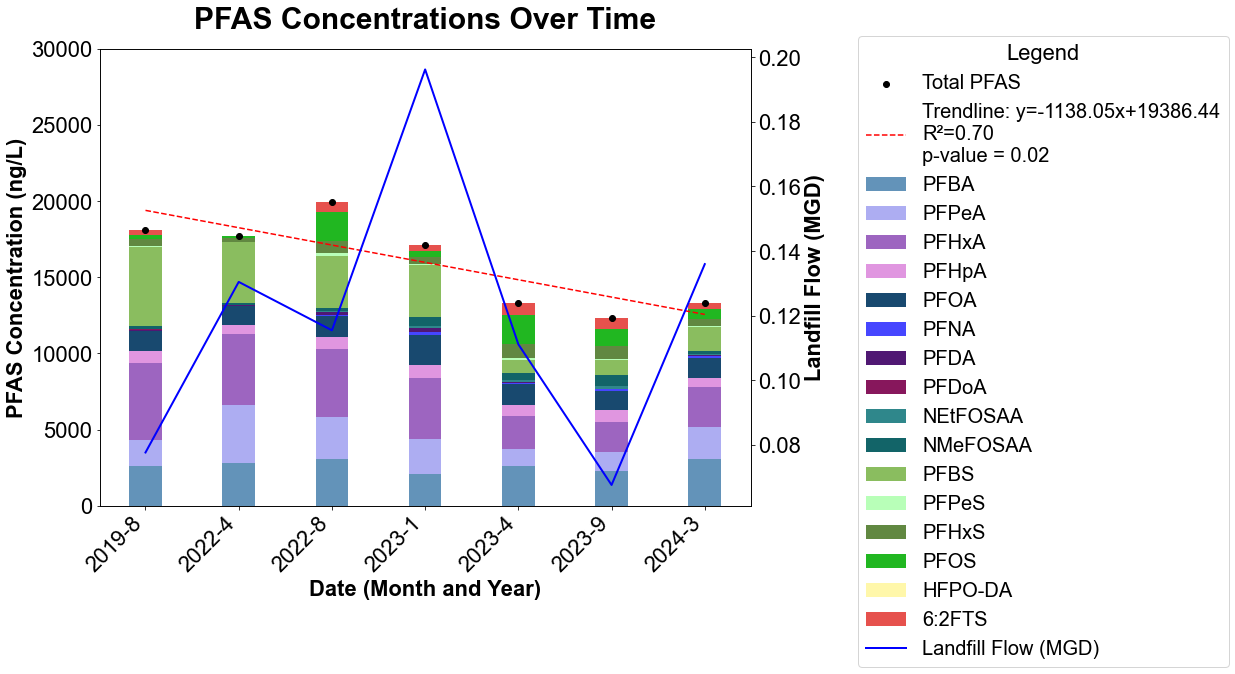

In [91]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Land_Conc, std_dev_pivot_table=None,add_data_table=df_Land_Other, figsize=(18, 9), title='PFAS Concentrations Over Time', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=30000)

#### Landfill Comb Conc BQL (WM)

In [24]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Conc = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (WM)', usecols='B:S', skiprows=31, nrows=15)

df_Land_Conc=df_Land_Conc.set_index('Date')
df_Land_Conc=df_Land_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
df_Land_Conc = df_Land_Conc[filtered_order]

#new_index = df_Land_Conc.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Conc.index = new_index

df_Land_Conc

PFBA   PFPeA   PFHxA   PFHpA    PFOA   PFNA   PFDA  PFDoA  \
Date                                                                   
2019-10  3800.0  1700.0  3500.0   670.0  1300.0   88.0   61.0    NaN   
2020-12  2600.0  2200.0  4500.0   770.0  1600.0  130.0  320.0    NaN   
2021-2   2800.0  1500.0  2900.0   610.0  1000.0  100.0  180.0    NaN   
2021-5   3100.0  2200.0  3000.0   720.0  1300.0  150.0  190.0    NaN   
2021-8   7300.0  2600.0  3800.0  1100.0  1700.0  200.0  130.0    NaN   
2021-10  2500.0  1600.0  2000.0   410.0   850.0  110.0  150.0   13.0   
2022-3   4500.0  3400.0  3700.0   960.0  1400.0   96.0   79.0   12.0   
2022-4   5100.0  4000.0  4300.0   800.0  1200.0   63.0   98.0   15.0   
2022-9   4800.0  3600.0  4300.0   900.0  1500.0  120.0  170.0   22.0   
2022-12  3200.0  2800.0  4000.0   940.0  1600.0  140.0  220.0   18.0   
2023-1   2900.0  2700.0  4100.0   760.0  1400.0  130.0  180.0   14.0   
2023-10  4300.0  3800.0  6300.0   920.0  1800.0  300.0  400.0   54.0   
2024-3   3200.0  2400.0  3000.0   870.0  1600.0   91.0   68.0    NaN   
2024-5   3100.0  3100.0  4200.0   770.0  2000.0  130.0  230.0   13.0   

         NEtFOSAA  NMeFOSAA    PFBS  PFPeS   PFHxS    PFOS  HFPO-DA  6:2FTS  
Date                                                                         
2019-10     110.0     260.0  3500.0   77.0   580.0   770.0      NaN   630.0  
2020-12     170.0     170.0  5000.0   75.0   580.0   890.0      NaN  1000.0  
2021-2       62.0     260.0  3800.0   38.0   320.0   270.0      NaN   240.0  
2021-5      130.0     450.0  3000.0   38.0   540.0  1500.0      NaN   400.0  
2021-8      140.0     570.0  3200.0  170.0  1300.0  2400.0      NaN     NaN  
2021-10      70.0     530.0  2000.0   21.0   250.0   340.0      NaN   200.0  
2022-3       55.0     580.0  3500.0   47.0   570.0   260.0      NaN   470.0  
2022-4       37.0     110.0  4400.0   22.0   280.0   140.0      NaN   150.0  
2022-9      150.0     330.0  4300.0   86.0   580.0   680.0      NaN   690.0  
2022-12     290.0     340.0  3700.0   93.0   600.0   980.0      NaN  1000.0  
2023-1       94.0     380.0  3700.0   40.0   400.0   330.0      NaN   350.0  
2023-10      69.0     150.0  6600.0   27.0   400.0   230.0      NaN   250.0  
2024-3       63.0     280.0  2100.0    NaN   530.0   380.0      NaN   350.0  
2024-5       86.0     250.0  2400.0   33.0   460.0   650.0      NaN   410.0

In [23]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (WM)', usecols='B:T', skiprows=31, nrows=14)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['Total PFAS','Landfill Flow (MGD)']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index

df_Land_Other

Total PFAS  Landfill Flow (MGD)
Date                                    
2019-10       17046             0.069192
2020-12       20005             0.104075
2021-2        14080             0.148910
2021-5        16718             0.088985
2021-8        24610             0.069768
2021-10       11044             0.074318
2022-3        19629             0.126118
2022-4        20715             0.130448
2022-9        22228             0.114265
2022-12       19921             0.164141
2023-1        17478             0.196257
2023-10       25600             0.059908
2024-3        14932             0.135961
2024-5        17832             0.099532

<ipython-input-12-45b4089ddb2b>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


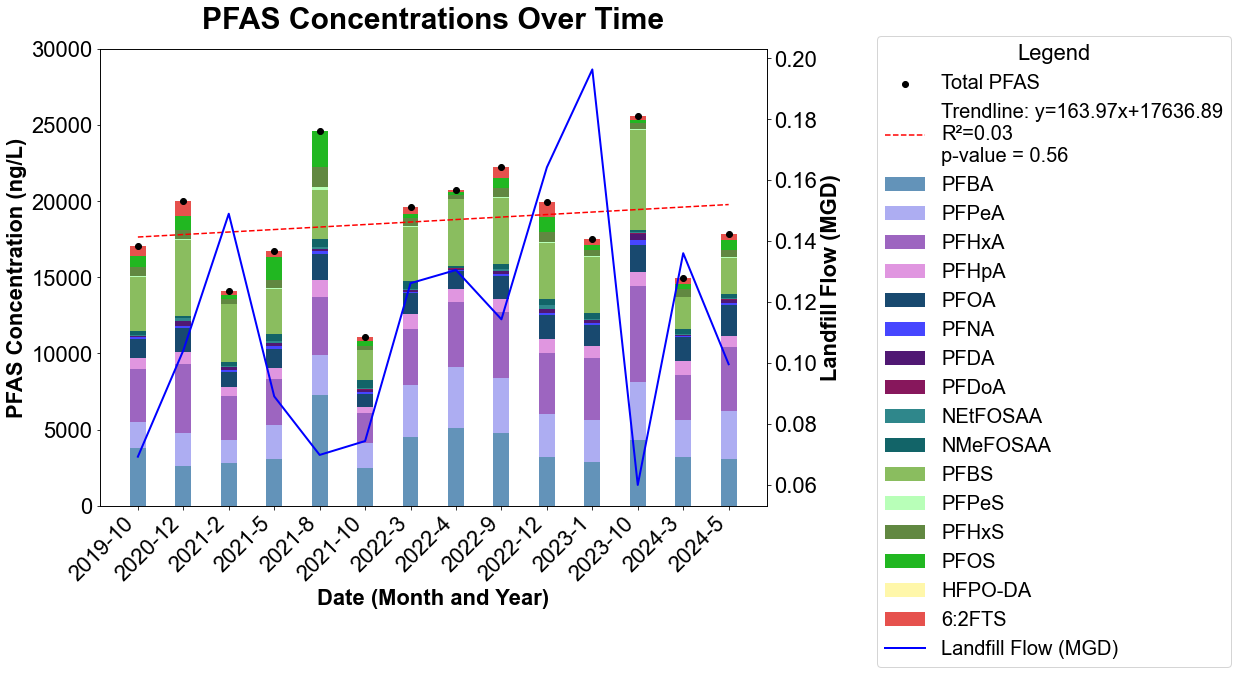

In [25]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Land_Conc, std_dev_pivot_table=None,add_data_table=df_Land_Other, figsize=(18, 9), title='PFAS Concentrations Over Time', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=30000)

#### Total PFAS Concentration vs Fraction of Flow from Riverbend

In [26]:
def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x]*100, data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x]*100, data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    ax.plot(data_df[column_x]*100, intercept + slope * data_df[column_x]*100,'r--')

    # Adding titles and labels with custom fonts
    ax.set_title('Total PFAS Concentration vs Fraction of Flow from Riverbend', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Fraction of Flow from Riverbend (%)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    ax.annotate(f'R² = {r_squared:.3f}\np-value = {p_value:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=22, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))


    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

In [28]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL', usecols='B:V', skiprows=31, nrows=20)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['Total PFAS','Fraction of Flow from Riverbend']]

new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
df_Land_Other.index = new_index

df_Land_Other

Total PFAS  Fraction of Flow from Riverbend
2019-8         18127.1                         0.569230
2019-10        17046.0                         0.559059
2020-12        20005.0                         0.487707
2021-2         14080.0                         0.424415
2021-5         16718.0                         0.588269
2021-8         24610.0                         0.628592
2021-10        11044.0                         0.540057
2022-3         19629.0                         0.273127
2022-4         19361.0                         0.364955
2022-8         19914.0                         0.749804
2022-9         22228.0                         0.762797
2022-12        19921.0                         0.351838
2023-1         17283.5                         0.364113
2023-4         13330.0                         0.000000
2023-9         12338.0                         0.240132
2023-10        25600.0                         0.346543
2023-12         5234.0                         0.098611
2024-3         13288.0                         0.213141
2024-3 (2)     14932.0                         0.213141
2024-5         17832.0                         0.385437

In [57]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd
from matplotlib.ticker import FuncFormatter

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    ax.plot(data_df[column_x], intercept + slope * data_df[column_x], 'r')

    # Adding titles and labels with custom fonts
    ax.set_title('Total PFAS Concentration vs Fraction of Flow from Riverbend', fontsize=title_fontsize, fontproperties=font_bold, pad=20)
    ax.set_xlabel('Fraction of Flow from Riverbend (%)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylim(0, 30000)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    # Formatting x-axis as percentage
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{100 * x:.0f}'))

    #plt.legend()
    plt.tight_layout()
    plt.show()


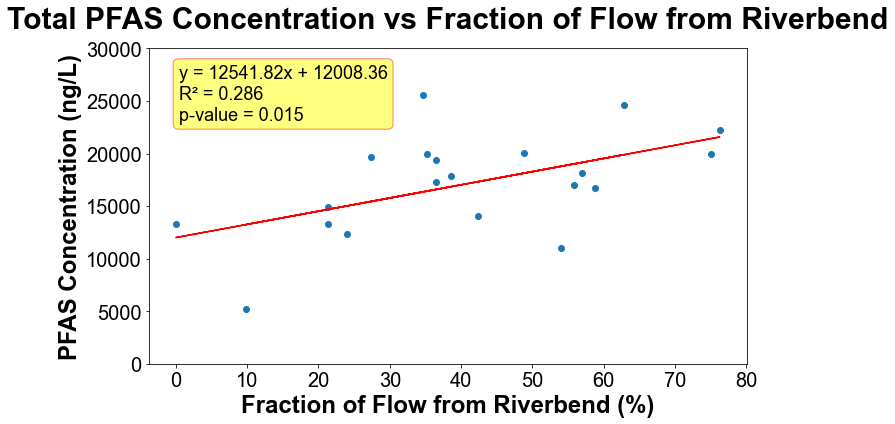

In [58]:
plot_scatter(data_df=df_Land_Other, column_x='Fraction of Flow from Riverbend', column_y='Total PFAS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

#### CWS Data

In [61]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (CWS)', usecols='B:V', skiprows=31, nrows=8)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['Total PFAS','Fraction of Flow from Riverbend']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index

df_Land_Other

Total PFAS  Fraction of Flow from Riverbend
Date                                                
2019-8      18127.1                         0.569230
2022-4      17720.0                         0.364955
2022-8      19914.0                         0.749804
2023-1      17089.0                         0.364113
2023-4      13330.0                         0.000000
2023-9      12338.0                         0.240132
2023-12      5234.0                         0.098611
2024-3      13288.0                         0.213141

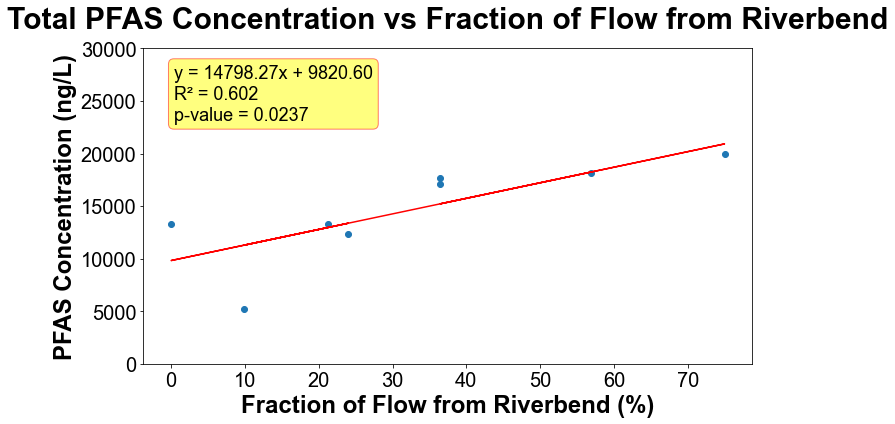

In [62]:
plot_scatter(data_df=df_Land_Other, column_x='Fraction of Flow from Riverbend', column_y='Total PFAS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

#### WM data

In [64]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (WM)', usecols='B:V', skiprows=31, nrows=14)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['Total PFAS','Fraction of Flow from Riverbend']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index

df_Land_Other

Total PFAS  Fraction of Flow from Riverbend
Date                                                
2019-10       17046                         0.559059
2020-12       20005                         0.487707
2021-2        14080                         0.424415
2021-5        16718                         0.588269
2021-8        24610                         0.628592
2021-10       11044                         0.540057
2022-3        19629                         0.273127
2022-4        20715                         0.364955
2022-9        22228                         0.762797
2022-12       19921                         0.351838
2023-1        17478                         0.364113
2023-10       25600                         0.346543
2024-3        14932                         0.213141
2024-5        17832                         0.385437

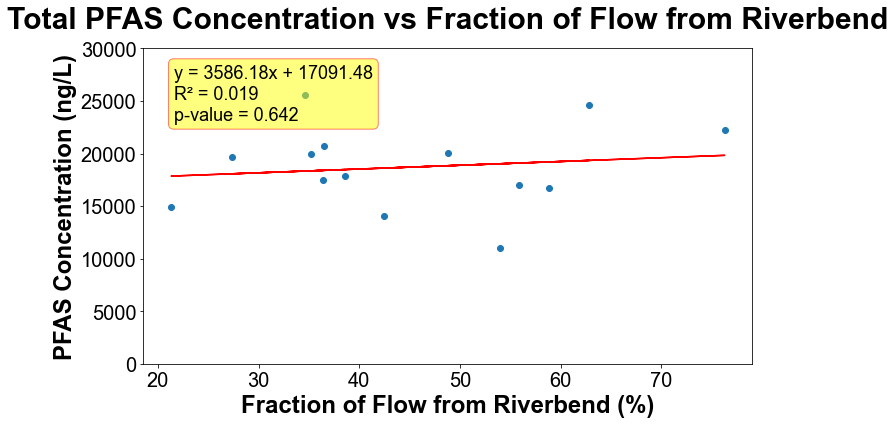

In [65]:
plot_scatter(data_df=df_Land_Other, column_x='Fraction of Flow from Riverbend', column_y='Total PFAS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

#### PFOS/PFOA conc. Vs flow 

In [99]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    ax.plot(data_df[column_x], intercept + slope * data_df[column_x], 'r')

    # Adding titles and labels with custom fonts
    ax.set_title('PFOS vs Landfill Flow', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Landfill Flow (MGD)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    #plt.legend()
    plt.tight_layout()
    plt.show()

In [79]:
# Read the Excel file
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-25-24.xlsx'
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL', usecols='B:V', skiprows=31, nrows=20)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['PFOA','PFOS','Landfill Flow (MGD)']]

new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
df_Land_Other.index = new_index

df_Land_Other

PFOA  PFOS  Landfill Flow (MGD)
2019-8      1300   240             0.077610
2019-10     1300   770             0.069192
2020-12     1600   890             0.104075
2021-2      1000   270             0.148910
2021-5      1300  1500             0.088985
2021-8      1700  2400             0.069768
2021-10      850   340             0.074318
2022-3      1400   260             0.126118
2022-4      1200   145             0.130448
2022-8      1400  1900             0.115451
2022-9      1500   680             0.114265
2022-12     1600   980             0.164141
2023-1      1700   340             0.196257
2023-4      1400  1900             0.111119
2023-9      1300  1100             0.067547
2023-10     1800   230             0.059908
2023-12      475   155             0.127723
2024-3      1300   650             0.135961
2024-3 (2)  1600   380             0.135961
2024-5      2000   650             0.099532

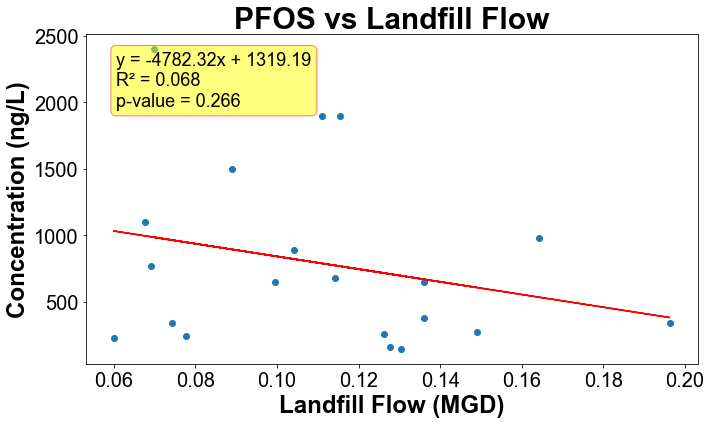

In [80]:
plot_scatter(data_df=df_Land_Other, column_x='Landfill Flow (MGD)', column_y='PFOS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

#### PFOA/PFOS over Time

In [42]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd
import matplotlib.dates as mdates

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    x_numeric = mdates.date2num(data_df[column_x])  # Convert dates to numeric format for regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    dates_for_line = pd.date_range(start=data_df[column_x].min(), end=data_df[column_x].max(), freq='D')
    ax.plot(dates_for_line, intercept + slope * mdates.date2num(dates_for_line), 'r')

    # Setting x-axis format
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Locate ticks at the start of each year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'Year-month'

    # Adding titles and labels with custom fonts
    ax.set_title('PFOA Over Time', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Sample Date', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()


In [43]:
# Read the Excel file
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Overall Landfill Conc.', usecols='A:P', skiprows=33, nrows=20)

#df_Land_Other=df_Land_Other.set_index('')

df_Land_Other=df_Land_Other[['Date',"Row Labels",'PFOA','PFOS']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
df_Land_Other['Date'][18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index

df_Land_Other

Date Row Labels  PFOA  PFOS
0       2019-8 2019-08-15  1300   240
1      2019-10 2019-10-29  1300   770
2      2020-12 2020-12-28  1600   890
3       2021-2 2021-02-16  1000   270
4       2021-5 2021-05-19  1300  1500
5       2021-8 2021-08-18  1700  2400
6      2021-10 2021-10-21   850   340
7       2022-3 2022-03-10  1400   260
8       2022-4 2022-04-13  1200   145
9       2022-8 2022-08-04  1400  1900
10      2022-9 2022-09-07  1500   680
11     2022-12 2022-12-15  1600   980
12      2023-1 2023-01-26  1700   340
13      2023-4 2023-04-07  1400  1900
14      2023-9 2023-09-11  1300  1100
15     2023-10 2023-10-19  1800   230
16     2023-12 2023-12-06   475   155
17      2024-3 2024-03-12  1300   650
18  2024-3 (2) 2024-03-21  1600   380
19      2024-5 2024-05-08  2000   650

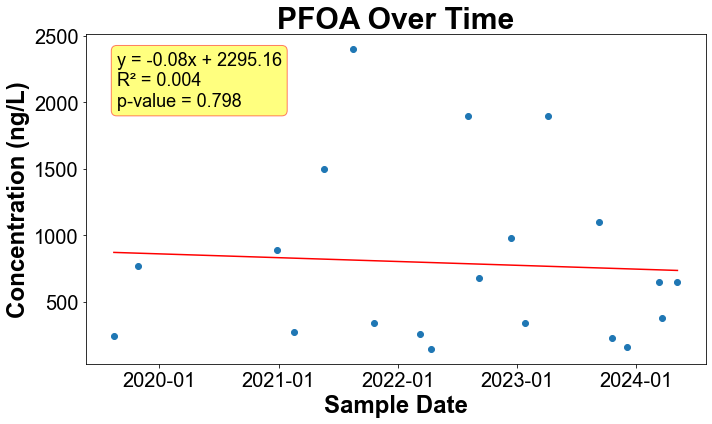

In [45]:
plot_scatter(data_df=df_Land_Other, column_x='Row Labels', column_y='PFOS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

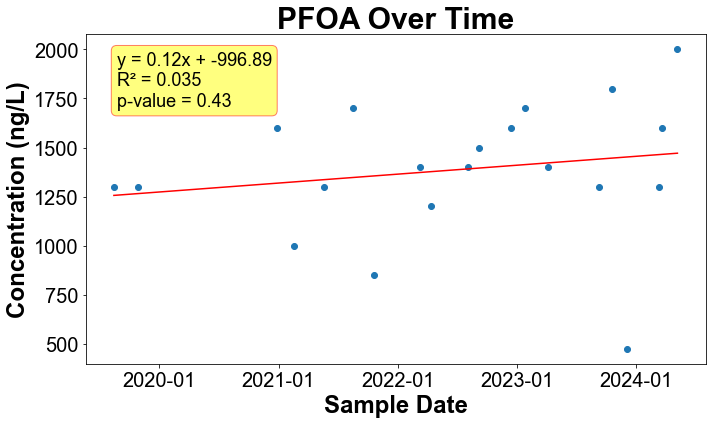

In [44]:
plot_scatter(data_df=df_Land_Other, column_x='Row Labels', column_y='PFOA', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

#### CWS Data

In [81]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (CWS)', usecols='B:V', skiprows=31, nrows=8)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['PFOA','PFOS','Landfill Flow (MGD)']]

df_Land_Other

PFOA  PFOS  Landfill Flow (MGD)
Date                                    
2019-8   1300   240             0.077610
2022-4   1200   150             0.130448
2022-8   1400  1900             0.115451
2023-1   2000   350             0.196257
2023-4   1400  1900             0.111119
2023-9   1300  1100             0.067547
2023-12   475   155             0.127723
2024-3   1300   650             0.135961

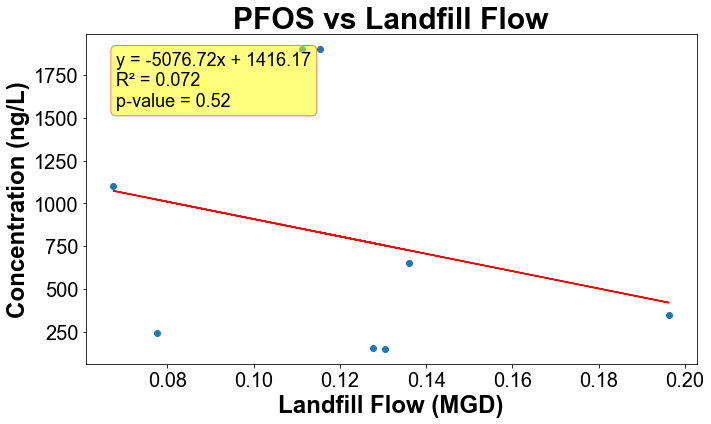

In [82]:
plot_scatter(data_df=df_Land_Other, column_x='Landfill Flow (MGD)', column_y='PFOS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

#### PFOS/PFOS over Time

In [52]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd
import matplotlib.dates as mdates

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    x_numeric = mdates.date2num(data_df[column_x])  # Convert dates to numeric format for regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    dates_for_line = pd.date_range(start=data_df[column_x].min(), end=data_df[column_x].max(), freq='D')
    ax.plot(dates_for_line, intercept + slope * mdates.date2num(dates_for_line), 'r')

    # Setting x-axis format
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Locate ticks at the start of each year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'Year-month'

    # Adding titles and labels with custom fonts
    ax.set_title('PFOA Over Time', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Sample Date', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

In [48]:
# Read the Excel file
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Overall Landfill Conc. (CWS)', usecols='A:P', skiprows=33, nrows=8)

#df_Land_Other=df_Land_Other.set_index('')

df_Land_Other=df_Land_Other[['Date',"Row Labels",'PFOA','PFOS']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
df_Land_Other['Date'][18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index

df_Land_Other

Date Row Labels  PFOA  PFOS
0   2019-8 2019-08-15  1300   240
1   2022-4 2022-04-13  1200   150
2   2022-8 2022-08-04  1400  1900
3   2023-1 2023-01-26  2000   350
4   2023-4 2023-04-07  1400  1900
5   2023-9 2023-09-11  1300  1100
6  2023-12 2023-12-06   475   155
7   2024-3 2024-03-12  1300   650

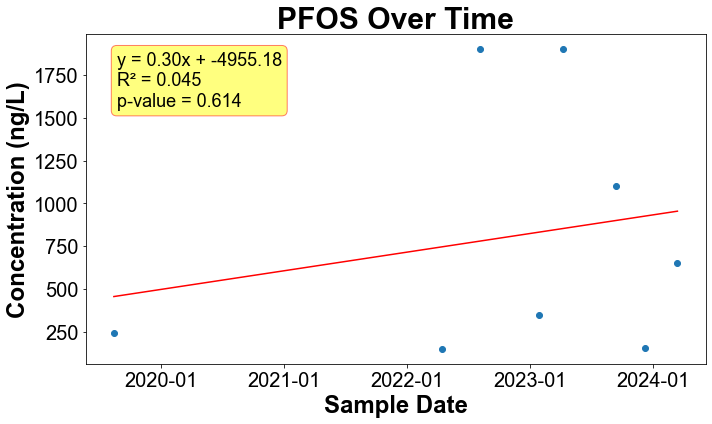

In [51]:
plot_scatter(data_df=df_Land_Other, column_x='Row Labels', column_y='PFOS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

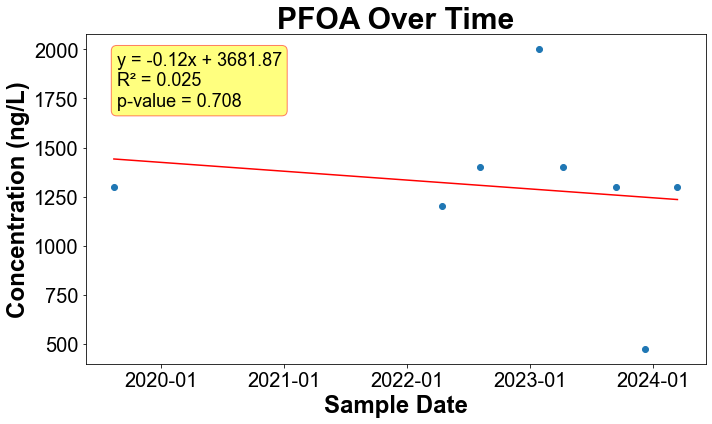

In [53]:
plot_scatter(data_df=df_Land_Other, column_x='Row Labels', column_y='PFOA', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

### WM data

In [83]:
# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BQL (WM)', usecols='B:V', skiprows=31, nrows=14)

df_Land_Other=df_Land_Other.set_index('Date')

df_Land_Other=df_Land_Other[['PFOA','PFOS','Landfill Flow (MGD)']]

df_Land_Other

PFOA  PFOS  Landfill Flow (MGD)
Date                                    
2019-10  1300   770             0.069192
2020-12  1600   890             0.104075
2021-2   1000   270             0.148910
2021-5   1300  1500             0.088985
2021-8   1700  2400             0.069768
2021-10   850   340             0.074318
2022-3   1400   260             0.126118
2022-4   1200   140             0.130448
2022-9   1500   680             0.114265
2022-12  1600   980             0.164141
2023-1   1400   330             0.196257
2023-10  1800   230             0.059908
2024-3   1600   380             0.135961
2024-5   2000   650             0.099532

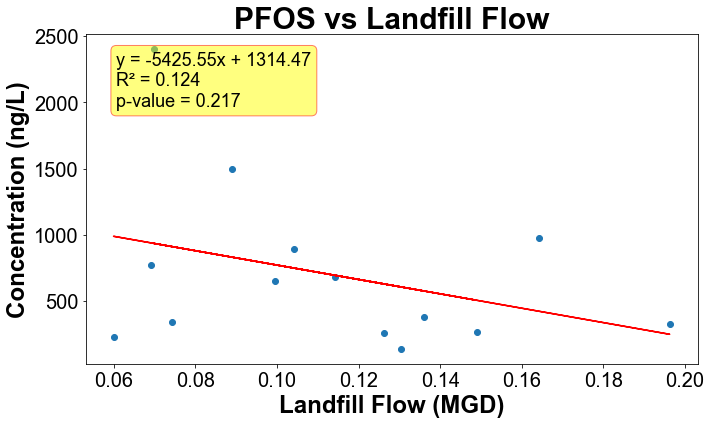

In [84]:
plot_scatter(data_df=df_Land_Other, column_x='Landfill Flow (MGD)', column_y='PFOS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

In [58]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd
import matplotlib.dates as mdates

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    x_numeric = mdates.date2num(data_df[column_x])  # Convert dates to numeric format for regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    dates_for_line = pd.date_range(start=data_df[column_x].min(), end=data_df[column_x].max(), freq='D')
    ax.plot(dates_for_line, intercept + slope * mdates.date2num(dates_for_line), 'r')

    # Setting x-axis format
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Locate ticks at the start of each year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'Year-month'

    # Adding titles and labels with custom fonts
    ax.set_title('PFOS Over Time', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Sample Date', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

In [56]:
# Read the Excel file
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Other = pd.read_excel(excel_file_path, sheet_name='Overall Landfill Conc. (WM)', usecols='A:P', skiprows=33, nrows=14)

#df_Land_Other=df_Land_Other.set_index('')

df_Land_Other=df_Land_Other[['Date',"Row Labels",'PFOA','PFOS']]

#new_index = df_Land_Other.index.tolist()  # Convert index to a list for easy manipulation
df_Land_Other['Date'][18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Other.index = new_index

df_Land_Other

Date Row Labels  PFOA  PFOS
0   2019-10 2019-10-29  1300   770
1   2020-12 2020-12-28  1600   890
2    2021-2 2021-02-16  1000   270
3    2021-5 2021-05-19  1300  1500
4    2021-8 2021-08-18  1700  2400
5   2021-10 2021-10-21   850   340
6    2022-3 2022-03-10  1400   260
7    2022-4 2022-04-13  1200   140
8    2022-9 2022-09-07  1500   680
9   2022-12 2022-12-15  1600   980
10   2023-1 2023-01-26  1400   330
11  2023-10 2023-10-19  1800   230
12   2024-3 2024-03-21  1600   380
13   2024-5 2024-05-08  2000   650

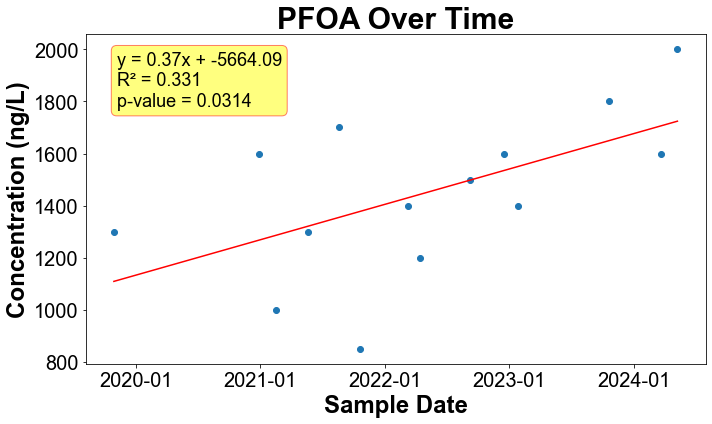

In [57]:
plot_scatter(data_df=df_Land_Other, column_x='Row Labels', column_y='PFOA', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

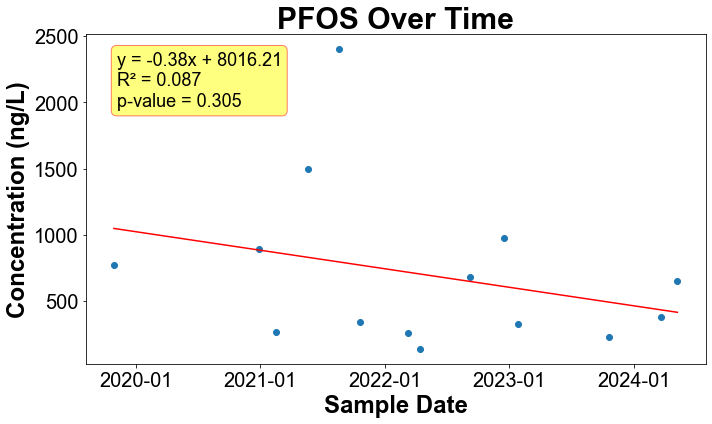

In [59]:
plot_scatter(data_df=df_Land_Other, column_x='Row Labels', column_y='PFOS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

### Landfill Comb Conc BDL

In [22]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Conc = pd.read_excel(excel_file_path, sheet_name='Landfill Comb Conc BDL', usecols='B:S', skiprows=31, nrows=21)

df_Land_Conc=df_Land_Conc.set_index('Date')
df_Land_Conc=df_Land_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
df_Land_Conc = df_Land_Conc[filtered_order]

df_Land_Conc

PFBA   PFPeA   PFHxA   PFHpA    PFOA   PFNA   PFDA  PFDoA  \
Date                                                                   
2019-8   2600.0  1700.0  5100.0   750.0  1300.0   50.0   62.0    9.1   
2019-10  3800.0  1700.0  3500.0   670.0  1300.0   88.0   61.0    NaN   
2020-12  2600.0  2200.0  4500.0   770.0  1600.0  130.0  320.0    NaN   
2021-2   2800.0  1500.0  2900.0   610.0  1000.0  100.0  180.0    NaN   
2021-5   3100.0  2200.0  3000.0   720.0  1300.0  150.0  190.0    NaN   
2021-8   7300.0  2600.0  3800.0  1100.0  1700.0  200.0  130.0    NaN   
2021-10  2500.0  1600.0  2000.0   410.0   850.0  110.0  150.0   13.0   
2022-3   4500.0  3400.0  3700.0   960.0  1400.0   96.0   79.0   12.0   
2022-4   3950.0  3900.0  4500.0   695.0  1200.0   63.0  104.0   15.0   
2022-8   3100.0  2700.0  4500.0   750.0  1400.0  100.0  140.0    NaN   
2022-9   4800.0  3600.0  4300.0   900.0  1500.0  120.0  170.0   22.0   
2022-12  3200.0  2800.0  4000.0   940.0  1600.0  140.0  220.0   18.0   
2023-1   2500.0  2500.0  4050.0   790.0  1700.0  155.0  215.0   15.0   
2023-4   2600.0  1100.0  2200.0   680.0  1400.0   73.0   37.0    2.0   
2023-9   2300.0  1200.0  2000.0   760.0  1300.0   75.0   34.0    2.0   
2023-10  4300.0  3800.0  6300.0   920.0  1800.0  300.0  400.0   54.0   
2023-12  1500.0   825.0   935.0   295.0   475.0   31.0   20.5    NaN   
2024-3   3100.0  2100.0  2600.0   600.0  1300.0  110.0   88.0    NaN   
2024-3   3200.0  2400.0  3000.0   870.0  1600.0   91.0   68.0    7.0   
2024-5   3100.0  3100.0  4200.0   770.0  2000.0  130.0  230.0   13.0   

         NEtFOSAA  NMeFOSAA    PFBS   PFPeS   PFHxS    PFOS  HFPO-DA  6:2FTS  
Date                                                                          
2019-8       42.0     190.0  5200.0   64.00   460.0   240.0    2.500   360.0  
2019-10     110.0     260.0  3500.0   77.00   580.0   770.0      NaN   630.0  
2020-12     170.0     170.0  5000.0   75.00   580.0   890.0      NaN  1000.0  
2021-2       62.0     260.0  3800.0   38.00   320.0   270.0      NaN   240.0  
2021-5      130.0     450.0  3000.0   38.00   540.0  1500.0      NaN   400.0  
2021-8      140.0     570.0  3200.0  170.00  1300.0  2400.0      NaN     NaN  
2021-10      70.0     530.0  2000.0   21.00   250.0   340.0    7.000   200.0  
2022-3       55.0     580.0  3500.0   47.00   570.0   260.0    7.000   470.0  
2022-4       37.0     115.0  4200.0   22.00   265.0   145.0    7.500   150.0  
2022-8       74.0     210.0  3400.0  190.00   840.0  1900.0      NaN   610.0  
2022-9      150.0     330.0  4300.0   86.00   580.0   680.0    3.750   690.0  
2022-12     290.0     340.0  3700.0   93.00   600.0   980.0    7.500  1000.0  
2023-1      122.0     490.0  3550.0   46.50   440.0   340.0    2.875   370.0  
2023-4      180.0     430.0   870.0  160.00   890.0  1900.0    2.000   810.0  
2023-9      200.0     740.0   930.0  120.00   810.0  1100.0   59.000   710.0  
2023-10      69.0     150.0  6600.0   27.00   400.0   230.0    3.750   250.0  
2023-12      19.5     113.0   490.0   20.00   175.0   155.0      NaN   180.0  
2024-3       51.0     190.0  1600.0   49.00   470.0   650.0      NaN   380.0  
2024-3       63.0     280.0  2100.0    3.75   530.0   380.0      NaN   350.0  
2024-5       86.0     250.0  2400.0   33.00   460.0   650.0    1.150   410.0

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

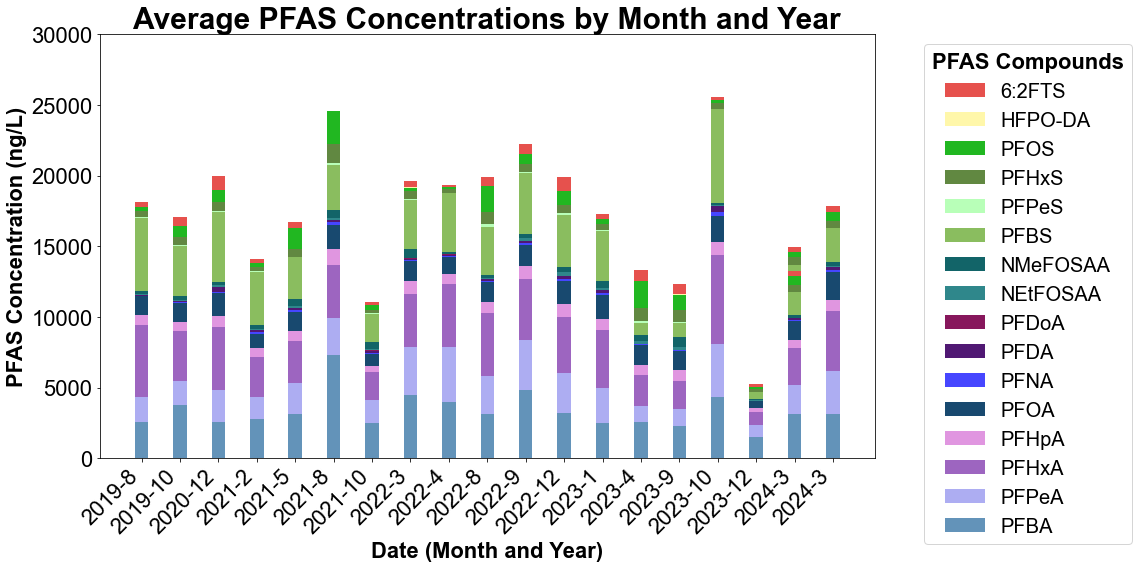

In [23]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Land_Conc, std_dev_pivot_table=None, figsize=(16, 8), title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=30000)

### Riverbend Conc BQL

In [143]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, add_data_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax1 = plt.subplots(figsize=figsize)

        # Stacked Bar Plot
        bottom = np.zeros(len(avg_pivot_table_filtered.index))
        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values)) if std_dev_pivot_table is not None else np.zeros_like(avg_values)
            ax1.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color, label=compound, yerr=std_dev_values, capsize=0)
            bottom += avg_values

        # Scatter Plot with Trendline for Total PFAS
        if 'Total PFAS' in add_data_table.columns:
            scatter_x = add_data_table.index
            scatter_y = add_data_table['Total PFAS']
            ax1.scatter(scatter_x, scatter_y, color='black', label='Total PFAS', zorder=5)

            # Calculate trendline
            slope, intercept, r_value, p_value, std_err = linregress(range(len(scatter_x)), scatter_y)
            line = slope * np.arange(len(scatter_x)) + intercept
            ax1.plot(scatter_x, line, 'r--', label=f'Trendline: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}\np-value = {p_value:.2f}')

        ax1.set_ylim(0, ylim)
        ax1.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_title(title, fontsize=title_fontsize, fontproperties=font_bold, pad=20)
        ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)
        
        # Combine legend handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()

        all_handles = handles1 
        all_labels = labels1
        
        ax1.legend(handles=all_handles, labels=all_labels, title='Legend', bbox_to_anchor=(1.05, 1.05), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


In [148]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_River_Conc = pd.read_excel(excel_file_path, sheet_name='Riverbend Conc', usecols='B:R', skiprows=33, nrows=14)
df_River_Conc=df_River_Conc.set_index('Date')

#df_River_Conc=df_River_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not alread
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_River_Conc.columns]
# Reorder columns by indexing df with the desired order
df_River_Conc = df_River_Conc[filtered_order]

df_River_Conc

PFBA  PFPeA  PFHxA  PFHpA  PFOA  PFNA  PFDA  PFDoA  NEtFOSAA  \
Date                                                                    
2019-10  2300   1900   5000    720  1500    86    70      0         0   
2020-12  2700   2200   4400    720  1600   160   300      0         0   
2021-2   2600   2100   3900    670  1400   140   280     26         0   
2021-5   2900   3300   5100    800  1900   200   360     57        56   
2021-8   3600   4200   6000    990  1900   320   290      0         0   
2021-10  4500   4600   6200   1000  2200   310   540     32        65   
2022-3   2400   3800   4200    850  1300    77   130     24        34   
2022-4   2500   3400   3900    650  1100    71   130      0         0   
2022-9   3100   4400   5500    920  1500   160   290     35        34   
2022-12  3200   3800   5900    950  2100   210   360     30        92   
2023-1   2300   3100   4400    690  1500   150   230     16        93   
2023-10  4400   3800   6200    900  1800   330   500     63        97   
2024-3   2100   2700   3600    630  1800   140   230     24        61   
2024-5   3900   4300   6200    740  2000   170   300     17        68   

         NMeFOSAA  PFBS  PFPeS  PFHxS  PFOS  HFPO-DA  6:2FTS  
Date                                                          
2019-10         0  5200     26    370   110        0     250  
2020-12         0  5300     35    290   110        0       0  
2021-2        110  4900     21    300   110        0     160  
2021-5        110  5200     37    320   150        0     210  
2021-8          0  5100     30    360   260        0       0  
2021-10       130  7100     31    380   200        0     220  
2022-3         59  6300     27    240    64        0     190  
2022-4         61  3900     18    210    54        0     140  
2022-9         65  5900     82    300   100        0     160  
2022-12       160  5800     26    330   190        0     220  
2023-1        150  4600     22    250   140        0     200  
2023-10       160  6800     29    430   240        0     200  
2024-3         94  3100      0    230   100        0     150  
2024-5        100  4800     48    330   110        0     190

In [151]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_River_Other = pd.read_excel(excel_file_path,sheet_name='Riverbend Conc', usecols='B:S', skiprows=33, nrows=14)

df_River_Other=df_River_Other.set_index('Date')

df_River_Other=df_River_Other[["Total PFAS"]]
df_River_Other

Total PFAS
Date               
2019-10       17532
2020-12       17815
2021-2        16717
2021-5        20700
2021-8        23050
2021-10       27508
2022-3        19695
2022-4        16134
2022-9        22546
2022-12       23368
2023-1        17841
2023-10       25949
2024-3        14959
2024-5        23273

<ipython-input-143-f4344ec91032>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


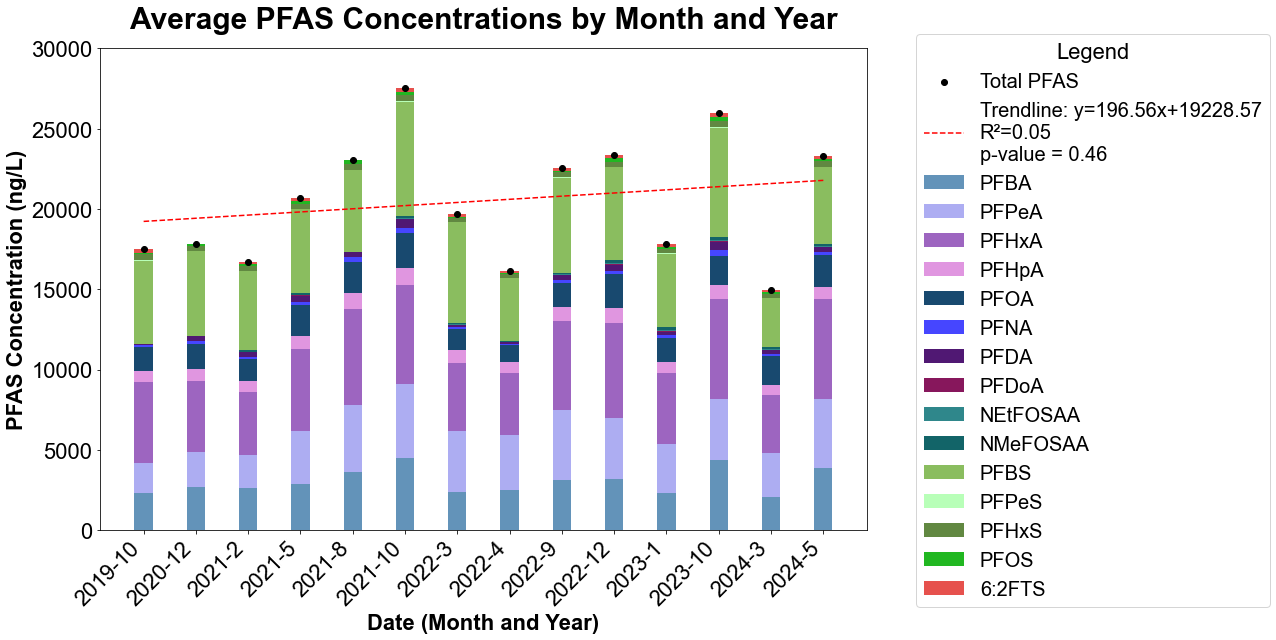

In [152]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_River_Conc, std_dev_pivot_table=None, add_data_table=df_River_Other, figsize=(18, 9),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20, ylim=30000)

#### Total Concentration vs Landfill Flow

In [71]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.4f}x + {intercept:.2f}"
    ax.plot(data_df[column_x], intercept + slope * data_df[column_x], 'r')

    # Adding titles and labels with custom fonts
    ax.set_title('PFAS Concentration in Influent vs. Fraction of Flow From Landfill', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Fraction of RC Influent Flow from Landfill (%)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Total PFAS in RC (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Adjust x-axis to show percentage
    ax.set_xticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_xticks()])

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()



In [59]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc BQL', usecols='T:V', skiprows=24, nrows=14)

df_RC

Total PFAS  Landfill Flow (MGD)  Fraction of Rock Creek Flow from Landfill
0      183.100             0.077610                                   0.002921
1      198.400             0.081621                                   0.002598
2       25.200             0.034967                                   0.001369
3      166.090             0.104075                                   0.002628
4      178.700             0.070671                                   0.002656
5      101.600             0.130448                                   0.003054
6      186.200             0.115451                                   0.004285
7      123.500             0.196257                                   0.003997
8       27.900             0.024932                                   0.000533
9       31.100             0.024932                                   0.000533
10      18.600             0.111119                                   0.002119
11      38.600             0.067547                                   0.002222
12     103.015             0.127723                                   0.002293
13      53.880             0.135961                                   0.002654

In [77]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd
from matplotlib.ticker import MaxNLocator

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.4f}x + {intercept:.2f}"
    ax.plot(data_df[column_x], intercept + slope * data_df[column_x], 'r')

    # Adding titles and labels with custom fonts
    ax.set_title('PFAS Concentration in Influent vs. Fraction of Flow From Landfill', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Fraction of RC Influent Flow from Landfill (%)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Total PFAS in RC (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Setting the x-axis to display percentages
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # This ensures integer spacing
    ax.set_xticklabels(['{:.2f}%'.format(x * 100) for x in ax.get_xticks()])

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()


<ipython-input-77-4c83894713ba>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.2f}%'.format(x * 100) for x in ax.get_xticks()])


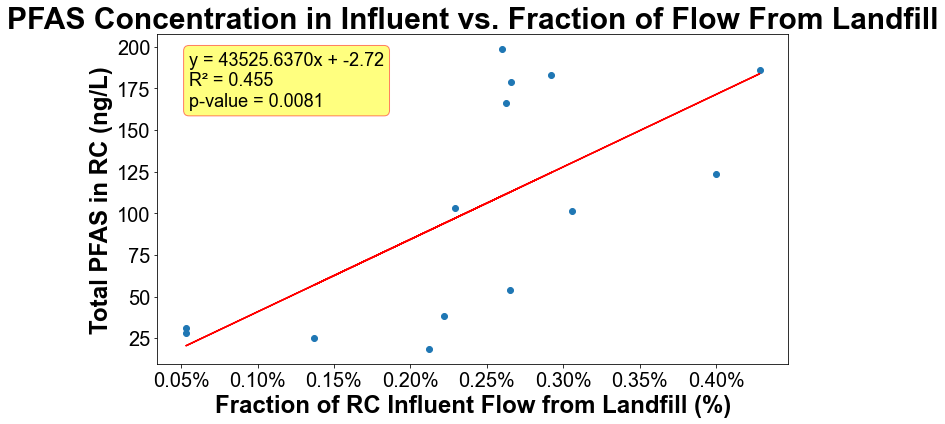

In [78]:
plot_scatter(data_df=df_RC, column_x='Fraction of Rock Creek Flow from Landfill', column_y='Total PFAS',  fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

### Riverbend Conc BDL

In [26]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_River_Conc = pd.read_excel(excel_file_path, sheet_name='Riverbend Conc BDL', usecols='B:S', skiprows=31, nrows=15)

df_River_Conc=df_River_Conc.set_index('Date')
df_River_Conc=df_River_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_River_Conc.columns]
# Reorder columns by indexing df with the desired order
df_River_Conc = df_River_Conc[filtered_order]

df_River_Conc

PFBA   PFPeA   PFHxA   PFHpA    PFOA   PFNA   PFDA  PFDoA  \
Date                                                                   
2019-10  2300.0  1900.0  5000.0   720.0  1500.0   86.0   70.0    0.0   
2020-12  2700.0  2200.0  4400.0   720.0  1600.0  160.0  300.0    0.0   
2021-2   2600.0  2100.0  3900.0   670.0  1400.0  140.0  280.0   26.0   
2021-5   2900.0  3300.0  5100.0   800.0  1900.0  200.0  360.0   57.0   
2021-8   3600.0  4200.0  6000.0   990.0  1900.0  320.0  290.0    0.0   
2021-10  4500.0  4600.0  6200.0  1000.0  2200.0  310.0  540.0   32.0   
2022-3   2400.0  3800.0  4200.0   850.0  1300.0   77.0  130.0   24.0   
2022-4   2500.0  3400.0  3900.0   650.0  1100.0   71.0  130.0    0.0   
2022-9   3100.0  4400.0  5500.0   920.0  1500.0  160.0  290.0   35.0   
2022-12  3200.0  3800.0  5900.0   950.0  2100.0  210.0  360.0   30.0   
2023-1   2300.0  3100.0  4400.0   690.0  1500.0  150.0  230.0   16.0   
2023-10  4400.0  3800.0  6200.0   900.0  1800.0  330.0  500.0   63.0   
2024-3   2100.0  2700.0  3600.0   630.0  1800.0  140.0  230.0   24.0   
2024-5   3900.0  4300.0  6200.0   740.0  2000.0  170.0  300.0   17.0   

         NEtFOSAA  NMeFOSAA    PFBS  PFPeS  PFHxS   PFOS  HFPO-DA  6:2FTS  
Date                                                                       
2019-10       0.0       0.0  5200.0  26.00  370.0  110.0     0.00   250.0  
2020-12       0.0       0.0  5300.0  35.00  290.0  110.0     0.00     0.0  
2021-2        0.0     110.0  4900.0  21.00  300.0  110.0     0.00   160.0  
2021-5       56.0     110.0  5200.0  37.00  320.0  150.0     2.00   210.0  
2021-8        0.0       0.0  5100.0  30.00  360.0  260.0     0.00     0.0  
2021-10      65.0     130.0  7100.0  31.00  380.0  200.0     8.00   220.0  
2022-3       34.0      59.0  6300.0  27.00  240.0   64.0     7.50   190.0  
2022-4        0.0      61.0  3900.0  18.00  210.0   54.0     0.00   140.0  
2022-9       34.0      65.0  5900.0  82.00  300.0  100.0     3.75   160.0  
2022-12      92.0     160.0  5800.0  26.00  330.0  190.0     7.50   220.0  
2023-1       93.0     150.0  4600.0  22.00  250.0  140.0     3.75   200.0  
2023-10      97.0     160.0  6800.0  29.00  430.0  240.0     3.75   200.0  
2024-3       61.0      94.0  3100.0   3.75  230.0  100.0     0.00   150.0  
2024-5       68.0     100.0  4800.0  48.00  330.0  110.0     1.15   190.0

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

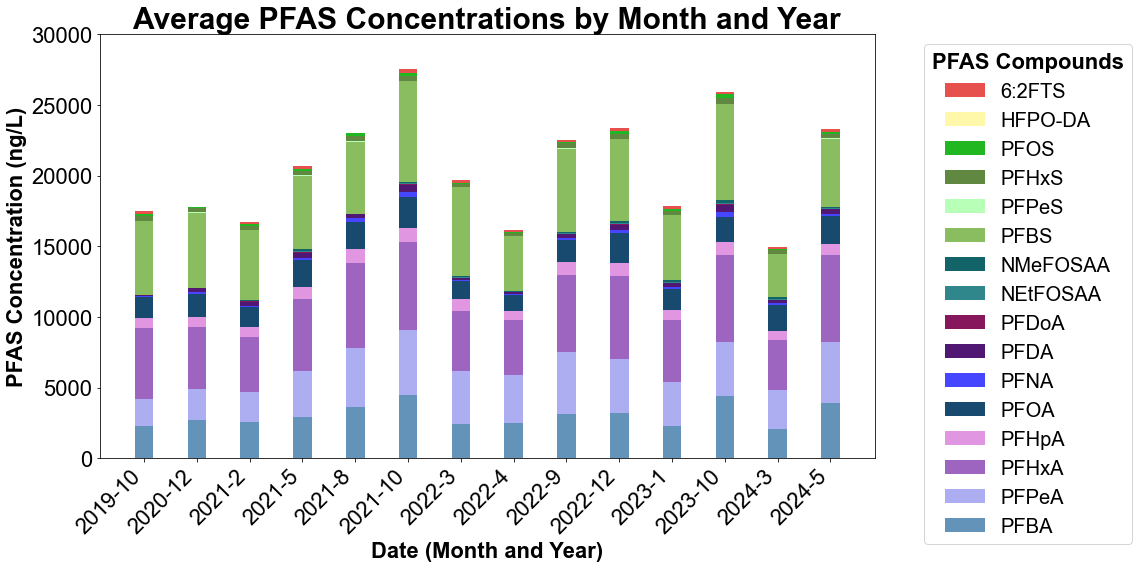

In [27]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_River_Conc, std_dev_pivot_table=None, figsize=(16, 8), title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=30000)

### HBL Conc BQL

In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, add_data_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax1 = plt.subplots(figsize=figsize)

        # Stacked Bar Plot
        bottom = np.zeros(len(avg_pivot_table_filtered.index))
        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values)) if std_dev_pivot_table is not None else np.zeros_like(avg_values)
            ax1.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color, label=compound, yerr=std_dev_values, capsize=0)
            bottom += avg_values

        # Scatter Plot with Trendline for Total PFAS
        if 'Total PFAS' in add_data_table.columns:
            scatter_x = add_data_table.index
            scatter_y = add_data_table['Total PFAS']
            ax1.scatter(scatter_x, scatter_y, color='black', label='Total PFAS', zorder=5)

            # Calculate trendline
            slope, intercept, r_value, p_value, std_err = linregress(range(len(scatter_x)), scatter_y)
            line = slope * np.arange(len(scatter_x)) + intercept
            ax1.plot(scatter_x, line, 'r--', label=f'Trendline: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}\np-value = {p_value:.2f}')

        ax1.set_ylim(0, ylim)
        ax1.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax1.set_title(title, fontsize=title_fontsize, fontproperties=font_bold, pad=20)
        ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)
        
        # Combine legend handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()

        all_handles = handles1 
        all_labels = labels1
        
        ax1.legend(handles=all_handles, labels=all_labels, title='Legend', bbox_to_anchor=(1.05, 1.05), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


In [132]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Conc = pd.read_excel(excel_file_path, sheet_name='HBL Conc', usecols='B:R', skiprows=33, nrows=17)

df_HBL_Conc=df_HBL_Conc.set_index('Date')
#df_HBL_Conc=df_HBL_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_HBL_Conc.columns]
# Reorder columns by indexing df with the desired order
df_HBL_Conc = df_HBL_Conc[filtered_order]

df_HBL_Conc

PFBA  PFPeA  PFHxA  PFHpA  PFOA  PFNA   PFDA  PFDoA  NEtFOSAA  \
Date                                                                      
2019-10   3700   1200   2500    820  1300    95   43.0      0       130   
2020-12   6800   1200   1700    640   900    76   46.0      0         0   
2021-2     300    270    290    130   230    16    9.9      0        71   
2021-5    4400   1300   2300    970  1500    88   47.0      0       260   
2021-8    7200   1300   2700    930  1700   130   33.0      0       240   
2021-10  13000   1400   2200    900  1600   130   45.0      0       100   
2022-3    5800   2600   2400   1100  1300   100   26.0      0        63   
2022-4    3600   1600   1600    570   820    91   44.0     14       240   
2022-9    5000   1700   2600    820  1300    78   75.0      9       440   
2022-12   3200   1500   2200    820  1100    80   48.0      0       490   
2023-1    2700   2400   3500    740  1500   140  180.0     11       110   
2023-6       0   1500   2200    940  1600   100   38.0      0       100   
2023-8    7000   1900   2400    930  1600   100   32.0      0       140   
2023-10   8600   1300   1600    720  1100    89   35.0      0        42   
2024-2    2700   1700   2300    620   770    56   39.0     27         0   
2024-3    3400   2000   2200    890  1600    97   35.0      0        56   
2024-5    4100   1300   1600    710  1100    78   29.0      0        59   

         NMeFOSAA  PFBS  PFPeS  PFHxS  PFOS  HFPO-DA  6:2FTS  
Date                                                          
2019-10       510  1500     79   1000  1500        0    1200  
2020-12       530   640     44    540   660        0     290  
2021-2        120   180     28    180   390        0      77  
2021-5        930  1700    350   2100  6400        0    1500  
2021-8        790  1400    300   1700  5000        0       0  
2021-10      1100   940     67    850   680        0     590  
2022-3        790  1300     58    700   370        0     640  
2022-4        530   680     45    450  2900        0     300  
2022-9        590  1300    170    890  1600        0    1100  
2022-12       580   950    170    890  2100        0    1700  
2023-1        480  3000     41    440   630        0     350  
2023-6        490  1400    140   1100  3300        0     760  
2023-8        600  1100    200   1000  1300        0    1200  
2023-10       580   710     44    650   340        0     380  
2024-2        220   630      0    300   150        0     200  
2024-3        700  1000      0    790   320        0     540  
2024-5        500   880     35    540   410        0     550

In [135]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Conc_Other = pd.read_excel(excel_file_path, sheet_name='HBL Conc', usecols='B:S', skiprows=33, nrows=17)

df_HBL_Conc_Other=df_HBL_Conc_Other.set_index('Date')

df_HBL_Conc_Other=df_HBL_Conc_Other[["Total PFAS"]]
df_HBL_Conc_Other

Total PFAS
Date               
2019-10     15577.0
2020-12     14066.0
2021-2       2291.9
2021-5      23845.0
2021-8      23423.0
2021-10     23602.0
2022-3      17247.0
2022-4      13484.0
2022-9      17672.0
2022-12     15828.0
2023-1      16222.0
2023-6      13668.0
2023-8      19502.0
2023-10     16190.0
2024-2       9712.0
2024-3      13628.0
2024-5      11891.0

<ipython-input-139-f4344ec91032>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_pivot_table_filtered.index, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


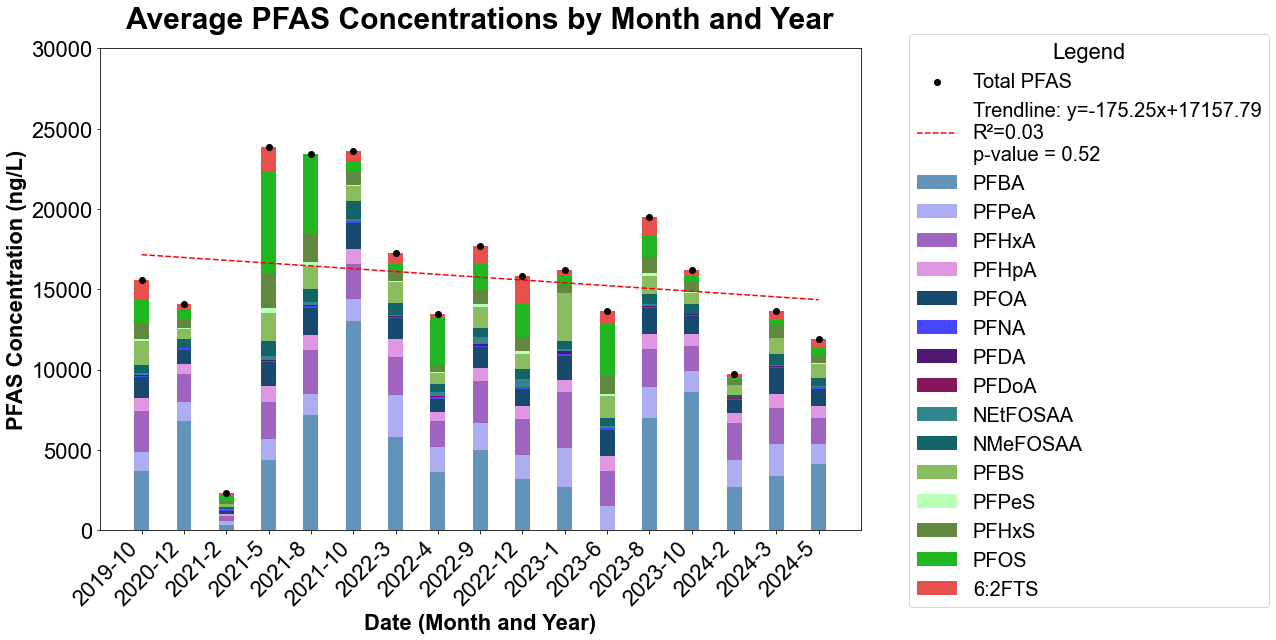

In [141]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_HBL_Conc, std_dev_pivot_table=None, add_data_table=df_HBL_Conc_Other, figsize=(18, 9),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20, ylim=30000)

### HBL Conc BQL

In [30]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Conc = pd.read_excel(excel_file_path, sheet_name='HBL Conc BDL', usecols='B:S', skiprows=31, nrows=18)

df_HBL_Conc=df_HBL_Conc.set_index('Date')
df_HBL_Conc=df_HBL_Conc.iloc[:-1, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_HBL_Conc.columns]
# Reorder columns by indexing df with the desired order
df_HBL_Conc = df_HBL_Conc[filtered_order]

df_HBL_Conc

PFBA   PFPeA   PFHxA   PFHpA    PFOA   PFNA   PFDA  PFDoA  \
Date                                                                    
2019-10   3700.0  1200.0  2500.0   820.0  1300.0   95.0   43.0   0.00   
2020-12   6800.0  1200.0  1700.0   640.0   900.0   76.0   46.0   0.00   
2021-2     300.0   270.0   290.0   130.0   230.0   16.0    9.9   2.40   
2021-5    4400.0  1300.0  2300.0   970.0  1500.0   88.0   47.0   0.00   
2021-8    7200.0  1300.0  2700.0   930.0  1700.0  130.0   33.0   0.00   
2021-10  13000.0  1400.0  2200.0   900.0  1600.0  130.0   45.0   2.65   
2022-3    5800.0  2600.0  2400.0  1100.0  1300.0  100.0   26.0   2.60   
2022-4    3600.0  1600.0  1600.0   570.0   820.0   91.0   44.0  14.00   
2022-9    5000.0  1700.0  2600.0   820.0  1300.0   78.0   75.0   9.00   
2022-12   3200.0  1500.0  2200.0   820.0  1100.0   80.0   48.0   2.75   
2023-1    2700.0  2400.0  3500.0   740.0  1500.0  140.0  180.0  11.00   
2023-6       0.0  1500.0  2200.0   940.0  1600.0  100.0   38.0   0.00   
2023-8    7000.0  1900.0  2400.0   930.0  1600.0  100.0   32.0   1.00   
2023-10   8600.0  1300.0  1600.0   720.0  1100.0   89.0   35.0   1.40   
2024-2    2700.0  1700.0  2300.0   620.0   770.0   56.0   39.0  27.00   
2024-3    3400.0  2000.0  2200.0   890.0  1600.0   97.0   35.0   7.00   
2024-5    4100.0  1300.0  1600.0   710.0  1100.0   78.0   29.0   1.00   

         NEtFOSAA  NMeFOSAA    PFBS   PFPeS   PFHxS    PFOS  HFPO-DA  6:2FTS  
Date                                                                          
2019-10     130.0     510.0  1500.0   79.00  1000.0  1500.0     0.00  1200.0  
2020-12       0.0     530.0   640.0   44.00   540.0   660.0     0.00   290.0  
2021-2       71.0     120.0   180.0   28.00   180.0   390.0     6.50    77.0  
2021-5      260.0     930.0  1700.0  350.00  2100.0  6400.0     0.00  1500.0  
2021-8      240.0     790.0  1400.0  300.00  1700.0  5000.0     0.00     0.0  
2021-10     100.0    1100.0   940.0   67.00   850.0   680.0     7.00   590.0  
2022-3       63.0     790.0  1300.0   58.00   700.0   370.0     7.00   640.0  
2022-4      240.0     530.0   680.0   45.00   450.0  2900.0     6.50   300.0  
2022-9      440.0     590.0  1300.0  170.00   890.0  1600.0     3.75  1100.0  
2022-12     490.0     580.0   950.0  170.00   890.0  2100.0     7.50  1700.0  
2023-1      110.0     480.0  3000.0   41.00   440.0   630.0     3.75   350.0  
2023-6      100.0     490.0  1400.0  140.00  1100.0  3300.0     0.00   760.0  
2023-8      140.0     600.0  1100.0  200.00  1000.0  1300.0     2.00  1200.0  
2023-10      42.0     580.0   710.0   44.00   650.0   340.0     3.75   380.0  
2024-2        0.0     220.0   630.0    7.00   300.0   150.0     0.00   200.0  
2024-3       56.0     700.0  1000.0    3.75   790.0   320.0     0.00   540.0  
2024-5       59.0     500.0   880.0   35.00   540.0   410.0     1.15   550.0

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

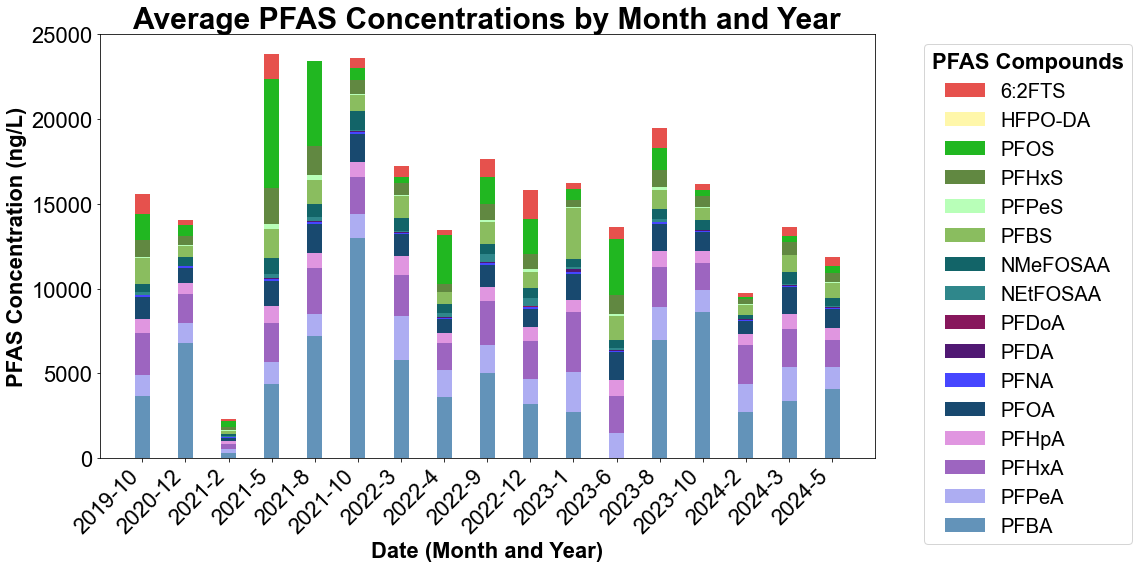

In [31]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_HBL_Conc, std_dev_pivot_table=None, figsize=(16, 8), title='Average PFAS Concentrations by Month and Year', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=25000)

### Rock Creek Mass BQL

In [8]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        if std_dev_pivot_table is not None and not std_dev_pivot_table.empty:
            std_dev_pivot_table_filtered = std_dev_pivot_table.fillna(0)[avg_pivot_table_filtered.columns]
        else:
            std_dev_pivot_table_filtered = pd.DataFrame(columns=avg_pivot_table_filtered.columns, index=avg_pivot_table_filtered.index)
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values))
            
            bars = ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                          label=compound, yerr=std_dev_values, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_xlabel('Operating Status', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_ylabel('PFAS Mass (mg/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)

        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2, ncol=1)
        legend.get_title().set_fontweight('bold')  # Set the legend title to bold

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")



In [29]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Mass = pd.read_excel(excel_file_path, sheet_name='Rock Creek Mass BQL', usecols='C:S', skiprows=18, nrows=4)

df_RC_Mass=df_RC_Mass.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Mass.columns]
# Reorder columns by indexing df with the desired order
df_RC_Mass = df_RC_Mass[filtered_order]

df_RC_Mass

PFBA        PFPeA        PFHxA  \
Unnamed: 2                                                                      
Overall                                 3791.266781  2260.404058  3203.873090   
Landfill Discharging Normally           4071.888029  2778.866244  3612.752654   
Landfill Not Discharging                        NaN  1143.984320  1159.475274   
Landfill Discharging Without Riverbend  1265.675557   943.503597          NaN   

                                             PFHpA         PFOA        PFNA  \
Unnamed: 2                                                                    
Overall                                 866.779135  1547.847009  303.641443   
Landfill Discharging Normally           960.758081  1729.841404  303.641443   
Landfill Not Discharging                531.057378  1032.017230         NaN   
Landfill Discharging Without Riverbend  356.690384   425.727233         NaN   

                                              PFDA        PFDoA   NEtFOSAA  \
Unnamed: 2                                                                   
Overall                                 322.212955  1307.379718  87.037863   
Landfill Discharging Normally           322.212955  1307.379718  87.037863   
Landfill Not Discharging                       NaN          NaN        NaN   
Landfill Discharging Without Riverbend         NaN          NaN        NaN   

                                          NMeFOSAA         PFBS       PFPeS  \
Unnamed: 2                                                                    
Overall                                 186.836868  2429.964480  507.598589   
Landfill Discharging Normally           186.836868  2995.675850  507.598589   
Landfill Not Discharging                       NaN  1005.228449         NaN   
Landfill Discharging Without Riverbend         NaN  1047.058870         NaN   

                                             PFHxS         PFOS    HFPO-DA  \
Unnamed: 2                                                                   
Overall                                 594.876302  1429.473039  79.465921   
Landfill Discharging Normally           626.000246  1450.134959  79.465921   
Landfill Not Discharging                566.461203  1336.494400        NaN   
Landfill Discharging Without Riverbend  402.714950          NaN        NaN   

                                            6:2FTS  
Unnamed: 2                                          
Overall                                 301.459204  
Landfill Discharging Normally           301.459204  
Landfill Not Discharging                       NaN  
Landfill Discharging Without Riverbend         NaN

In [30]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Mass_Error = pd.read_excel(excel_file_path, sheet_name='Rock Creek Mass BQL', usecols='C:S', skiprows=39, nrows=4)


df_RC_Mass_Error=df_RC_Mass_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Mass_Error.columns]
# Reorder columns by indexing df with the desired order
df_RC_Mass_Error = df_RC_Mass_Error[filtered_order]

df_RC_Mass_Error

PFBA       PFPeA       PFHxA  \
Unnamed: 2                                                                   
Overall                                 580.982708  256.879800  508.545190   
Landfill Discharging Normally           568.762498  181.351961  517.542239   
Landfill Not Discharging                       NaN   74.610559    8.850956   
Landfill Discharging Without Riverbend         NaN         NaN         NaN   

                                            PFHpA        PFOA       PFNA  \
Unnamed: 2                                                                 
Overall                                 90.014057  190.804457  30.587473   
Landfill Discharging Normally           78.074958  174.059644  30.587473   
Landfill Not Discharging                      NaN         NaN        NaN   
Landfill Discharging Without Riverbend        NaN         NaN        NaN   

                                             PFDA  PFDoA  NEtFOSAA   NMeFOSAA  \
Unnamed: 2                                                                      
Overall                                 64.130292    NaN  16.41777  38.962127   
Landfill Discharging Normally           64.130292    NaN  16.41777  38.962127   
Landfill Not Discharging                      NaN    NaN       NaN        NaN   
Landfill Discharging Without Riverbend        NaN    NaN       NaN        NaN   

                                              PFBS      PFPeS      PFHxS  \
Unnamed: 2                                                                 
Overall                                 409.691790  299.79548  60.865875   
Landfill Discharging Normally           461.224585  299.79548  79.684776   
Landfill Not Discharging                182.733712        NaN  53.105738   
Landfill Discharging Without Riverbend         NaN        NaN        NaN   

                                              PFOS  HFPO-DA     6:2FTS  
Unnamed: 2                                                              
Overall                                 153.685224      NaN  78.444712  
Landfill Discharging Normally           189.134135      NaN  78.444712  
Landfill Not Discharging                 26.552869      NaN        NaN  
Landfill Discharging Without Riverbend         NaN      NaN        NaN

In [9]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for i, compound in enumerate(avg_pivot_table_filtered.columns):
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            if std_dev_pivot_table is not None:
                std_dev_values = std_dev_pivot_table.get(compound)
                # Only use std_dev_values where they are not NaN
                error_bars = std_dev_values.where(std_dev_values.notna(), None).values
            else:
                error_bars = None
            
            ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                   label=compound, yerr=error_bars if error_bars is not None else None, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_ylabel('PFAS Mass (mg/day)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)


        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()  # Optional: reverse the order of legend items
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        legend.get_title().set_fontweight('bold')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

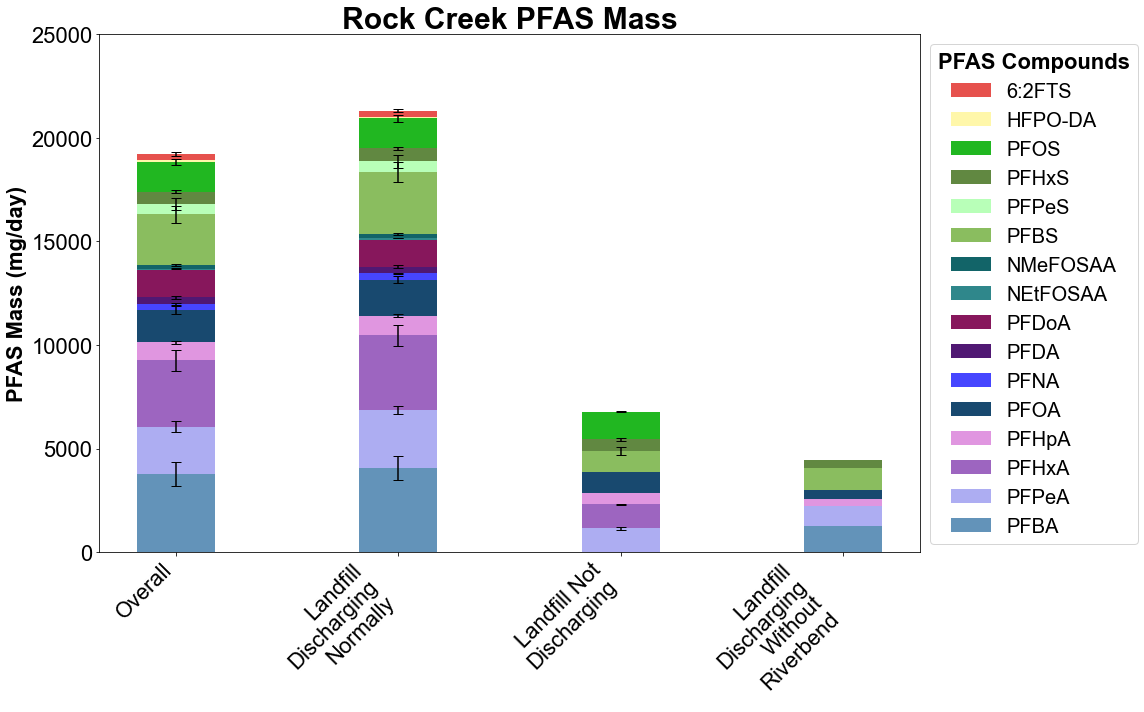

In [32]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Mass, std_dev_pivot_table=df_RC_Mass_Error, figsize=(16, 10), title='Rock Creek PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=25000)

#### Mass using Average Flow

In [10]:
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Mass = pd.read_excel(excel_file_path, sheet_name='Rock Creek Mass-AvgFlow', usecols='C:S', skiprows=20, nrows=4)

df_RC_Mass=df_RC_Mass.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Mass.columns]
# Reorder columns by indexing df with the desired order
df_RC_Mass = df_RC_Mass[filtered_order]

new_order = ['Overall', 'Landfill Discharging Normally','Landfill Discharging Without Riverbend','Landfill Not Discharging']

# Reordering the DataFrame
df_RC_Mass = df_RC_Mass.reindex(new_order)

df_RC_Mass

PFBA        PFPeA        PFHxA  \
Unnamed: 2                                                                      
Overall                                 4317.454322  2447.804495  3512.096424   
Landfill Discharging Normally           4614.832540  3091.473666  4019.081529   
Landfill Discharging Without Riverbend  1641.050364  1223.328454          NaN   
Landfill Not Discharging                        NaN   924.955660   977.170899   

                                              PFHpA         PFOA        PFNA  \
Unnamed: 2                                                                     
Overall                                  941.230540  1609.856845  304.340249   
Landfill Discharging Normally           1049.277657  1820.074041  304.340249   
Landfill Discharging Without Riverbend   462.477830   551.989668         NaN   
Landfill Not Discharging                 447.559190   775.769263         NaN   

                                              PFDA        PFDoA   NEtFOSAA  \
Unnamed: 2                                                                   
Overall                                 312.694688  1939.423158  76.458028   
Landfill Discharging Normally           312.694688  1939.423158  76.458028   
Landfill Discharging Without Riverbend         NaN          NaN        NaN   
Landfill Not Discharging                       NaN          NaN        NaN   

                                          NMeFOSAA         PFBS       PFPeS  \
Unnamed: 2                                                                    
Overall                                 175.294016  2692.814462  392.857511   
Landfill Discharging Normally           175.294016  3392.498663  392.857511   
Landfill Discharging Without Riverbend         NaN  1357.596211         NaN   
Landfill Not Discharging                       NaN   805.606543         NaN   

                                             PFHxS         PFOS   HFPO-DA  \
Unnamed: 2                                                                  
Overall                                 633.364066  1470.842248  79.06879   
Landfill Discharging Normally           686.257425  1547.394460  79.06879   
Landfill Discharging Without Riverbend  522.152389          NaN       NaN   
Landfill Not Discharging                477.396470  1126.357296       NaN   

                                            6:2FTS  
Unnamed: 2                                          
Overall                                 343.128713  
Landfill Discharging Normally           343.128713  
Landfill Discharging Without Riverbend         NaN  
Landfill Not Discharging                       NaN

In [11]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Mass_Error = pd.read_excel(excel_file_path, sheet_name='Rock Creek Mass-AvgFlow', usecols='C:S', skiprows=35, nrows=4)


df_RC_Mass_Error=df_RC_Mass_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Mass_Error.columns]
# Reorder columns by indexing df with the desired order
df_RC_Mass_Error = df_RC_Mass_Error[filtered_order]

new_order = ['Overall', 'Landfill Discharging Normally','Landfill Discharging Without Riverbend','Landfill Not Discharging']

# Reordering the DataFrame
df_RC_Mass_Error = df_RC_Mass_Error.reindex(new_order)

df_RC_Mass_Error

PFBA       PFPeA       PFHxA  \
Unnamed: 2                                                                   
Overall                                 828.581480  379.508994  608.794667   
Landfill Discharging Normally           864.662843  377.838892  610.110553   
Landfill Discharging Without Riverbend         NaN         NaN         NaN   
Landfill Not Discharging                       NaN   25.839842    7.459320   

                                             PFHpA        PFOA       PFNA  \
Unnamed: 2                                                                  
Overall                                 122.204672  200.149041  65.642015   
Landfill Discharging Normally           121.606996  174.565085  65.642015   
Landfill Discharging Without Riverbend         NaN         NaN        NaN   
Landfill Not Discharging                       NaN         NaN        NaN   

                                             PFDA  PFDoA   NEtFOSAA  \
Unnamed: 2                                                            
Overall                                 67.943881    NaN  26.480585   
Landfill Discharging Normally           67.943881    NaN  26.480585   
Landfill Discharging Without Riverbend        NaN    NaN        NaN   
Landfill Not Discharging                      NaN    NaN        NaN   

                                         NMeFOSAA        PFBS       PFPeS  \
Unnamed: 2                                                                  
Overall                                 12.739214  520.526254  196.228479   
Landfill Discharging Normally           12.739214  595.103105  196.228479   
Landfill Discharging Without Riverbend        NaN         NaN         NaN   
Landfill Not Discharging                      NaN  112.633260         NaN   

                                             PFHxS        PFOS  HFPO-DA  \
Unnamed: 2                                                                
Overall                                 108.858008  136.319659      NaN   
Landfill Discharging Normally           147.363713  156.038277      NaN   
Landfill Discharging Without Riverbend         NaN         NaN      NaN   
Landfill Not Discharging                 44.755919   22.377960      NaN   

                                          6:2FTS  
Unnamed: 2                                        
Overall                                 124.2225  
Landfill Discharging Normally           124.2225  
Landfill Discharging Without Riverbend       NaN  
Landfill Not Discharging                     NaN

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

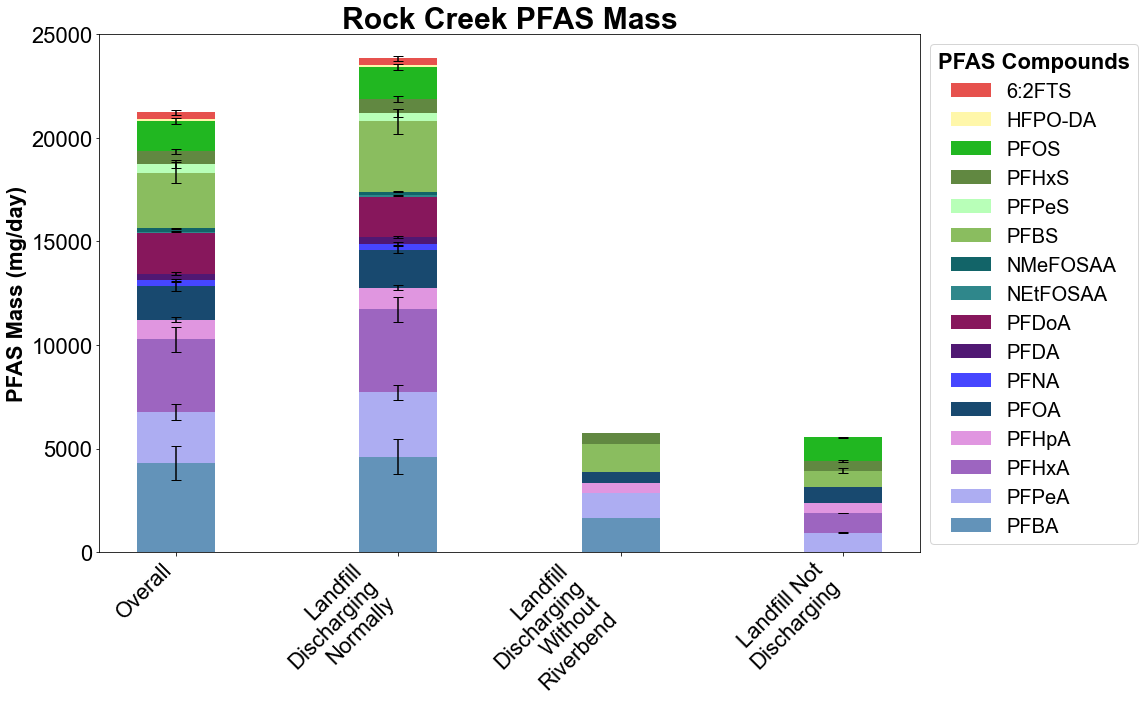

In [12]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Mass, std_dev_pivot_table=df_RC_Mass_Error, figsize=(16, 10), title='Rock Creek PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=25000)

### Rock Creek Mass BDL

In [36]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Mass = pd.read_excel(excel_file_path, sheet_name='Rock Creek Mass BDL', usecols='C:S', skiprows=18, nrows=6)

df_RC_Mass=df_RC_Mass.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Mass.columns]
# Reorder columns by indexing df with the desired order
df_RC_Mass = df_RC_Mass[filtered_order]

df_RC_Mass

PFBA        PFPeA        PFHxA  \
Unnamed: 2                                                                      
Overall                                 3045.287751  2116.551114  2851.062571   
Landfill Discharging Normally           3761.351318  2525.625903  3612.752654   
Landfill Not Discharging                1251.613259  1143.984320  1070.680794   
Landfill Discharging Without Riverbend  1265.675557   943.503597   575.307071   
Intel Treatment Off                     4938.762789  3031.640270  4280.493902   
Intel Treatment On                      2437.849799  1955.064549  2614.176962   

                                              PFHpA         PFOA        PFNA  \
Unnamed: 2                                                                     
Overall                                  753.051724  1271.702665  265.704922   
Landfill Discharging Normally            889.328556  1581.503548  275.460711   
Landfill Not Discharging                 430.916065   521.024869  283.400127   
Landfill Discharging Without Riverbend   356.690384   425.727233  115.061414   
Intel Treatment Off                     1155.058649  1551.930352  360.944647   
Intel Treatment On                       684.908851  1276.935696  252.362281   

                                              PFDA       PFDoA    NEtFOSAA  \
Unnamed: 2                                                                   
Overall                                 295.729883  310.382133  252.762553   
Landfill Discharging Normally           294.040673  291.098840  186.976445   
Landfill Not Discharging                342.406502  401.412878  460.419253   
Landfill Discharging Without Riverbend  172.592121  230.122828  287.653536   
Intel Treatment Off                     380.783440  670.557625   66.058710   
Intel Treatment On                      281.578512  235.285868  266.667284   

                                          NMeFOSAA         PFBS       PFPeS  \
Unnamed: 2                                                                    
Overall                                 289.842282  2429.964480  295.696618   
Landfill Discharging Normally           252.419806  2995.675850  293.994102   
Landfill Not Discharging                434.490353  1005.228449  342.406502   
Landfill Discharging Without Riverbend  230.122828  1047.058870  172.592121   
Intel Treatment Off                     145.273639  3907.486262   87.049708   
Intel Treatment On                      305.640121  2076.947645  340.278687   

                                             PFHxS         PFOS     HFPO-DA  \
Unnamed: 2                                                                    
Overall                                 541.685854  1216.994054  313.685491   
Landfill Discharging Normally           555.180248  1308.495016  238.598644   
Landfill Not Discharging                543.028178  1221.771020  566.800254   
Landfill Discharging Without Riverbend  402.714950   287.653536  230.122828   
Intel Treatment Off                     402.999053   323.599162   54.063854   
Intel Treatment On                      586.069924  1341.568594  368.711973   

                                            6:2FTS  
Unnamed: 2                                          
Overall                                 750.543281  
Landfill Discharging Normally           870.418912  
Landfill Not Discharging                442.547815  
Landfill Discharging Without Riverbend  287.653536  
Intel Treatment Off                     378.406619  
Intel Treatment On                      827.225954

In [37]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Mass_Error = pd.read_excel(excel_file_path, sheet_name='Rock Creek Mass BDL', usecols='C:S', skiprows=39, nrows=6)


df_RC_Mass_Error=df_RC_Mass_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Mass_Error.columns]
# Reorder columns by indexing df with the desired order
df_RC_Mass_Error = df_RC_Mass_Error[filtered_order]

df_RC_Mass_Error

PFBA       PFPeA        PFHxA  \
Unnamed: 2                                                                    
Overall                                 527.916368  277.946315   495.274480   
Landfill Discharging Normally           596.008114  300.734929   517.542239   
Landfill Not Discharging                366.517630   74.610559    88.941401   
Landfill Discharging Without Riverbend         NaN         NaN          NaN   
Intel Treatment Off                     290.756082  416.880835  1866.869808   
Intel Treatment On                      411.575104  331.553426   565.407543   

                                             PFHpA        PFOA        PFNA  \
Unnamed: 2                                                                   
Overall                                  93.581215  208.598134   26.258897   
Landfill Discharging Normally            99.893625  215.038432   19.150953   
Landfill Not Discharging                 83.304978  255.496180  106.381001   
Landfill Discharging Without Riverbend         NaN         NaN         NaN   
Intel Treatment Off                     149.381943  697.105152    1.098967   
Intel Treatment On                       94.792921  249.955962   32.779517   

                                             PFDA       PFDoA   NEtFOSAA  \
Unnamed: 2                                                                 
Overall                                 28.634912   85.634055  43.799610   
Landfill Discharging Normally           31.979791  119.543339  43.890535   
Landfill Not Discharging                76.877814   47.374626  17.871438   
Landfill Discharging Without Riverbend        NaN         NaN        NaN   
Intel Treatment Off                     69.023661  636.822092  37.396924   
Intel Treatment On                      36.865872   47.799675  51.283239   

                                         NMeFOSAA        PFBS      PFPeS  \
Unnamed: 2                                                                 
Overall                                 33.009581  409.691790  68.928222   
Landfill Discharging Normally           29.653150  461.224585  94.722392   
Landfill Not Discharging                80.452101  182.733712  76.877814   
Landfill Discharging Without Riverbend        NaN         NaN        NaN   
Intel Treatment Off                     34.649201  890.456145  58.387922   
Intel Treatment On                      39.862390  419.054944  91.288700   

                                             PFHxS        PFOS     HFPO-DA  \
Unnamed: 2                                                                   
Overall                                  56.818999  172.393905   66.992690   
Landfill Discharging Normally            78.704381  220.633746   49.805024   
Landfill Not Discharging                 38.589892  115.743130  212.762003   
Landfill Discharging Without Riverbend         NaN         NaN         NaN   
Intel Treatment Off                     181.750178  289.863629   25.402068   
Intel Treatment On                       66.463297  190.904540   86.191572   

                                            6:2FTS  
Unnamed: 2                                          
Overall                                 225.604622  
Landfill Discharging Normally           293.095120  
Landfill Not Discharging                  0.000000  
Landfill Discharging Without Riverbend         NaN  
Intel Treatment Off                      26.419772  
Intel Treatment On                      330.195840

<ipython-input-32-08a0db050f9e>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


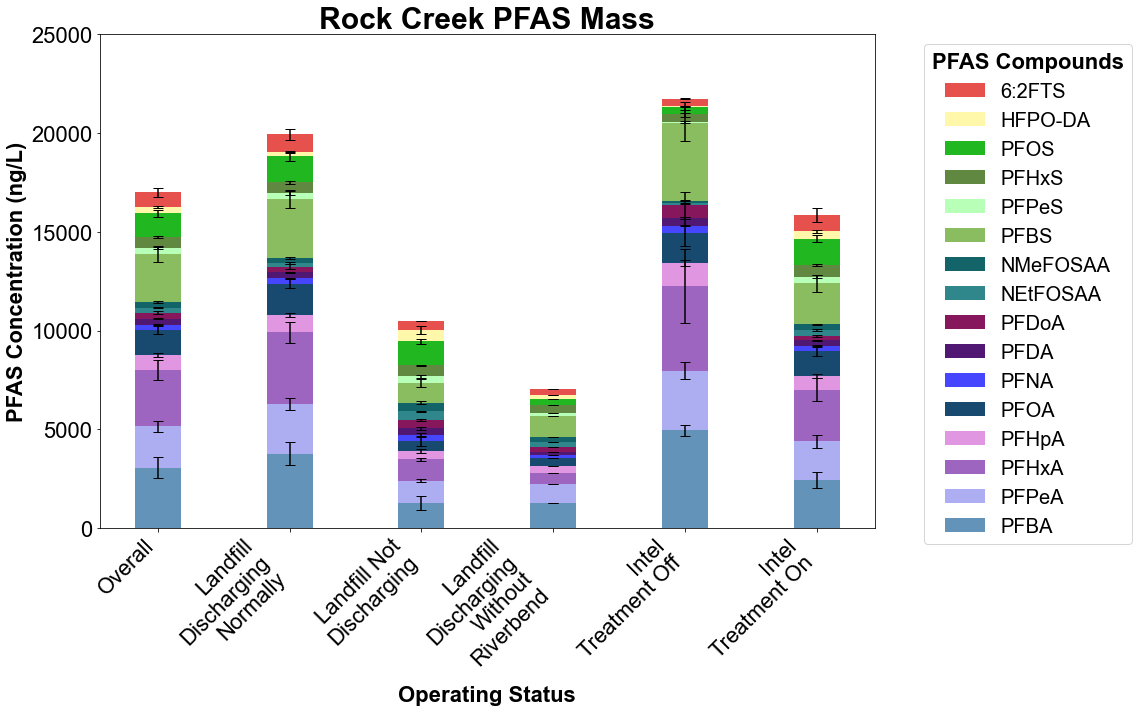

In [38]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Mass, std_dev_pivot_table=df_RC_Mass_Error, figsize=(16, 10), title='Rock Creek PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=25000)

### Landill Comb Mass BQL

In [26]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Mass = pd.read_excel(excel_file_path, sheet_name='Landill Comb Mass BQL', usecols='C:S', skiprows=25, nrows=3)

df_Land_Mass=df_Land_Mass.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Mass.columns]
# Reorder columns by indexing df with the desired order
df_Land_Mass = df_Land_Mass[filtered_order]

df_Land_Mass

PFBA        PFPeA        PFHxA       PFHpA  \
Unnamed: 2                                                                      
Landfill Overall            1360.227636   996.583943  1474.501214  312.954604   
Landfill without Riverbend   840.849548   384.754758   718.371978  240.172829   
Landfill With Riverbend     1417.936313  1064.564964  1558.515574  321.041468   

                                  PFOA       PFNA       PFDA    PFDoA  \
Unnamed: 2                                                              
Landfill Overall            581.304540  46.980743  60.713135  7.60586   
Landfill without Riverbend  460.632455  24.940994  12.128199      NaN   
Landfill With Riverbend     594.712550  49.429604  66.111461  7.60586   

                             NEtFOSAA    NMeFOSAA         PFBS      PFPeS  \
Unnamed: 2                                                                  
Landfill Overall            44.954305  136.345737  1307.344903  28.990835   
Landfill without Riverbend  63.424756  185.038192   301.865380  48.991028   
Landfill With Riverbend     42.902032  130.935465  1419.064850  26.637871   

                                 PFHxS        PFOS    HFPO-DA      6:2FTS  
Unnamed: 2                                                                 
Landfill Overall            222.840879  308.696149  15.085573  207.726921  
Landfill without Riverbend  290.730340  540.219207  15.085573  261.121072  
Landfill With Riverbend     215.297606  282.971365        NaN  201.445256

In [27]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Mass_Error = pd.read_excel(excel_file_path, sheet_name='Landill Comb Mass BQL', usecols='C:S', skiprows=37, nrows=3)


df_Land_Mass_Error=df_Land_Mass_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Mass_Error.columns]
# Reorder columns by indexing df with the desired order
df_Land_Mass_Error = df_Land_Mass_Error[filtered_order]

df_Land_Mass_Error

PFBA       PFPeA       PFHxA      PFHpA  \
Unnamed: 2                                                                  
Landfill Overall            114.933846  116.723462  148.828331  29.157453   
Landfill without Riverbend  252.767871   77.929535  206.996607  45.850188   
Landfill With Riverbend     118.438701  118.999887  151.902337  31.678722   

                                  PFOA      PFNA       PFDA     PFDoA  \
Unnamed: 2                                                              
Landfill Overall             56.556767  5.419832   9.859897  1.186205   
Landfill without Riverbend  128.238463  5.764418   3.434818       NaN   
Landfill With Riverbend      61.310422  5.721316  10.173902  1.186205   

                             NEtFOSAA   NMeFOSAA        PFBS      PFPeS  \
Unnamed: 2                                                                
Landfill Overall             8.641113  18.314588  159.453941   4.885154   
Landfill without Riverbend  12.287219   4.170696   64.075833  18.308506   
Landfill With Riverbend      9.447840  19.980186  155.580913   4.924877   

                                PFHxS        PFOS  HFPO-DA     6:2FTS  
Unnamed: 2                                                             
Landfill Overall            22.057659   54.274425      NaN  31.776168  
Landfill without Riverbend  83.623315  258.962753      NaN  79.582816  
Landfill With Riverbend     22.913409   53.202351      NaN  34.634985

<ipython-input-22-d328287f71ca>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


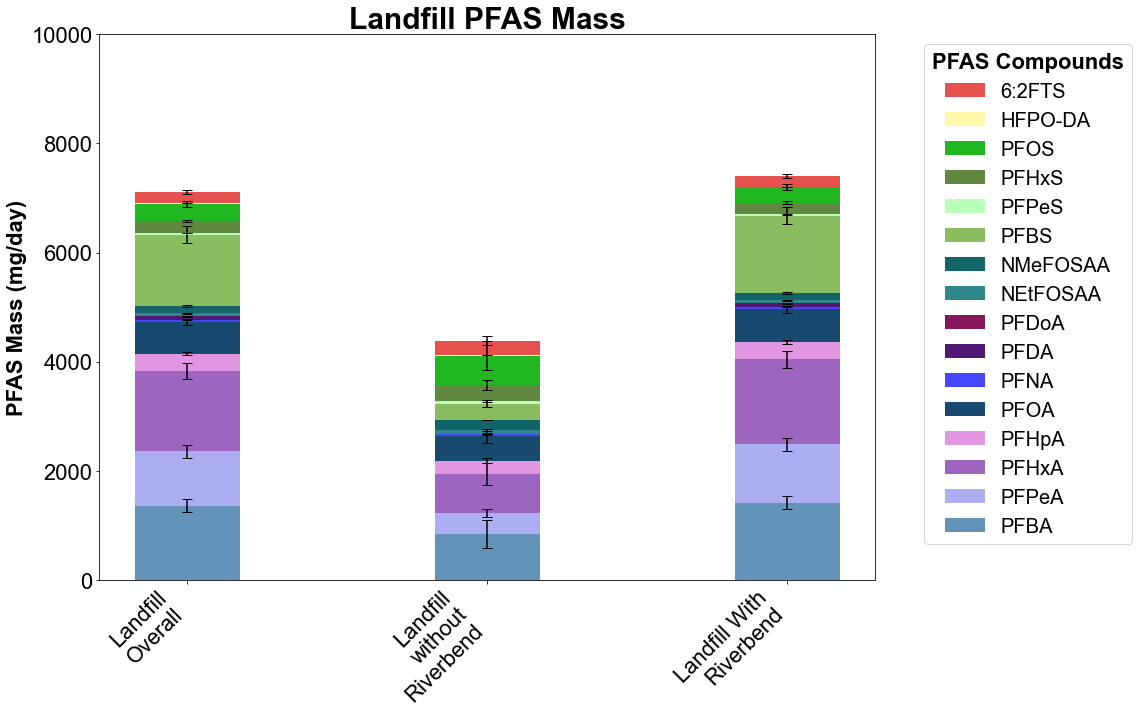

In [28]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Land_Mass, std_dev_pivot_table=df_Land_Mass_Error, figsize=(16, 10), title='Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=10000)

### Landill Comb Mass BDL

In [44]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Mass = pd.read_excel(excel_file_path, sheet_name='Landill Comb Mass BDL', usecols='C:S', skiprows=25, nrows=3)

df_Land_Mass=df_Land_Mass.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Mass.columns]
# Reorder columns by indexing df with the desired order
df_Land_Mass = df_Land_Mass[filtered_order]

df_Land_Mass

PFBA        PFPeA        PFHxA       PFHpA  \
Unnamed: 2                                                                      
Landfill Overall            1360.227636   996.583943  1474.501214  312.954604   
Landfill without Riverbend   840.849548   384.754758   718.371978  240.172829   
Landfill With Riverbend     1417.936313  1064.564964  1558.515574  321.041468   

                                  PFOA       PFNA       PFDA     PFDoA  \
Unnamed: 2                                                               
Landfill Overall            581.304540  46.980743  60.713135  6.117330   
Landfill without Riverbend  460.632455  24.940994  12.128199  0.676310   
Landfill With Riverbend     594.712550  49.429604  66.111461  7.205534   

                             NEtFOSAA    NMeFOSAA         PFBS      PFPeS  \
Unnamed: 2                                                                  
Landfill Overall            44.954305  136.345737  1307.344903  27.637792   
Landfill without Riverbend  63.424756  185.038192   301.865380  48.991028   
Landfill With Riverbend     42.902032  130.935465  1419.064850  25.265210   

                                 PFHxS        PFOS   HFPO-DA      6:2FTS  
Unnamed: 2                                                                
Landfill Overall            222.840879  308.696149  3.216104  207.726921  
Landfill without Riverbend  290.730340  540.219207  7.963409  261.121072  
Landfill With Riverbend     215.297606  282.971365  2.161147  201.445256

In [45]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Mass_Error = pd.read_excel(excel_file_path, sheet_name='Landill Comb Mass BDL', usecols='C:S', skiprows=37, nrows=3)


df_Land_Mass_Error=df_Land_Mass_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Land_Mass_Error.columns]
# Reorder columns by indexing df with the desired order
df_Land_Mass_Error = df_Land_Mass_Error[filtered_order]

df_Land_Mass_Error

PFBA       PFPeA       PFHxA      PFHpA  \
Unnamed: 2                                                                  
Landfill Overall            114.933846  116.723462  148.828331  29.157453   
Landfill without Riverbend  252.767871   77.929535  206.996607  45.850188   
Landfill With Riverbend     118.438701  118.999887  151.902337  31.678722   

                                  PFOA      PFNA       PFDA     PFDoA  \
Unnamed: 2                                                              
Landfill Overall             56.556767  5.419832   9.859897  1.189726   
Landfill without Riverbend  128.238463  5.764418   3.434818  0.164934   
Landfill With Riverbend      61.310422  5.721316  10.173902  1.133987   

                             NEtFOSAA   NMeFOSAA        PFBS      PFPeS  \
Unnamed: 2                                                                
Landfill Overall             8.641113  18.314588  159.453941   4.827938   
Landfill without Riverbend  12.287219   4.170696   64.075833  18.308506   
Landfill With Riverbend      9.447840  19.980186  155.580913   4.841867   

                                PFHxS        PFOS   HFPO-DA     6:2FTS  
Unnamed: 2                                                              
Landfill Overall            22.057659   54.274425  1.256346  31.776168  
Landfill without Riverbend  83.623315  258.962753  7.122165  79.582816  
Landfill With Riverbend     22.913409   53.202351  0.487109  34.634985

<ipython-input-32-08a0db050f9e>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


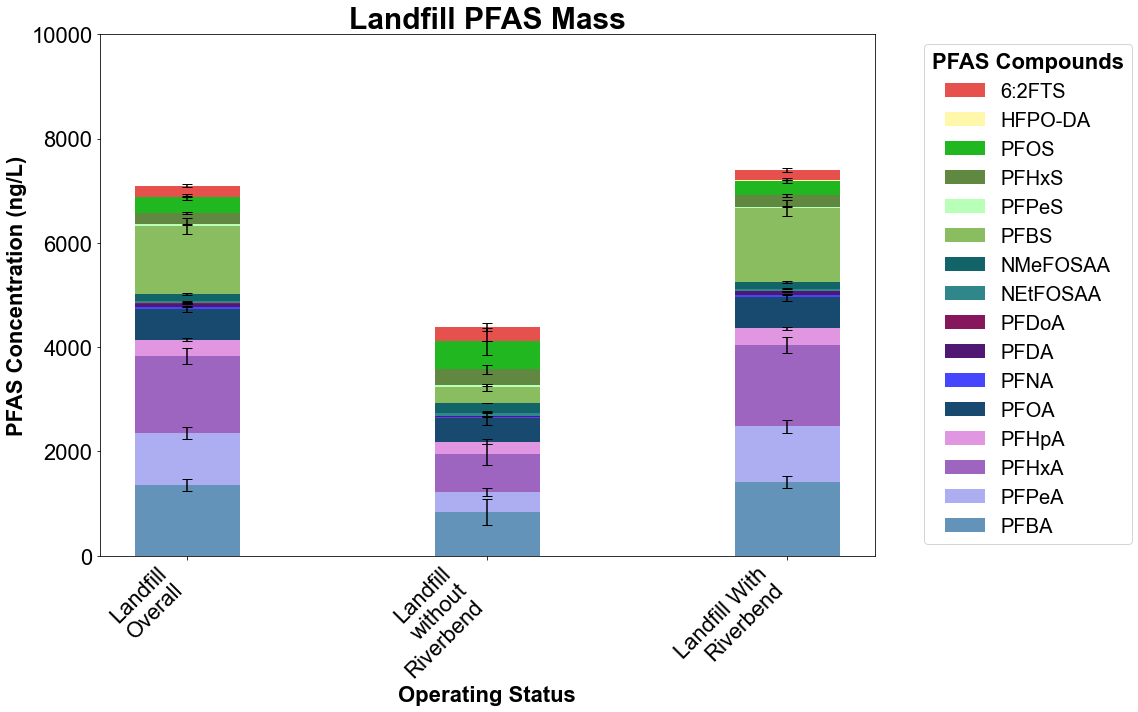

In [46]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Land_Mass, std_dev_pivot_table=df_Land_Mass_Error, figsize=(16, 10), title='Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=10000)

### Riverbend Mass BQL

In [33]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Riverbend_Mass = pd.read_excel(excel_file_path, sheet_name='Riverbend Mass BQL', usecols='C:S', skiprows=20, nrows=1)

df_Riverbend_Mass=df_Riverbend_Mass.set_index('Unnamed: 2')
desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Riverbend_Mass.columns]
# Reorder columns by indexing df with the desired order
df_Riverbend_Mass = df_Riverbend_Mass[filtered_order]
df_Riverbend_Mass

PFBA       PFPeA      PFHxA       PFHpA        PFOA  \
Unnamed: 2                                                              
Overall     541.702732  621.543138  913.32401  146.567954  303.206074   

                 PFNA       PFDA     PFDoA  NEtFOSAA   NMeFOSAA        PFBS  \
Unnamed: 2                                                                    
Overall     31.768268  51.531664  4.142231  7.577056  15.782184  961.580904   

               PFPeS      PFHxS       PFOS  HFPO-DA     6:2FTS  
Unnamed: 2                                                      
Overall     6.234264  55.527819  24.507341        0  31.897236

In [34]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Riverbend_Error = pd.read_excel(excel_file_path, sheet_name='Riverbend Mass BQL', usecols='C:S', skiprows=20, nrows=4)

df_Riverbend_Error=df_Riverbend_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Riverbend_Error.columns]
# Reorder columns by indexing df with the desired order
df_Riverbend_Error = df_Riverbend_Error[filtered_order]

df_Riverbend_Error=df_Riverbend_Error.tail(1)

In [35]:
def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        # Adjust std_dev_pivot_table to match the filtered avg_pivot_table
        if std_dev_pivot_table is not None and not std_dev_pivot_table.empty:
            std_dev_pivot_table_filtered = std_dev_pivot_table.fillna(0).reindex(columns=avg_pivot_table_filtered.columns)
        else:
            std_dev_pivot_table_filtered = pd.DataFrame(columns=avg_pivot_table_filtered.columns, index=avg_pivot_table_filtered.index)
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered[compound].values
            
            # Adjust the shape of std_dev_values for a single-row DataFrame
            if len(avg_pivot_table_filtered.index) == 1:
                std_dev_values = np.array([std_dev_values, std_dev_values])
            
            bars = ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                          label=compound, yerr=std_dev_values, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        #ax.set_xlabel('', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_ylabel('PFAS Mass (mg/day)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold,pad=20)

        xtick_labels = [label for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2, ncol=1)
        legend.get_title().set_fontweight('bold')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


<ipython-input-35-cee3cc4329e3>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


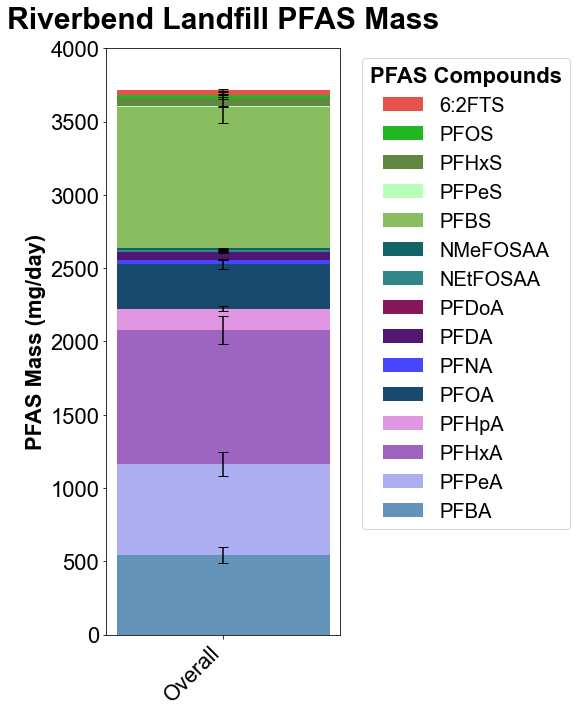

In [36]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Riverbend_Mass, std_dev_pivot_table=df_Riverbend_Error, figsize=(8, 10), title='Riverbend Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=4000)

### Riverbend Mass BDL

In [62]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Riverbend_Mass = pd.read_excel(excel_file_path, sheet_name='Riverbend Mass BDL', usecols='C:S', skiprows=19, nrows=1)
df_Riverbend_Mass
df_Riverbend_Mass=df_Riverbend_Mass.set_index('Unnamed: 2')
desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Riverbend_Mass.columns]
# Reorder columns by indexing df with the desired order
df_Riverbend_Mass = df_Riverbend_Mass[filtered_order]
df_Riverbend_Mass

PFBA       PFPeA      PFHxA       PFHpA        PFOA  \
Unnamed: 2                                                              
Overall     541.702732  621.543138  913.32401  146.567954  303.206074   

                 PFNA       PFDA     PFDoA  NEtFOSAA   NMeFOSAA        PFBS  \
Unnamed: 2                                                                    
Overall     31.768268  51.531664  4.142231  7.577056  15.782184  961.580904   

               PFPeS      PFHxS       PFOS   HFPO-DA     6:2FTS  
Unnamed: 2                                                       
Overall     6.263646  55.527819  24.507341  0.495884  29.618862

In [67]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Riverbend_Error = pd.read_excel(excel_file_path, sheet_name='Riverbend Mass BDL', usecols='C:S', skiprows=19, nrows=4)

df_Riverbend_Error=df_Riverbend_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Riverbend_Error.columns]
# Reorder columns by indexing df with the desired order
df_Riverbend_Error = df_Riverbend_Error[filtered_order]

df_Riverbend_Error=df_Riverbend_Error.tail(1)
df_Riverbend_Error

PFBA      PFPeA      PFHxA      PFHpA       PFOA      PFNA  \
Unnamed: 2                                                                    
Overall     54.102042  80.876961  97.049714  16.212945  28.941899  4.079795   

                PFDA     PFDoA  NEtFOSAA  NMeFOSAA        PFBS    PFPeS  \
Unnamed: 2                                                                
Overall     7.034527  1.027356  2.096673   3.36062  104.531595  1.67881   

              PFHxS      PFOS   HFPO-DA    6:2FTS  
Unnamed: 2                                         
Overall     5.24623  3.147453  0.157422  4.645408

In [47]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Riverbend_Mass, std_dev_pivot_table=df_Riverbend_Error, figsize=(8, 10), title='Riverbend Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=4000)

NameError: name 'df_Riverbend_Mass' is not defined

### HBL Mass BQL

In [37]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Mass = pd.read_excel(excel_file_path, sheet_name='HBL Mass', usecols='C:S', skiprows=22, nrows=1)

df_HBL_Mass=df_HBL_Mass.set_index('Unnamed: 2')
desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_HBL_Mass.columns]
# Reorder columns by indexing df with the desired order
df_HBL_Mass = df_HBL_Mass[filtered_order]
df_HBL_Mass


PFBA      PFPeA      PFHxA       PFHpA      PFOA       PFNA  \
Unnamed: 2                                                                      
Overall     991.095656  404.00906  528.69354  183.916014  286.3574  21.678327   

                 PFDA     PFDoA  NEtFOSAA    NMeFOSAA       PFBS      PFPeS  \
Unnamed: 2                                                                    
Overall     13.107347  1.388218  33.96514  132.747638  284.04605  18.476818   

                 PFHxS        PFOS  HFPO-DA      6:2FTS  
Unnamed: 2                                               
Overall     169.128902  310.565295        0  149.957371

In [38]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Error = pd.read_excel(excel_file_path, sheet_name='HBL Mass BQL', usecols='C:S', skiprows=22, nrows=4)

df_HBL_Error=df_HBL_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_HBL_Error.columns]
# Reorder columns by indexing df with the desired order
df_HBL_Error = df_HBL_Error[filtered_order]

df_HBL_Error=df_HBL_Error.tail(1)
df_HBL_Error

PFBA      PFPeA      PFHxA      PFHpA       PFOA      PFNA  \
Unnamed: 2                                                                     
Overall     132.395578  79.310493  99.331646  27.266448  43.729529  3.670113   

                PFDA     PFDoA   NEtFOSAA   NMeFOSAA       PFBS     PFPeS  \
Unnamed: 2                                                                  
Overall     4.659321  0.826293  11.223144  18.784941  75.911577  4.238693   

                PFHxS       PFOS  HFPO-DA     6:2FTS  
Unnamed: 2                                            
Overall     21.008041  73.695605        0  36.822492

<ipython-input-35-cee3cc4329e3>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


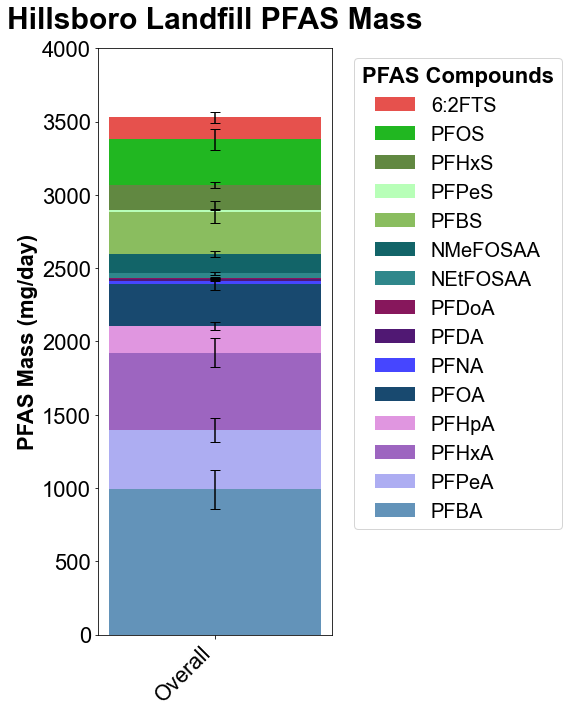

In [39]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_HBL_Mass, std_dev_pivot_table=df_HBL_Error, figsize=(8, 10), title='Hillsboro Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=4000)

### HBL Mass BDL

In [60]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Mass = pd.read_excel(excel_file_path, sheet_name='HBL Mass BDL', usecols='C:S', skiprows=21, nrows=1)

df_HBL_Mass=df_HBL_Mass.set_index('Unnamed: 2')
desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_HBL_Mass.columns]
# Reorder columns by indexing df with the desired order
df_HBL_Mass = df_HBL_Mass[filtered_order]
df_HBL_Mass

PFBA      PFPeA      PFHxA       PFHpA      PFOA       PFNA  \
Unnamed: 2                                                                      
Overall     991.095656  404.00906  528.69354  183.916014  286.3574  21.678327   

                 PFDA     PFDoA  NEtFOSAA    NMeFOSAA       PFBS      PFPeS  \
Unnamed: 2                                                                    
Overall     13.107347  1.771913  33.96514  132.747638  284.04605  18.765775   

                 PFHxS        PFOS   HFPO-DA      6:2FTS  
Unnamed: 2                                                
Overall     169.128902  310.565295  0.806832  149.957371

In [61]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_HBL_Error = pd.read_excel(excel_file_path, sheet_name='HBL Mass BDL', usecols='C:S', skiprows=21, nrows=4)

df_HBL_Error=df_HBL_Error.set_index('Unnamed: 2')

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_HBL_Error.columns]
# Reorder columns by indexing df with the desired order
df_HBL_Error = df_HBL_Error[filtered_order]

df_HBL_Error=df_HBL_Error.tail(1)
df_HBL_Error

PFBA      PFPeA      PFHxA      PFHpA       PFOA      PFNA  \
Unnamed: 2                                                                     
Overall     132.395578  79.310493  99.331646  27.266448  43.729529  3.670113   

                PFDA     PFDoA   NEtFOSAA   NMeFOSAA       PFBS     PFPeS  \
Unnamed: 2                                                                  
Overall     4.659321  0.804419  11.223144  18.784941  75.911577  4.164702   

                PFHxS       PFOS   HFPO-DA     6:2FTS  
Unnamed: 2                                             
Overall     21.008041  73.695605  0.250735  36.822492

<ipython-input-57-164bd0e2dab2>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


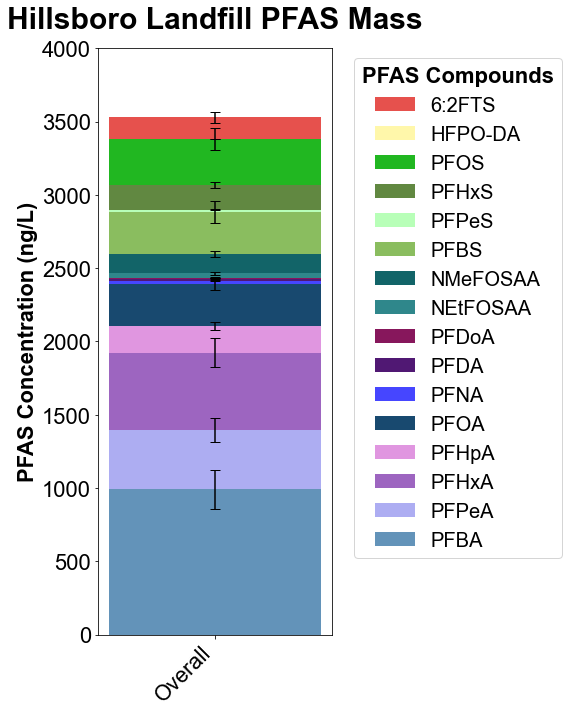

In [62]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_HBL_Mass, std_dev_pivot_table=df_HBL_Error, figsize=(8, 10), title='Hillsboro Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=4000)

### Landfill Flows

In [98]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.4f}x + {intercept:.2f}"
    ax.plot(data_df[column_x], intercept + slope * data_df[column_x], 'r')

    # Adding titles and labels with custom fonts
    ax.set_title('Landfill Flow vs Two Preceding Months Precipitation', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Precipitation (in)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Landfill Flow (MGD)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    #plt.legend()
    plt.tight_layout()
    plt.show()

In [93]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_LandfillFlows = pd.read_excel(excel_file_path, sheet_name='Landfill Flows', usecols='A:N', skiprows=1, nrows=66)

df_LandfillFlows=df_LandfillFlows.set_index('Year-Month')

df_LandfillFlows=df_LandfillFlows[['Monthly Precip','Two preceding months precip','Total Landfill Flow (MGD)']]
df_LandfillFlows

Monthly Precip  Two preceding months precip  \
Year-Month                                                
2019-1                4.07                       12.226   
2019-2                7.31                       11.380   
2019-3                1.31                        8.620   
2019-4                3.37                        4.680   
2019-5                1.73                        5.100   
...                    ...                          ...   
2024-2                5.81                       16.370   
2024-3                4.57                       10.380   
2024-4                1.89                        6.460   
2024-5                2.41                        4.300   
2024-6                1.13                        3.540   

            Total Landfill Flow (MGD)  
Year-Month                             
2019-1                       0.119508  
2019-2                       0.136580  
2019-3                       0.114220  
2019-4                       0.131413  
2019-5                       0.096362  
...                               ...  
2024-2                       0.149695  
2024-3                       0.135961  
2024-4                       0.108080  
2024-5                       0.099532  
2024-6                       0.099532  

[66 rows x 3 columns]

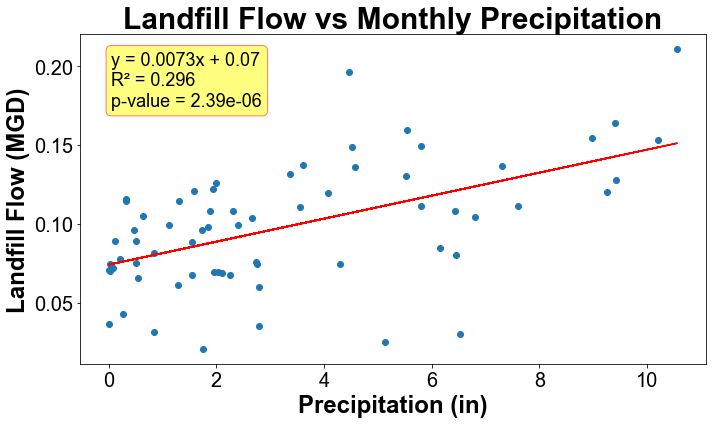

In [96]:
plot_scatter(data_df=df_LandfillFlows, column_x='Monthly Precip', column_y='Total Landfill Flow (MGD)', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

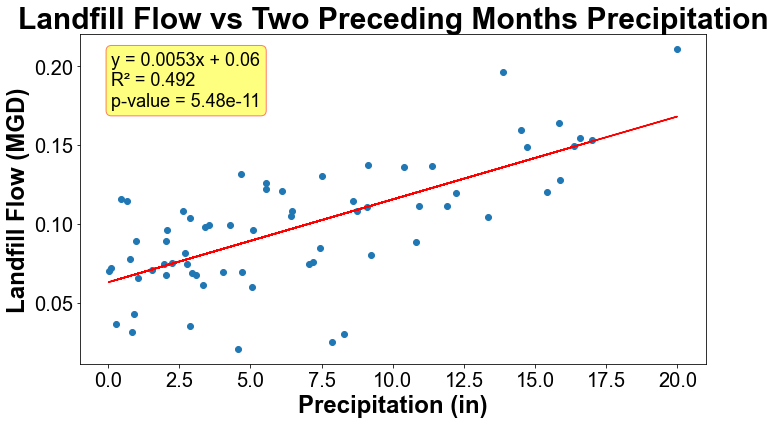

In [99]:
plot_scatter(data_df=df_LandfillFlows, column_x='Two preceding months precip', column_y='Total Landfill Flow (MGD)', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

### Cuffoff Effect Summary BQL

#### Landfill and Landfill after FF Contributions

In [70]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfill = pd.read_excel(excel_file_path, sheet_name='Fraction Mass Comb Landfill', usecols='B:S', skiprows=25, nrows=45)

df_Landfill = df_Landfill.set_index(df_Landfill.columns[0])

# Rename the index
df_Landfill.index.rename('index', inplace=True)

df_Landfill=df_Landfill.iloc[[0, 44]]

new_index = ['Hillsboro Landfill (Combined)', 'Hillsboro Landfill (Combined) After FF']

# Assigning the new index
df_Landfill.index = new_index

df_Landfill

6:2FTS HFPO-DA  NEtFOSAA  NMeFOSAA  \
Hillsboro Landfill (Combined)           0.668234     NaN  0.492912  0.526021   
Hillsboro Landfill (Combined) After FF  0.043435     NaN  0.119942   0.23671   

                                            PFBA      PFBS      PFDA  \
Hillsboro Landfill (Combined)           0.547132   0.68225  0.245099   
Hillsboro Landfill (Combined) After FF  0.465062  0.525332  0.102942   

                                           PFDoA     PFHpA     PFHxA  \
Hillsboro Landfill (Combined)           0.005818  0.425435  0.648567   
Hillsboro Landfill (Combined) After FF  0.002443  0.018719  0.286667   

                                           PFHxS      PFNA      PFOA  \
Hillsboro Landfill (Combined)           0.343319  0.181176  0.440236   
Hillsboro Landfill (Combined) After FF  0.031585  0.017212  0.017874   

                                            PFOS     PFPeA     PFPeS  \
Hillsboro Landfill (Combined)           0.203725  0.550187  0.046002   
Hillsboro Landfill (Combined) After FF  0.004074  0.418142  0.014836   

                                       Total PFAS  
Hillsboro Landfill (Combined)            0.567392  
Hillsboro Landfill (Combined) After FF   0.226957

In [74]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfill_Error = pd.read_excel(excel_file_path, sheet_name='Fraction Mass Comb Landfill', usecols='B:S', skiprows=25, nrows=45)

df_Landfill_Error = df_Landfill_Error.set_index(df_Landfill_Error.columns[0])

# Rename the index
df_Landfill_Error.index.rename('index', inplace=True)

df_Landfill_Error=df_Landfill_Error.iloc[[5]]

new_index = ['Hillsboro Landfill (Combined)']

# Assigning the new index
df_Landfill_Error.index = new_index

df_Landfill_Error.loc['Hillsboro Landfill (Combined) After FF']=np.NaN
df_Landfill_Error

6:2FTS HFPO-DA NEtFOSAA NMeFOSAA  \
Hillsboro Landfill (Combined)             NaN     NaN      NaN  0.17478   
Hillsboro Landfill (Combined) After FF    NaN     NaN      NaN      NaN   

                                            PFBA      PFBS      PFDA PFDoA  \
Hillsboro Landfill (Combined)           0.115461  0.081869  0.019961   NaN   
Hillsboro Landfill (Combined) After FF       NaN       NaN       NaN   NaN   

                                           PFHpA     PFHxA     PFHxS  \
Hillsboro Landfill (Combined)           0.028472  0.087363  0.062795   
Hillsboro Landfill (Combined) After FF       NaN       NaN       NaN   

                                            PFNA      PFOA      PFOS  \
Hillsboro Landfill (Combined)           0.031911  0.046014  0.073224   
Hillsboro Landfill (Combined) After FF       NaN       NaN       NaN   

                                           PFPeA     PFPeS Total PFAS  
Hillsboro Landfill (Combined)           0.059384  0.006476   0.048691  
Hillsboro Landfill (Combined) After FF       NaN       NaN        NaN

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


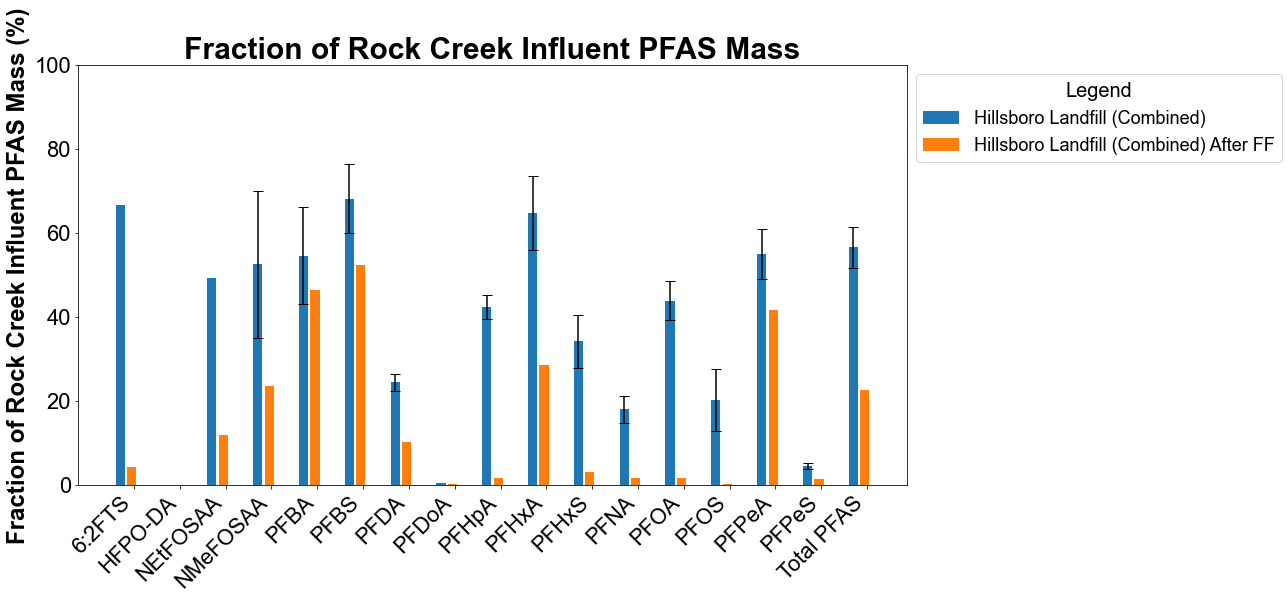

In [75]:
combined_df=df_Landfill
combined_df_error=df_Landfill_Error
# Assuming combined_df has 3 rows (indices) and multiple columns for each category
fig, ax = plt.subplots(figsize=(18, 8))

# Setting up the bar width and the positions for each group of bars
bar_width = 0.2
indices = np.arange(len(combined_df.columns))

# Plotting bars for each index in the DataFrame
for i, index_name in enumerate(combined_df.index):
    bar_positions = indices + i*bar_width + i*0.05  # Added spacing between bars
    yerr = combined_df_error.loc[index_name].values * 100 if index_name in combined_df_error.index else None
    ax.bar(bar_positions, combined_df.loc[index_name] * 100, width=bar_width, label=index_name,
           yerr=yerr, capsize=5, )

# Setting the y-axis limits to 0-100 for percentages
ax.set_ylim(0, 100)

# Adding labels and title
ax.set_ylabel('Fraction of Rock Creek Influent PFAS Mass (%)')
ax.set_title('Fraction of Rock Creek Influent PFAS Mass')
ax.set_xticks(indices + bar_width + 0.1)  # Adjusting x-ticks position for clarity
ax.set_xticklabels(combined_df.columns, rotation=45, ha='right')  # Setting x-ticks labels to column names

# Consolidating legend from both axes
handles, labels = [], []
for ax in fig.axes:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1, 1), loc='upper left', fontsize=18, title_fontsize=20)

plt.tight_layout()  # Adjust layout to make room for the tick labels
plt.show()

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


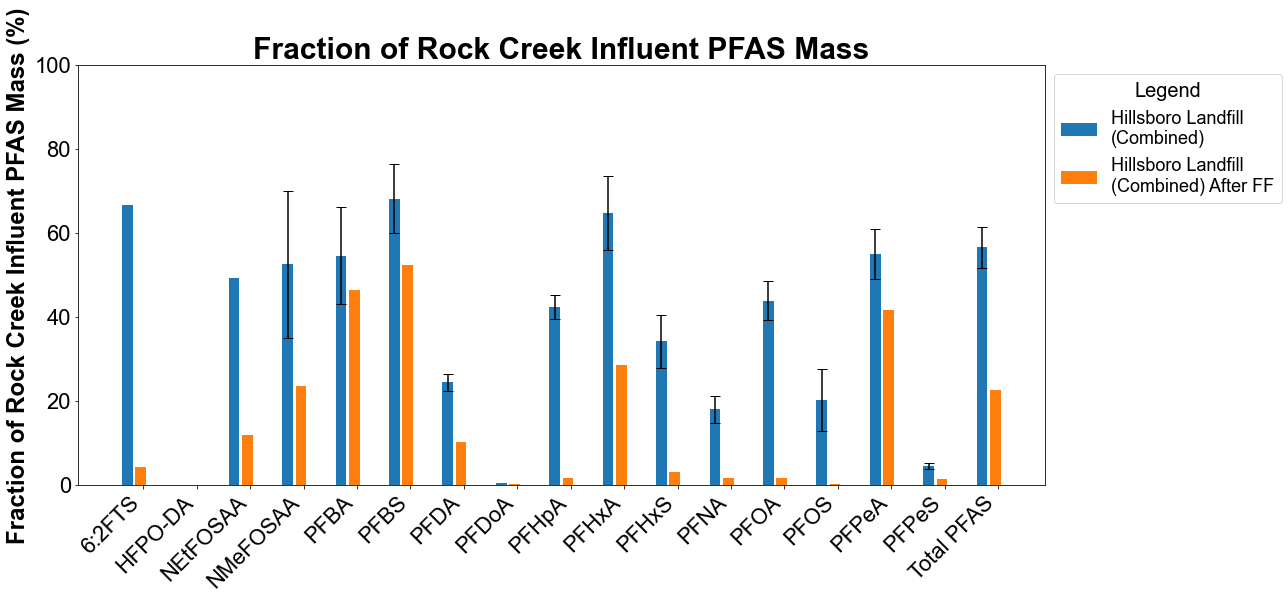

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def split_legend_label(label, max_length=20):
    """Splits label into multiple lines if longer than max_length."""
    if len(label) > max_length:
        # Split the label at max_length keeping words intact
        words = label.split()
        new_label = ""
        current_line = ""
        for word in words:
            if len(current_line + word) < max_length:
                current_line += word + " "
            else:
                new_label += current_line.strip() + '\n'
                current_line = word + " "
        new_label += current_line.strip()
        return new_label
    return label

combined_df = df_Landfill
combined_df_error = df_Landfill_Error
# Assuming combined_df has 3 rows (indices) and multiple columns for each category
fig, ax = plt.subplots(figsize=(18, 8))

# Setting up the bar width and the positions for each group of bars
bar_width = 0.2
indices = np.arange(len(combined_df.columns))

# Plotting bars for each index in the DataFrame
for i, index_name in enumerate(combined_df.index):
    bar_positions = indices + i*bar_width + i*0.05  # Added spacing between bars
    yerr = combined_df_error.loc[index_name].values * 100 if index_name in combined_df_error.index else None
    ax.bar(bar_positions, combined_df.loc[index_name] * 100, width=bar_width, label=split_legend_label(index_name),
           yerr=yerr, capsize=5)

# Setting the y-axis limits to 0-100 for percentages
ax.set_ylim(0, 100)

# Adding labels and title
ax.set_ylabel('Fraction of Rock Creek Influent PFAS Mass (%)')
ax.set_title('Fraction of Rock Creek Influent PFAS Mass')
ax.set_xticks(indices + bar_width + 0.1)  # Adjusting x-ticks position for clarity
ax.set_xticklabels(combined_df.columns, rotation=45, ha='right')  # Setting x-ticks labels to column names

# Consolidating legend from both axes
handles, labels = [], []
for ax in fig.axes:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

# Splitting labels if they are too long
labels = [split_legend_label(label) for label in labels]

ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1, 1), loc='upper left', fontsize=18, title_fontsize=20)

plt.tight_layout()  # Adjust layout to make room for the tick labels
plt.show()


#### PFAS Mass Contributions from Landfill Combined and Riverbend

##### Landfill Data

In [95]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfill = pd.read_excel(excel_file_path, sheet_name='Fraction Mass Comb Landfill', usecols='B:S', skiprows=25, nrows=45)

df_Landfill = df_Landfill.set_index(df_Landfill.columns[0])

# Rename the index
df_Landfill.index.rename('index', inplace=True)

df_Landfill=df_Landfill.iloc[[0]]

new_index = ['Hillsboro Landfill (Combined)']

# Assigning the new index
df_Landfill.index = new_index

df_Landfill

6:2FTS HFPO-DA  NEtFOSAA  NMeFOSAA      PFBA  \
Hillsboro Landfill (Combined)  0.668234     NaN  0.492912  0.526021  0.547132   

                                  PFBS      PFDA     PFDoA     PFHpA  \
Hillsboro Landfill (Combined)  0.68225  0.245099  0.005818  0.425435   

                                  PFHxA     PFHxS      PFNA      PFOA  \
Hillsboro Landfill (Combined)  0.648567  0.343319  0.181176  0.440236   

                                   PFOS     PFPeA     PFPeS Total PFAS  
Hillsboro Landfill (Combined)  0.203725  0.550187  0.046002   0.567392

In [96]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfill_Error = pd.read_excel(excel_file_path, sheet_name='Fraction Mass Comb Landfill', usecols='B:S', skiprows=25, nrows=45)

df_Landfill_Error = df_Landfill_Error.set_index(df_Landfill_Error.columns[0])

# Rename the index
df_Landfill_Error.index.rename('index', inplace=True)

df_Landfill_Error=df_Landfill_Error.iloc[[5]]

new_index = ['Hillsboro Landfill (Combined)']

# Assigning the new index
df_Landfill_Error.index = new_index
df_Landfill_Error

6:2FTS HFPO-DA NEtFOSAA NMeFOSAA      PFBA  \
Hillsboro Landfill (Combined)    NaN     NaN      NaN  0.17478  0.115461   

                                   PFBS      PFDA PFDoA     PFHpA     PFHxA  \
Hillsboro Landfill (Combined)  0.081869  0.019961   NaN  0.028472  0.087363   

                                  PFHxS      PFNA      PFOA      PFOS  \
Hillsboro Landfill (Combined)  0.062795  0.031911  0.046014  0.073224   

                                  PFPeA     PFPeS Total PFAS  
Hillsboro Landfill (Combined)  0.059384  0.006476   0.048691

##### Riverbend Data

In [97]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_River = pd.read_excel(excel_file_path, sheet_name='Fraction Mass Riverbend', usecols='B:S', skiprows=20, nrows=1)

df_River = df_River.set_index(df_River.columns[0])

# Rename the index
df_River.index.rename('index', inplace=True)

new_index = ['Riverbend Landfill']

# Assigning the new index
df_River.index = new_index
df_River

6:2FTS  HFPO-DA  NEtFOSAA  NMeFOSAA      PFBA      PFBS  \
Riverbend Landfill  0.105809        0  0.087055  0.076233  0.134288  0.310368   

                        PFDA     PFDoA    PFHpA     PFHxA     PFHxS      PFNA  \
Riverbend Landfill  0.142847  0.003168  0.13404  0.231544  0.067297  0.075718   

                        PFOA      PFOS     PFPeA     PFPeS  Total PFAS  
Riverbend Landfill  0.158192  0.013534  0.196864  0.012042    0.177173

In [98]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_River_error = pd.read_excel(excel_file_path, sheet_name='Fraction Mass Riverbend', usecols='B:S', skiprows=20, nrows=6)

df_River_error = df_River_error.set_index(df_River_error.columns[0])
# Rename the index
df_River_error.index.rename('index', inplace=True)
df_River_error=df_River_error.iloc[[5]]

new_index = ['Riverbend Landfill']

# Assigning the new index
df_River_error.index = new_index
df_River_error

6:2FTS  HFPO-DA  NEtFOSAA  NMeFOSAA      PFBA      PFBS  \
Riverbend Landfill     NaN      NaN       NaN  0.008238  0.017398  0.049428   

                        PFDA  PFDoA     PFHpA     PFHxA     PFHxS     PFNA  \
Riverbend Landfill  0.011583    NaN  0.023217  0.036516  0.008518  0.01471   

                        PFOA      PFOS     PFPeA    PFPeS  Total PFAS  
Riverbend Landfill  0.034072  0.003779  0.027927  0.00024    0.027509

##### Combine dataframes

In [99]:
# Concatenate selected rows from both DataFrames
combined_df = pd.concat([df_Landfill, df_River])

# Display the new DataFrame
combined_df

6:2FTS HFPO-DA  NEtFOSAA  NMeFOSAA      PFBA  \
Hillsboro Landfill (Combined)  0.668234     NaN  0.492912  0.526021  0.547132   
Riverbend Landfill             0.105809       0  0.087055  0.076233  0.134288   

                                   PFBS      PFDA     PFDoA     PFHpA  \
Hillsboro Landfill (Combined)   0.68225  0.245099  0.005818  0.425435   
Riverbend Landfill             0.310368  0.142847  0.003168   0.13404   

                                  PFHxA     PFHxS      PFNA      PFOA  \
Hillsboro Landfill (Combined)  0.648567  0.343319  0.181176  0.440236   
Riverbend Landfill             0.231544  0.067297  0.075718  0.158192   

                                   PFOS     PFPeA     PFPeS Total PFAS  
Hillsboro Landfill (Combined)  0.203725  0.550187  0.046002   0.567392  
Riverbend Landfill             0.013534  0.196864  0.012042   0.177173

In [100]:
# Concatenate selected rows from both DataFrames
combined_df_error = pd.concat([df_Landfill_Error, df_River_error])

# Display the new DataFrame
combined_df_error

6:2FTS HFPO-DA NEtFOSAA  NMeFOSAA      PFBA  \
Hillsboro Landfill (Combined)    NaN     NaN      NaN   0.17478  0.115461   
Riverbend Landfill               NaN     NaN      NaN  0.008238  0.017398   

                                   PFBS      PFDA PFDoA     PFHpA     PFHxA  \
Hillsboro Landfill (Combined)  0.081869  0.019961   NaN  0.028472  0.087363   
Riverbend Landfill             0.049428  0.011583   NaN  0.023217  0.036516   

                                  PFHxS      PFNA      PFOA      PFOS  \
Hillsboro Landfill (Combined)  0.062795  0.031911  0.046014  0.073224   
Riverbend Landfill             0.008518   0.01471  0.034072  0.003779   

                                  PFPeA     PFPeS Total PFAS  
Hillsboro Landfill (Combined)  0.059384  0.006476   0.048691  
Riverbend Landfill             0.027927   0.00024   0.027509

##### Plot

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


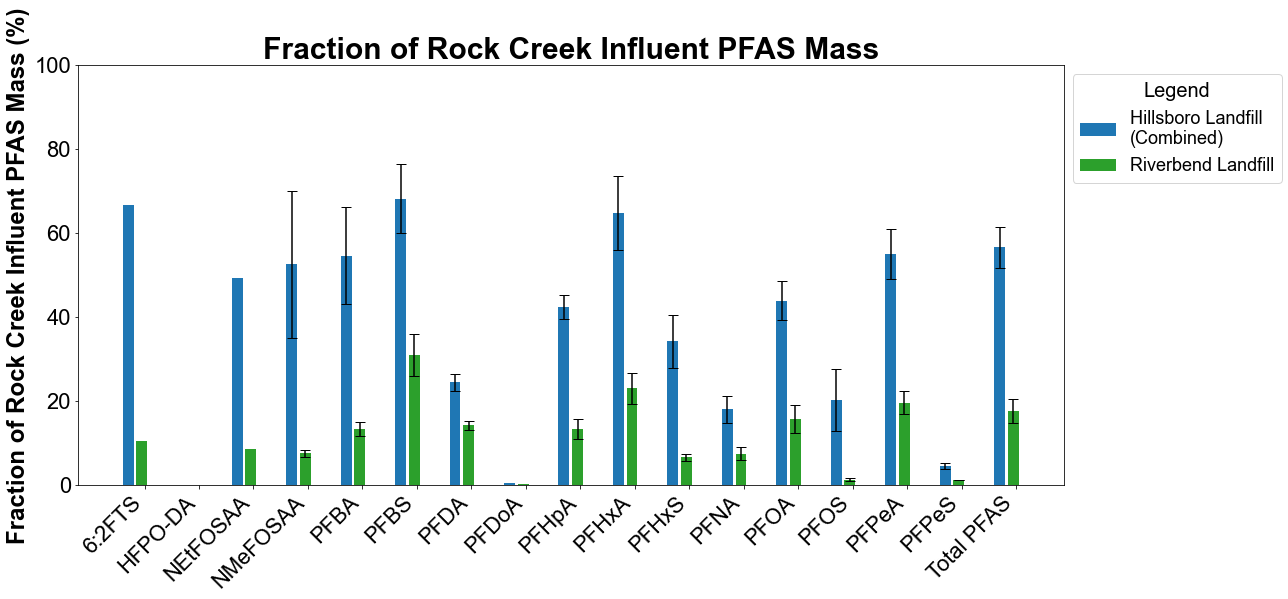

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def split_legend_label(label, max_length=20):
    """Splits label into multiple lines if longer than max_length."""
    if len(label) > max_length:
        # Split the label at max_length keeping words intact
        words = label.split()
        new_label = ""
        current_line = ""
        for word in words:
            if len(current_line + word) < max_length:
                current_line += word + " "
            else:
                new_label += current_line.strip() + '\n'
                current_line = word + " "
        new_label += current_line.strip()
        return new_label
    return label

# Assuming combined_df has 3 rows (indices) and multiple columns for each category
fig, ax = plt.subplots(figsize=(18, 8))

# Setting up the bar width and the positions for each group of bars
bar_width = 0.2
indices = np.arange(len(combined_df.columns))

# Define colors for the bars
colors = ['tab:blue', 'tab:green', 'tab:red']  # Adjust this list to include your desired colors

# Plotting bars for each index in the DataFrame
for i, index_name in enumerate(combined_df.index):
    bar_positions = indices + i*bar_width + i*0.05  # Added spacing between bars
    yerr = combined_df_error.loc[index_name].values * 100 if index_name in combined_df_error.index else None
    ax.bar(bar_positions, combined_df.loc[index_name] * 100, width=bar_width, label=split_legend_label(index_name),
           color=colors[i], yerr=yerr, capsize=5)  # Using colors from the list

# Setting the y-axis limits to 0-100 for percentages
ax.set_ylim(0, 100)

# Adding labels and title
ax.set_ylabel('Fraction of Rock Creek Influent PFAS Mass (%)')
ax.set_title('Fraction of Rock Creek Influent PFAS Mass')
ax.set_xticks(indices + bar_width + 0.1)  # Adjusting x-ticks position for clarity
ax.set_xticklabels(combined_df.columns, rotation=45, ha='right')  # Setting x-ticks labels to column names

# Consolidating legend from both axes
handles, labels = [], []
for ax in fig.axes:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

# Splitting labels if they are too long
labels = [split_legend_label(label) for label in labels]

ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1, 1), loc='upper left', fontsize=18, title_fontsize=20)

plt.tight_layout()  # Adjust layout to make room for the tick labels
plt.show()


### PFAS Mass by Landfill

In [167]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        if std_dev_pivot_table is not None and not std_dev_pivot_table.empty:
            std_dev_pivot_table_filtered = std_dev_pivot_table.fillna(0)[avg_pivot_table_filtered.columns]
        else:
            std_dev_pivot_table_filtered = pd.DataFrame(columns=avg_pivot_table_filtered.columns, index=avg_pivot_table_filtered.index)
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values))
            
            bars = ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                          label=compound, yerr=std_dev_values, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        #ax.set_xlabel('Operating Status', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_ylabel('PFAS Mass (mg/day)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)

        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2, ncol=1)
        legend.get_title().set_fontweight('bold')  # Set the legend title to bold

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

In [172]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfills_Mass = pd.read_excel(excel_file_path, sheet_name='Summary Landfill Mass Effects', usecols='B:S', skiprows=38, nrows=2)

df_Landfills_Mass = df_Landfills_Mass.set_index(df_Landfills_Mass.columns[0])
df_Landfills_Mass = df_Landfills_Mass.iloc[:, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not alread
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Landfills_Mass.columns]
# Reorder columns by indexing df with the desired order
df_Landfills_Mass = df_Landfills_Mass[filtered_order]

df_Landfills_Mass


PFBA       PFPeA      PFHxA       PFHpA        PFOA  \
Unnamed: 1                                                              
Riverbend   541.702732  621.543138  913.32401  146.567954  303.206074   
Hillsboro   991.095656  404.009060  528.69354  183.916014  286.357400   

                 PFNA       PFDA     PFDoA   NEtFOSAA    NMeFOSAA        PFBS  \
Unnamed: 1                                                                      
Riverbend   31.768268  51.531664  4.142231   7.577056   15.782184  961.580904   
Hillsboro   21.678327  13.107347  1.388218  33.965140  132.747638  284.046050   

                PFPeS       PFHxS        PFOS  HFPO-DA      6:2FTS  
Unnamed: 1                                                          
Riverbend    6.234264   55.527819   24.507341        0   31.897236  
Hillsboro   18.476818  169.128902  310.565295        0  149.957371

In [173]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfills_Mass_stderror = pd.read_excel(excel_file_path, sheet_name='Summary Landfill Mass Effects', usecols='B:S', skiprows=38, nrows=4)

df_Landfills_Mass_stderror = df_Landfills_Mass_stderror.set_index(df_Landfills_Mass_stderror.columns[0])

df_Landfills_Mass_stderror=df_Landfills_Mass_stderror.iloc[2:] 
df_Landfills_Mass_stderror = df_Landfills_Mass_stderror.iloc[:, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Landfills_Mass_stderror.columns]
# Reorder columns by indexing df with the desired order
df_Landfills_Mass_stderror = df_Landfills_Mass_stderror[filtered_order]

df_Landfills_Mass_stderror

PFBA      PFPeA      PFHxA      PFHpA       PFOA      PFNA  \
Unnamed: 1                                                                     
Riverbend    54.102042  80.876961  97.049714  16.212945  28.941899  4.079795   
Hillsboro   132.395578  79.310493  99.331646  27.266448  43.729529  3.670113   

                PFDA     PFDoA   NEtFOSAA   NMeFOSAA        PFBS     PFPeS  \
Unnamed: 1                                                                   
Riverbend   7.034527  1.027356   2.096673   3.360620  104.531595  1.686926   
Hillsboro   4.659321  0.826293  11.223144  18.784941   75.911577  4.238693   

                PFHxS       PFOS  HFPO-DA     6:2FTS  
Unnamed: 1                                            
Riverbend    5.246230   3.147453        0   4.372676  
Hillsboro   21.008041  73.695605        0  36.822492

<ipython-input-167-d328287f71ca>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


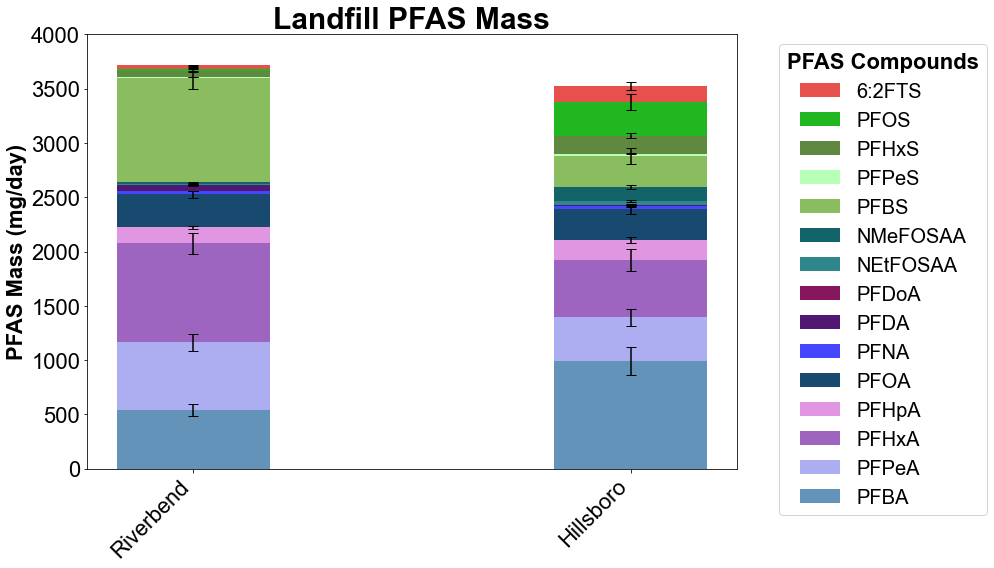

In [174]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Landfills_Mass, std_dev_pivot_table=df_Landfills_Mass_stderror, figsize=(14, 8), title='Landfill PFAS Mass', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=4000)

### Theoretical Rock Creek Influent PFAS Concentration

In [7]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        if std_dev_pivot_table is not None and not std_dev_pivot_table.empty:
            std_dev_pivot_table_filtered = std_dev_pivot_table.fillna(0)[avg_pivot_table_filtered.columns]
        else:
            std_dev_pivot_table_filtered = pd.DataFrame(columns=avg_pivot_table_filtered.columns, index=avg_pivot_table_filtered.index)
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for compound in avg_pivot_table_filtered.columns:
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            std_dev_values = std_dev_pivot_table_filtered.get(compound, np.zeros_like(avg_values))
            
            bars = ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                          label=compound, yerr=std_dev_values, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        #ax.set_xlabel('Operating Status', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)

        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2, ncol=1)
        legend.get_title().set_fontweight('bold')  # Set the legend title to bold

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

In [137]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfills_Conc = pd.read_excel(excel_file_path, sheet_name='Summary Landfill Mass Effects', usecols='B:R', skiprows=30, nrows=6)

df_Landfills_Conc = df_Landfills_Conc.set_index(df_Landfills_Conc.columns[0])
df_Landfills_Conc = df_Landfills_Conc.iloc[:, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Landfills_Conc.columns]
# Reorder columns by indexing df with the desired order
df_Landfills_Conc = df_Landfills_Conc[filtered_order]

df_Landfills_Conc=df_Landfills_Conc.iloc[[0,3,4]]

#new_index = ['Current', 'Other Sources','Rock Creek without Riverbend','Rock Creek with FF at Landfill']

# Assigning the new index
#df_Landfills_Conc.index = new_index

#new_order = ['Current', 'Rock Creek without Riverbend','Rock Creek with FF at Landfill']

# Reordering the DataFrame
#df_Landfills_Conc = df_Landfills_Conc.reindex(new_order)

df_Landfills_Conc


PFBA      PFPeA      PFHxA     PFHpA  \
Unnamed: 1                                                                
Rock Creek (Current)          28.940000  16.407692  23.541667  6.309091   
Rock Creek without Riverbend  22.027266  12.183667  16.523312  5.037433   
Rock Creek if FF at Landfill  23.339832  13.157917  13.710947  3.448857   

                                   PFOA      PFNA      PFDA      PFDoA  \
Unnamed: 1                                                               
Rock Creek (Current)          10.790909  2.040000  2.096000  13.000000   
Rock Creek without Riverbend   8.744675  1.883512  1.853549   8.746340   
Rock Creek if FF at Landfill   5.996349  1.702509  1.853763   8.738514   

                              NEtFOSAA  NMeFOSAA      PFBS     PFHxS  \
Unnamed: 1                                                             
Rock Creek (Current)          0.512500  1.175000  18.05000  4.245455   
Rock Creek without Riverbend  0.533281  1.158318  11.24657  3.723685   
Rock Creek if FF at Landfill  0.366016  0.890524  13.73959  2.745914   

                                  PFOS   HFPO-DA    6:2FTS  
Unnamed: 1                                                  
Rock Creek (Current)          9.859091  0.530000  2.300000  
Rock Creek without Riverbend  9.463702  0.533315  1.809095  
Rock Creek if FF at Landfill  7.672900       NaN  0.758572

In [138]:
# Get the std error for Rock Creek Current concentration
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Error = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc', usecols='B:R', skiprows=26, nrows=30)
df_RC_Error=df_RC_Error.tail(1)
df_RC_Error = df_RC_Error.set_index(df_RC_Error.columns[0])

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Error.columns]
# Reorder columns by indexing df with the desired order
df_RC_Error = df_RC_Error[filtered_order]

new_index = ['Rock Creek (Current)']

# Assigning the new index
df_RC_Error.index = new_index

df_RC_Error

c:\Users\rodriguezc\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


PFBA     PFPeA     PFHxA     PFHpA      PFOA  PFNA  \
Rock Creek (Current)  5.554002  2.543858  4.080765  0.819141  1.341604  0.44   

                          PFDA  PFDoA  NEtFOSAA  NMeFOSAA    PFBS     PFHxS  \
Rock Creek (Current)  0.455429    NaN    0.1775  0.085391  3.4891  0.729678   

                          PFOS  HFPO-DA    6:2FTS  
Rock Creek (Current)  0.913754      NaN  0.832666

In [139]:
df_RC_Error.loc['Rock Creek without Riverbend']= np.nan
df_RC_Error.loc['Rock Creek if FF at Landfill']= np.nan
df_RC_Error

PFBA     PFPeA     PFHxA     PFHpA  \
Rock Creek (Current)          5.554002  2.543858  4.080765  0.819141   
Rock Creek without Riverbend       NaN       NaN       NaN       NaN   
Rock Creek if FF at Landfill       NaN       NaN       NaN       NaN   

                                  PFOA  PFNA      PFDA  PFDoA  NEtFOSAA  \
Rock Creek (Current)          1.341604  0.44  0.455429    NaN    0.1775   
Rock Creek without Riverbend       NaN   NaN       NaN    NaN       NaN   
Rock Creek if FF at Landfill       NaN   NaN       NaN    NaN       NaN   

                              NMeFOSAA    PFBS     PFHxS      PFOS  HFPO-DA  \
Rock Creek (Current)          0.085391  3.4891  0.729678  0.913754      NaN   
Rock Creek without Riverbend       NaN     NaN       NaN       NaN      NaN   
Rock Creek if FF at Landfill       NaN     NaN       NaN       NaN      NaN   

                                6:2FTS  
Rock Creek (Current)          0.832666  
Rock Creek without Riverbend       NaN  
Rock Creek if FF at Landfill       NaN

In [140]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for i, compound in enumerate(avg_pivot_table_filtered.columns):
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            if std_dev_pivot_table is not None:
                std_dev_values = std_dev_pivot_table.get(compound)
                # Only use std_dev_values where they are not NaN
                error_bars = std_dev_values.where(std_dev_values.notna(), None).values
            else:
                error_bars = None
            
            ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                   label=compound, yerr=error_bars if error_bars is not None else None, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)


        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()  # Optional: reverse the order of legend items
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        legend.get_title().set_fontweight('bold')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

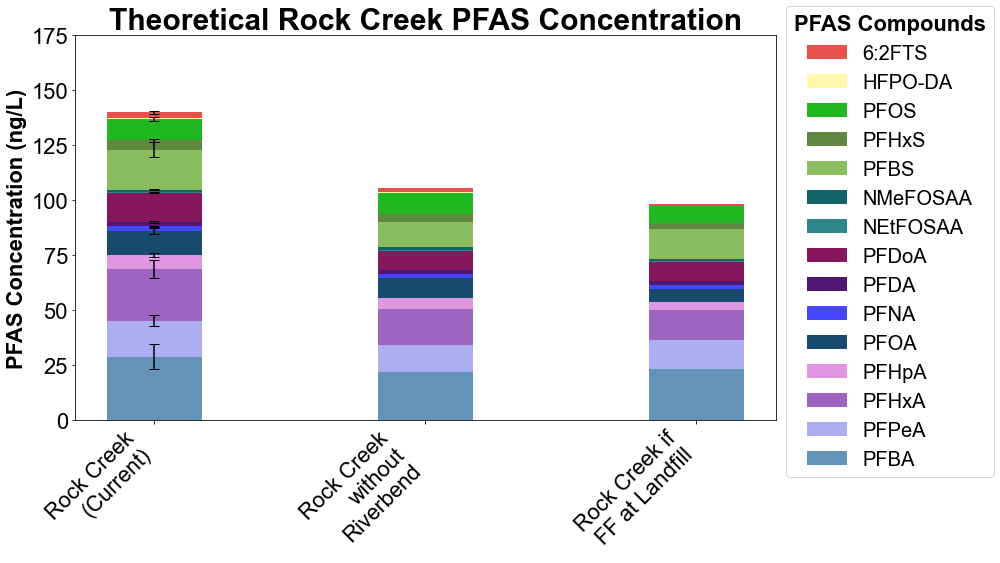

In [141]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Landfills_Conc, std_dev_pivot_table=df_RC_Error, figsize=(14, 8), title='Theoretical Rock Creek PFAS Concentration', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=175)

##### BDL Version

In [10]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Conc = pd.read_excel(excel_file_path, sheet_name='Cuffoff Effect Summary BDL', usecols='B:R', skiprows=44, nrows=4)

df_RC_Conc = df_RC_Conc.set_index(df_RC_Conc.columns[0])
#df_Landfills_Conc = df_Landfills_Conc.iloc[:, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Conc.columns]
# Reorder columns by indexing df with the desired order
df_RC_Conc = df_RC_Conc[filtered_order]

df_RC_Conc=df_RC_Conc.iloc[[0,2,3]]

#new_index = ['Current', 'Other Sources','Rock Creek without Riverbend','Rock Creek with FF at Landfill']

# Assigning the new index
#df_Landfills_Conc.index = new_index

#new_order = ['Current', 'Rock Creek without Riverbend','Rock Creek with FF at Landfill']

# Reordering the DataFrame
#df_Landfills_Conc = df_Landfills_Conc.reindex(new_order)

df_RC_Conc


PFBA      PFPeA      PFHxA     PFHpA  \
Unnamed: 1                                                                
Current                       22.814286  15.417857  20.857143  5.425000   
Rock Creek without Riverbend  17.648232  11.344581  14.703765  4.364102   
Rock Creek if FF at Landfill  18.671422  12.322169  12.157392  2.919860   

                                  PFOA      PFNA      PFDA     PFDoA  \
Unnamed: 1                                                             
Current                       8.875000  1.910714  2.073571  2.468750   
Rock Creek without Riverbend  7.156515  1.591867  1.655726  2.063922   
Rock Creek if FF at Landfill  4.518267  1.426589  1.714306  1.991303   

                              NEtFOSAA  NMeFOSAA      PFBS     PFPeS  \
Unnamed: 1                                                             
Current                       1.762679  2.035714  18.05000  1.931429   
Rock Creek without Riverbend  1.616335  1.802089  11.24657  1.956082   
Rock Creek if FF at Landfill  1.365617  1.569639  13.73959  1.795750   

                                 PFHxS      PFOS   HFPO-DA    6:2FTS  
Unnamed: 1                                                            
Current                       3.875000  8.298214  2.167885  5.337500  
Rock Creek without Riverbend  3.382507  8.054015  2.102197  4.757585  
Rock Creek if FF at Landfill  2.516526  6.520344  2.101434  3.324340

In [13]:
# Get the std error for Rock Creek Current concentration
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_RC_Error = pd.read_excel(excel_file_path, sheet_name='Rock Creek Conc BDL', usecols='C:S', skiprows=24, nrows=24)
df_RC_Error=df_RC_Error.tail(1)
df_RC_Error = df_RC_Error.set_index(df_RC_Error.columns[0])

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_RC_Error.columns]
# Reorder columns by indexing df with the desired order
df_RC_Error = df_RC_Error[filtered_order]

new_index = ['Current']

# Assigning the new index
df_RC_Error.index = new_index

df_RC_Error.loc['Rock Creek without Riverbend']= np.nan
df_RC_Error.loc['Rock Creek if FF at Landfill']= np.nan

df_RC_Error

PFBA     PFPeA     PFHxA     PFHpA  \
Current                       4.754741  2.554707  3.924867  0.793635   
Rock Creek without Riverbend       NaN       NaN       NaN       NaN   
Rock Creek if FF at Landfill       NaN       NaN       NaN       NaN   

                                  PFOA      PFNA      PFDA     PFDoA  \
Current                       1.458499  0.223249  0.187832  0.849816   
Rock Creek without Riverbend       NaN       NaN       NaN       NaN   
Rock Creek if FF at Landfill       NaN       NaN       NaN       NaN   

                              NEtFOSAA  NMeFOSAA    PFBS     PFPeS     PFHxS  \
Current                       0.277587  0.227952  3.4891  0.328456  0.600429   
Rock Creek without Riverbend       NaN       NaN     NaN       NaN       NaN   
Rock Creek if FF at Landfill       NaN       NaN     NaN       NaN       NaN   

                                  PFOS   HFPO-DA    6:2FTS  
Current                       1.120042  0.409446  1.364361  
Rock Creek without Riverbend       NaN       NaN       NaN  
Rock Creek if FF at Landfill       NaN       NaN       NaN

In [14]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

def create_stacked_bar_chart_filtered(avg_pivot_table, std_dev_pivot_table=None, figsize=(10, 6),
                                      title='Average PFAS Concentrations by Month and Year', compound_colors_dict=None,
                                      title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14, legend_fontsize=12, ylim=50):
    try:
        font = FontProperties(family='Arial')
        font_bold = FontProperties(family='Arial', weight='bold')
        # Replace NaN values with zeros in avg_pivot_table for plotting
        avg_pivot_table_filtered = avg_pivot_table.fillna(0).loc[:, (avg_pivot_table != 0).any(axis=0)]
        
        fig, ax = plt.subplots(figsize=figsize)
        bottom = np.zeros(len(avg_pivot_table_filtered.index))

        for i, compound in enumerate(avg_pivot_table_filtered.columns):
            color = compound_colors_dict.get(compound, 'grey')  # Default grey color
            avg_values = avg_pivot_table_filtered[compound].values
            if std_dev_pivot_table is not None:
                std_dev_values = std_dev_pivot_table.get(compound)
                # Only use std_dev_values where they are not NaN
                error_bars = std_dev_values.where(std_dev_values.notna(), None).values
            else:
                error_bars = None
            
            ax.bar(avg_pivot_table_filtered.index, avg_values, width=0.35, bottom=bottom, color=color,
                   label=compound, yerr=error_bars if error_bars is not None else None, capsize=5)
            bottom += avg_values
        
        ax.set_ylim(0, ylim)
        ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)
        ax.set_title(title, fontsize=title_fontsize, fontproperties=font_bold)


        # Function to split labels for better readability
        def split_label(label):
            max_chars = 14  # Maximum characters per line
            words = label.split()
            split_label = ""
            current_line = ""
            for word in words:
                if len(current_line + word) <= max_chars:
                    current_line += word + " "
                else:
                    split_label += (current_line.strip() + '\n')
                    current_line = word + " "
            split_label += current_line.strip()  # Add the last line
            return split_label

        xtick_labels = [split_label(label) for label in avg_pivot_table_filtered.index]
        ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend_handles.reverse()  # Optional: reverse the order of legend items
        legend_labels.reverse()
        legend = ax.legend(handles=legend_handles, labels=legend_labels, title='PFAS Compounds', bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)
        legend.get_title().set_fontweight('bold')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\

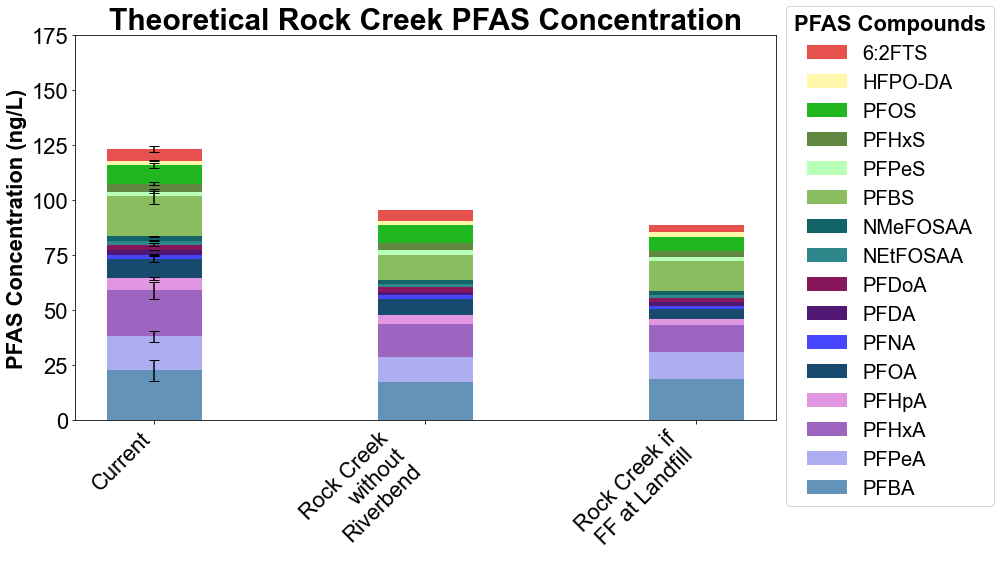

In [15]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_RC_Conc, std_dev_pivot_table=df_RC_Error, figsize=(14, 8), title='Theoretical Rock Creek PFAS Concentration', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=175)

##### Version with WRRF Avg Concentrations

In [142]:
def PivotTable_AvgPFASCompound_FilterByCompoundSamplingDatesLocation(data_df, filter_qual_summary=None, filter_pfas_compound=None,
                              filter_sample_location=None, start_date=None, end_date=None,col_name= 'Quant Incl Estimates Incl Qual Flags'):
    """
    Create a custom pivot table with filters based on 'Qual Summary (Grade for filtering)', 'PFAS Compound',
    'Sample Location', and a date range for 'Sample Date'.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the data.
        filter_qual_summary (list of str, optional): List of 'Qual Summary (Grade for filtering)' values to filter the data (default is None).
        filter_pfas_compound (list of str, optional): List of 'PFAS Compound' values to filter the data (default is None).
        filter_sample_location (list of str, optional): List of 'Sample Location' values to filter the data (default is None).
        start_date (str, optional): Start date for the date range filter (default is None).
        end_date (str, optional): End date for the date range filter (default is None).

    Returns:
        pd.DataFrame: The custom pivot table.
    """
    try:
        # Apply filters based on 'Qual Summary (Grade for filtering)'
        filtered_data = data_df
        if filter_qual_summary:
            filtered_data = filtered_data[filtered_data['Qual Summary (Grade for filtering)'].isin(filter_qual_summary)]

        # Apply filters based on 'PFAS Compound'
        if len(filter_pfas_compound) > 0:
            filtered_data = filtered_data[filtered_data['PFAS Compound'].isin(filter_pfas_compound)]

        # Apply filters based on 'Sample Location'
        if len(filter_sample_location) >0:
            filtered_data = filtered_data[filtered_data['Sample Location'].isin(filter_sample_location)]

        # Apply date range filter based on 'Sample Date'
        if start_date and end_date:
            filtered_data = filtered_data[(filtered_data['Sample Date'] >= start_date) & (filtered_data['Sample Date'] <= end_date)]

        # Create a pivot table with 'Sample Location' as rows, 'PFAS Compound' as columns, and average of 'Quant Incl Estimates Incl Qual Flags' as values
        pivot_table = pd.pivot_table(filtered_data, values=col_name,
                                     index='Sample Location', columns='PFAS Compound', aggfunc='mean', fill_value=0)

        return pivot_table

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [143]:
def PivotTable_CountPFASCompound_FilterByCompoundSamplingDatesLocation(data_df, filter_qual_summary=None, filter_pfas_compound=None,
                              filter_sample_location=None, start_date=None, end_date=None,col_name= 'Quant Incl Estimates Incl Qual Flags'):
    """
    Create a custom pivot table with filters based on 'Qual Summary (Grade for filtering)', 'PFAS Compound',
    'Sample Location', and a date range for 'Sample Date'.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the data.
        filter_qual_summary (list of str, optional): List of 'Qual Summary (Grade for filtering)' values to filter the data (default is None).
        filter_pfas_compound (list of str, optional): List of 'PFAS Compound' values to filter the data (default is None).
        filter_sample_location (list of str, optional): List of 'Sample Location' values to filter the data (default is None).
        start_date (str, optional): Start date for the date range filter (default is None).
        end_date (str, optional): End date for the date range filter (default is None).

    Returns:
        pd.DataFrame: The custom pivot table.
    """
    try:
        # Apply filters based on 'Qual Summary (Grade for filtering)'
        filtered_data = data_df
        if filter_qual_summary:
            filtered_data = filtered_data[filtered_data['Qual Summary (Grade for filtering)'].isin(filter_qual_summary)]

        # Apply filters based on 'PFAS Compound'
        if len(filter_pfas_compound) > 0:
            filtered_data = filtered_data[filtered_data['PFAS Compound'].isin(filter_pfas_compound)]

        # Apply filters based on 'Sample Location'
        if len(filter_sample_location) >0:
            filtered_data = filtered_data[filtered_data['Sample Location'].isin(filter_sample_location)]

        # Apply date range filter based on 'Sample Date'
        if start_date and end_date:
            filtered_data = filtered_data[(filtered_data['Sample Date'] >= start_date) & (filtered_data['Sample Date'] <= end_date)]

        # Create a pivot table with 'Sample Location' as rows, 'PFAS Compound' as columns, and average of 'Quant Incl Estimates Incl Qual Flags' as values
        pivot_table = pd.pivot_table(filtered_data, values=col_name,
                                     index='Sample Location', columns='PFAS Compound', aggfunc='count', fill_value=0)

        return pivot_table

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [144]:
def create_std_dev_pivot_table_with_filters(data_df, filter_qual_summary=None, filter_pfas_compound=None,
                                            filter_sample_location=None, start_date=None, end_date=None, col_name= 'Quant Incl Estimates Incl Qual Flags'):
    """
    Create a custom pivot table with multiple filters based on 'Qual Summary (Grade for filtering)', 'PFAS Compound',
    'Sample Location', and a date range for 'Sample Date'. Calculates the standard deviation of the average.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the data.
        filter_qual_summary (list of str, optional): List of 'Qual Summary (Grade for filtering)' values to filter the data (default is None).
        filter_pfas_compound (list of str, optional): List of 'PFAS Compound' values to filter the data (default is None).
        filter_sample_location (list of str, optional): List of 'Sample Location' values to filter the data (default is None).
        start_date (str, optional): Start date for the date range filter (default is None).
        end_date (str, optional): End date for the date range filter (default is None).

    Returns:
        pd.DataFrame: The custom standard deviation pivot table.
    """
    try:
        # Apply filters based on 'Qual Summary (Grade for filtering)'
        filtered_data = data_df
        if filter_qual_summary:
            filtered_data = filtered_data[filtered_data['Qual Summary (Grade for filtering)'].isin(filter_qual_summary)]

        # Apply filters based on 'PFAS Compound'
        if len(filter_pfas_compound) > 0:
            filtered_data = filtered_data[filtered_data['PFAS Compound'].isin(filter_pfas_compound)]

        # Apply filters based on 'Sample Location'
        if len(filter_sample_location) > 0:
            filtered_data = filtered_data[filtered_data['Sample Location'].isin(filter_sample_location)]

        # Apply date range filter based on 'Sample Date'
        if start_date and end_date:
            filtered_data = filtered_data[(filtered_data['Sample Date'] >= start_date) & (filtered_data['Sample Date'] <= end_date)]

        # Create a pivot table with 'Sample Location' as rows, 'PFAS Compound' as columns, and standard deviation of the average as values
        pivot_table = pd.pivot_table(filtered_data, values=col_name,
                                     index='Sample Location', columns='PFAS Compound',
                                     aggfunc=lambda x: np.std(x, ddof=1), fill_value=None)

        return pivot_table

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [145]:
def calculate_error_pivot( std_dev_pivot, count_pivot):
    """
    Calculate error values for each column in the average pivot table using standard deviation and count.

    Args:
        average_pivot (pd.DataFrame): Pivot table with average values.
        std_dev_pivot (pd.DataFrame): Pivot table with standard deviation values.
        count_pivot (pd.DataFrame): Pivot table with count values.

    Returns:
        pd.DataFrame: A new pivot table with error values for each column in the average pivot.
    """
    try:
        # Calculate error by dividing standard deviation by the square root of count
        error_pivot = std_dev_pivot / np.sqrt(count_pivot)

        return error_pivot

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [146]:
# For Rock Creek
# Specify filter_qual_summary (list of str, optional): List of 'Qual Summary (Grade for filtering)' values to filter the data (default is None).
# (Eg. 'Good', 'Questionable', etc)
filter_qual_summary=['Good','Probably Ok','probably ok','Probably ok']

#Specify filter_pfas_compound (list of str, optional): List of 'PFAS Compound' values to filter the data (default is None).
filter_pfas_compound= ['Perfluorooctanesulfonic acid (PFOS)','Perfluorooctanoic acid (PFOA)','Perfluorohexanesulfonic acid','Perfluorononanoic acid',
                       'HFPO-DA','Perfluorobutanesulfonic acid','Perfluorobutanoic acid','Perfluorohexanoic acid','Perfluoropentanoic acid','6:2 Fluorotelomersulfonic acid',
                       'Perfluoroheptanoic acid','NMeFOSAA','Perfluorodecanoic acid','NEtFOSAA','Perfluoropentanesulfonic acid','Perfluorododecanoic acid']
#Specify filter_sample_location (list of str, optional): List of 'Sample Location' values to filter the data (default is None).
filter_sample_location= ['Durham Influent','Forest Grove Influent','Hillsboro Influent']
filter_sample_location= ['Forest Grove Influent','Hillsboro Influent']

# Specify start_date (str, optional): Start date for the date range filter (default is None).
start_date='2019-08-23'
#Specify end_date (str, optional): End date for the date range filter (default is None).
end_date='2024-03-12'

col_name= 'Quant Incl Estimates Incl Qual Flags'

In [147]:
# Example usage with filters: Create pivot table for avg. PFAS Compound values at various locations, 
# filtered by type of PFAS compound and sampling dates

avg_pivot_table = PivotTable_AvgPFASCompound_FilterByCompoundSamplingDatesLocation(data_df=data_df,filter_qual_summary=filter_qual_summary,filter_pfas_compound=filter_pfas_compound,filter_sample_location=filter_sample_location, start_date=start_date, end_date=end_date,
                                                                                   col_name=col_name)

#Reorder Compounds Based on PFAS Class and Chain Length
# Assuming df is your original DataFrame and df_PFAS_Attributes['Database'] contains the desired column order
desired_order = df['Database'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in avg_pivot_table.columns]

# Reorder columns by indexing df with the desired order
avg_pivot_table = avg_pivot_table[filtered_order]

avg_pivot_table = avg_pivot_table.rename(columns=pfas_mapping)

avg_pivot_table.head()

PFAS Compound              PFBA     PFPeA     PFHxA     PFHpA  PFOA      PFNA  \
Sample Location                                                                 
Forest Grove Influent  1.155556  5.411111  4.888889  0.355556  1.64  0.084444   
Hillsboro Influent     7.680000  6.830000  6.990909  0.870000  2.28  0.304000   

PFAS Compound          PFDA  PFDoA  NEtFOSAA  NMeFOSAA      PFBS  PFPeS  \
Sample Location                                                           
Forest Grove Influent  0.00      0         0         0  4.436364  0.000   
Hillsboro Influent     0.11      0         0         0  2.736364  0.192   

PFAS Compound             PFHxS      PFOS  HFPO-DA    6:2FTS  
Sample Location                                               
Forest Grove Influent  0.744444  4.300000        0  0.514286  
Hillsboro Influent     2.280000  5.518182        0  0.000000

In [148]:
# Example usage with filters: Create pivot table for avg. PFAS Compound values at various locations, 
# filtered by type of PFAS compound and sampling dates

count_pivot_table = PivotTable_CountPFASCompound_FilterByCompoundSamplingDatesLocation(data_df=data_df,filter_qual_summary=filter_qual_summary,filter_pfas_compound=filter_pfas_compound,filter_sample_location=filter_sample_location, start_date=start_date, end_date=end_date,
                                                                                   col_name=col_name)

#Reorder Compounds Based on PFAS Class and Chain Length
# Assuming df is your original DataFrame and df_PFAS_Attributes['Database'] contains the desired column order
desired_order = df['Database'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in count_pivot_table.columns]

# Reorder columns by indexing df with the desired order
count_pivot_table = count_pivot_table[filtered_order]

count_pivot_table = count_pivot_table.rename(columns=pfas_mapping)

count_pivot_table.head()

PFAS Compound          PFBA  PFPeA  PFHxA  PFHpA  PFOA  PFNA  PFDA  PFDoA  \
Sample Location                                                             
Forest Grove Influent     9      9      9      9    10     9     9      9   
Hillsboro Influent       10     10     11     10    10    10    10     10   

PFAS Compound          NEtFOSAA  NMeFOSAA  PFBS  PFPeS  PFHxS  PFOS  HFPO-DA  \
Sample Location                                                                
Forest Grove Influent         9         9    11      9      9    11        8   
Hillsboro Influent           10        10    11     10     10    11        9   

PFAS Compound          6:2FTS  
Sample Location                
Forest Grove Influent       7  
Hillsboro Influent          8

In [149]:
# Example usage with filters: Create pivot table for avg. PFAS Compound values at various locations, 
# filtered by type of PFAS compound and sampling dates

stdev_pivot_table = create_std_dev_pivot_table_with_filters(data_df=data_df,filter_qual_summary=filter_qual_summary,filter_pfas_compound=filter_pfas_compound,filter_sample_location=filter_sample_location, start_date=start_date, end_date=end_date,
                                                                                   col_name=col_name)

#Reorder Compounds Based on PFAS Class and Chain Length
# Assuming df is your original DataFrame and df_PFAS_Attributes['Database'] contains the desired column order
desired_order = df['Database'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in stdev_pivot_table.columns]

# Reorder columns by indexing df with the desired order
stdev_pivot_table = stdev_pivot_table[filtered_order]

stdev_pivot_table = stdev_pivot_table.rename(columns=pfas_mapping)

stdev_pivot_table.head()

PFAS Compound              PFBA     PFPeA     PFHxA     PFHpA      PFOA  \
Sample Location                                                           
Forest Grove Influent  2.767721  2.822430  2.953999  0.733333  2.397313   
Hillsboro Influent     8.634530  3.242444  4.526468  1.834272  2.503686   

PFAS Compound              PFNA      PFDA  PFDoA  NEtFOSAA  NMeFOSAA  \
Sample Location                                                        
Forest Grove Influent  0.253333  0.000000    0.0       0.0       0.0   
Hillsboro Influent     0.716584  0.347851    0.0       0.0       0.0   

PFAS Compound              PFBS     PFPeS     PFHxS      PFOS  HFPO-DA  \
Sample Location                                                          
Forest Grove Influent  4.381614  0.000000  1.165237  4.355456      0.0   
Hillsboro Influent     2.403861  0.405211  2.610577  7.672916      0.0   

PFAS Compound            6:2FTS  
Sample Location                  
Forest Grove Influent  1.360672  
Hillsboro Influent     0.000000

In [150]:
stderror_pivot=calculate_error_pivot( std_dev_pivot=stdev_pivot_table, count_pivot=count_pivot_table)
# Reordering the stderror_pivot to match the index order of avg_pivot_table
stderror_pivot = stderror_pivot.reindex(avg_pivot_table.index)
stderror_pivot

PFAS Compound              PFBA     PFPeA     PFHxA     PFHpA      PFOA  \
Sample Location                                                           
Forest Grove Influent  0.922574  0.940810  0.984666  0.244444  0.758097   
Hillsboro Influent     2.730478  1.025351  1.364781  0.580048  0.791735   

PFAS Compound              PFNA  PFDA  PFDoA  NEtFOSAA  NMeFOSAA      PFBS  \
Sample Location                                                              
Forest Grove Influent  0.084444  0.00    0.0       0.0       0.0  1.321106   
Hillsboro Influent     0.226604  0.11    0.0       0.0       0.0  0.724791   

PFAS Compound             PFPeS     PFHxS      PFOS  HFPO-DA    6:2FTS  
Sample Location                                                         
Forest Grove Influent  0.000000  0.388412  1.313219      0.0  0.514286  
Hillsboro Influent     0.128139  0.825537  2.313471      0.0  0.000000

##### Combine Dataframaes

In [155]:
rows_order=['Rock Creek (Current)','Rock Creek without Riverbend','Rock Creek if FF at Landfill','Durham','Hillsboro','Forest Grove']
rows_order=['Rock Creek (Current)','Rock Creek without Riverbend','Rock Creek if FF at Landfill','Hillsboro','Forest Grove']
avg_Conc= pd.concat([df_Landfills_Conc, avg_pivot_table], ignore_index=False)
avg_Conc.index = avg_Conc.index.str.replace(' Influent', '')
avg_Conc = avg_Conc.loc[rows_order]

Std_Error=pd.concat([df_RC_Error, stderror_pivot], ignore_index=False)
Std_Error.index = Std_Error.index.str.replace(' Influent', '')
Std_Error = Std_Error.loc[rows_order]

In [156]:
avg_Conc

PFBA      PFPeA      PFHxA     PFHpA  \
Rock Creek (Current)          28.940000  16.407692  23.541667  6.309091   
Rock Creek without Riverbend  22.027266  12.183667  16.523312  5.037433   
Rock Creek if FF at Landfill  23.339832  13.157917  13.710947  3.448857   
Hillsboro                      7.680000   6.830000   6.990909  0.870000   
Forest Grove                   1.155556   5.411111   4.888889  0.355556   

                                   PFOA      PFNA      PFDA      PFDoA  \
Rock Creek (Current)          10.790909  2.040000  2.096000  13.000000   
Rock Creek without Riverbend   8.744675  1.883512  1.853549   8.746340   
Rock Creek if FF at Landfill   5.996349  1.702509  1.853763   8.738514   
Hillsboro                      2.280000  0.304000  0.110000   0.000000   
Forest Grove                   1.640000  0.084444  0.000000   0.000000   

                              NEtFOSAA  NMeFOSAA       PFBS     PFHxS  \
Rock Creek (Current)          0.512500  1.175000  18.050000  4.245455   
Rock Creek without Riverbend  0.533281  1.158318  11.246570  3.723685   
Rock Creek if FF at Landfill  0.366016  0.890524  13.739590  2.745914   
Hillsboro                     0.000000  0.000000   2.736364  2.280000   
Forest Grove                  0.000000  0.000000   4.436364  0.744444   

                                  PFOS   HFPO-DA    6:2FTS  PFPeS  
Rock Creek (Current)          9.859091  0.530000  2.300000    NaN  
Rock Creek without Riverbend  9.463702  0.533315  1.809095    NaN  
Rock Creek if FF at Landfill  7.672900       NaN  0.758572    NaN  
Hillsboro                     5.518182  0.000000  0.000000  0.192  
Forest Grove                  4.300000  0.000000  0.514286  0.000

In [157]:
Std_Error

PFBA     PFPeA     PFHxA     PFHpA  \
Rock Creek (Current)          5.554002  2.543858  4.080765  0.819141   
Rock Creek without Riverbend       NaN       NaN       NaN       NaN   
Rock Creek if FF at Landfill       NaN       NaN       NaN       NaN   
Hillsboro                     2.730478  1.025351  1.364781  0.580048   
Forest Grove                  0.922574  0.940810  0.984666  0.244444   

                                  PFOA      PFNA      PFDA  PFDoA  NEtFOSAA  \
Rock Creek (Current)          1.341604  0.440000  0.455429    NaN    0.1775   
Rock Creek without Riverbend       NaN       NaN       NaN    NaN       NaN   
Rock Creek if FF at Landfill       NaN       NaN       NaN    NaN       NaN   
Hillsboro                     0.791735  0.226604  0.110000    0.0    0.0000   
Forest Grove                  0.758097  0.084444  0.000000    0.0    0.0000   

                              NMeFOSAA      PFBS     PFHxS      PFOS  HFPO-DA  \
Rock Creek (Current)          0.085391  3.489100  0.729678  0.913754      NaN   
Rock Creek without Riverbend       NaN       NaN       NaN       NaN      NaN   
Rock Creek if FF at Landfill       NaN       NaN       NaN       NaN      NaN   
Hillsboro                     0.000000  0.724791  0.825537  2.313471      0.0   
Forest Grove                  0.000000  1.321106  0.388412  1.313219      0.0   

                                6:2FTS     PFPeS  
Rock Creek (Current)          0.832666       NaN  
Rock Creek without Riverbend       NaN       NaN  
Rock Creek if FF at Landfill       NaN       NaN  
Hillsboro                     0.000000  0.128139  
Forest Grove                  0.514286  0.000000

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
<ipython-input-140-d9dbf22beecb>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


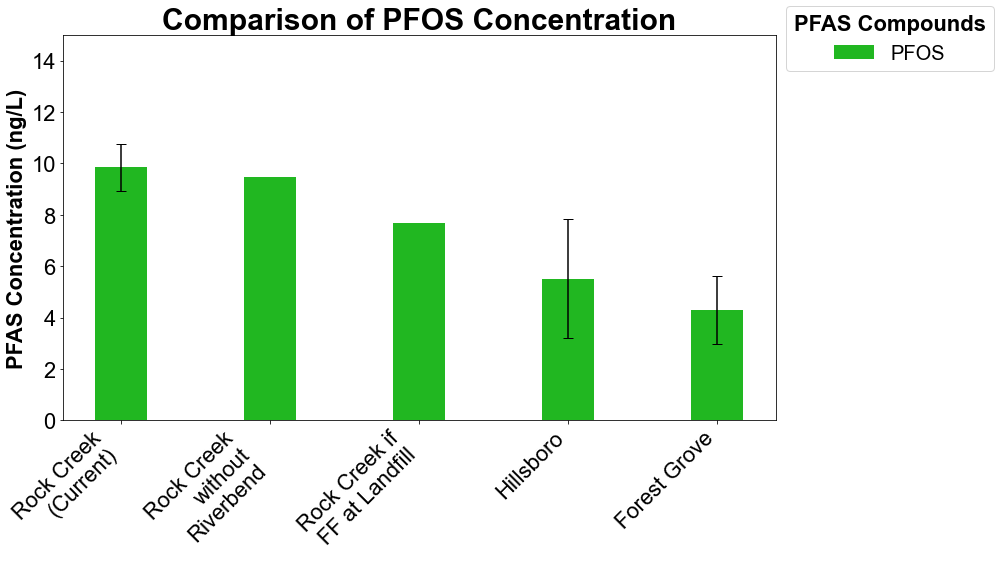

In [165]:
create_stacked_bar_chart_filtered(avg_pivot_table=avg_Conc[['PFOS']], std_dev_pivot_table=Std_Error[['PFOS']], figsize=(14, 8), title='Comparison of PFOS Concentration', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=15)

c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\rodriguezc\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
<ipython-input-140-d9dbf22beecb>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


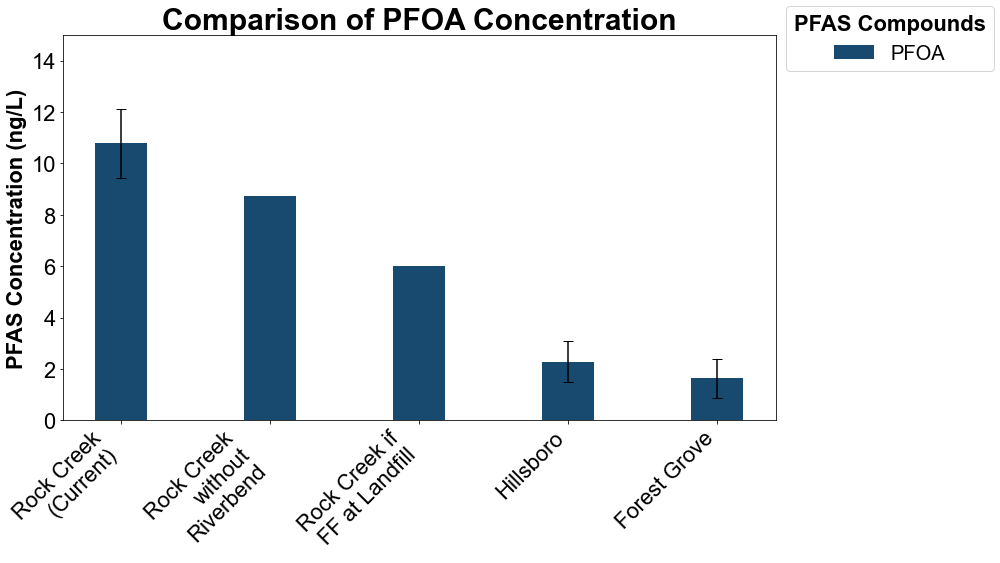

In [166]:
create_stacked_bar_chart_filtered(avg_pivot_table=avg_Conc[['PFOA']], std_dev_pivot_table=Std_Error[['PFOA']], figsize=(14, 8), title='Comparison of PFOA Concentration', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=15)

In [62]:
avg_Conc[['PFOA']]

PFOA
Rock Creek (Current)          10.790909
Rock Creek without Riverbend   8.744675
Rock Creek if FF at Landfill   5.996349
Durham                        38.457143
Hillsboro                      2.280000
Forest Grove                   1.640000

### Hillsboro Stacked Bar Concentration

In [172]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfills_Conc = pd.read_excel(excel_file_path, sheet_name='Cuffoff Effect Summary BQL', usecols='B:S', skiprows=40, nrows=4)

df_Landfills_Conc = df_Landfills_Conc.set_index(df_Landfills_Conc.columns[0])
df_Landfills_Conc = df_Landfills_Conc.iloc[:, :-1]

desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Landfills_Conc.columns]
# Reorder columns by indexing df with the desired order
df_Landfills_Conc = df_Landfills_Conc[filtered_order]

new_index = ['Current', 'Other Sources', 'Rock Creek with FF at Landfill','Hillsboro (No Riverbend)']

# Assigning the new index
df_Landfills_Conc.index = new_index

new_order = ['Current', 'Rock Creek with FF at Landfill', 'Other Sources','Hillsboro (No Riverbend)']

# Reordering the DataFrame
df_Landfills_Conc = df_Landfills_Conc.reindex(new_order)

# Creating a new DataFrame from rows where index equals 'y'
df_Landfills_Conc = df_Landfills_Conc.loc[['Hillsboro (No Riverbend)']]
df_Landfills_Conc

PFBA        PFPeA        PFHxA       PFHpA  \
Hillsboro (No Riverbend)  4794.117647  1539.411765  2134.705882  779.411765   

                                 PFOA       PFNA       PFDA     PFDoA  \
Hillsboro (No Riverbend)  1236.470588  90.823529  47.347059  3.588235   

                            NEtFOSAA    NMeFOSAA         PFBS       PFPeS  \
Hillsboro (No Riverbend)  149.470588  590.588235  1135.882353  104.176471   

                               PFHxS    PFOS  HFPO-DA      6:2FTS  
Hillsboro (No Riverbend)  830.588235  1650.0      0.0  669.235294

In [173]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'U:/Research_and_Innovation/_ModellingGroupProjects/PFAS Investigations/Data and analysis/Landfill Mass Balance/Landfill Mass Balance.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Landfills_Conc_error = pd.read_excel(excel_file_path, sheet_name='Cuffoff Effect Summary BQL', usecols='B:S', skiprows=40, nrows=6)

df_Landfills_Conc_error = df_Landfills_Conc_error.set_index('Unnamed: 1')
df_Landfills_Conc_error=df_Landfills_Conc_error.iloc[4:] 
df_Landfills_Conc_error = df_Landfills_Conc_error.iloc[:, :-1]


desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
filtered_order = [comp for comp in desired_order if comp in df_Landfills_Conc_error.columns]
# Reorder columns by indexing df with the desired order
df_Landfills_Conc_error = df_Landfills_Conc_error[filtered_order]

new_index=['Current', 'Hillsboro (No Riverbend)']
# Assigning the new index
df_Landfills_Conc_error.index = new_index


# Creating a new DataFrame from rows where index equals 'y'
df_Landfills_Conc_error = df_Landfills_Conc_error.loc[['Hillsboro (No Riverbend)']]
df_Landfills_Conc_error

PFBA     PFPeA       PFHxA      PFHpA  \
Hillsboro (No Riverbend)  783.744547  126.5564  162.648388  52.939134   

                               PFOA     PFNA      PFDA     PFDoA   NEtFOSAA  \
Hillsboro (No Riverbend)  95.247129  6.98856  8.890131  3.766874  36.667779   

                          NMeFOSAA        PFBS     PFPeS     PFHxS       PFOS  \
Hillsboro (No Riverbend)   56.5456  149.533733  26.54277  117.0579  436.73252   

                          HFPO-DA      6:2FTS  
Hillsboro (No Riverbend)      NaN  125.505837

<ipython-input-178-02211e22b65a>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=tick_label_fontsize, fontproperties=font)


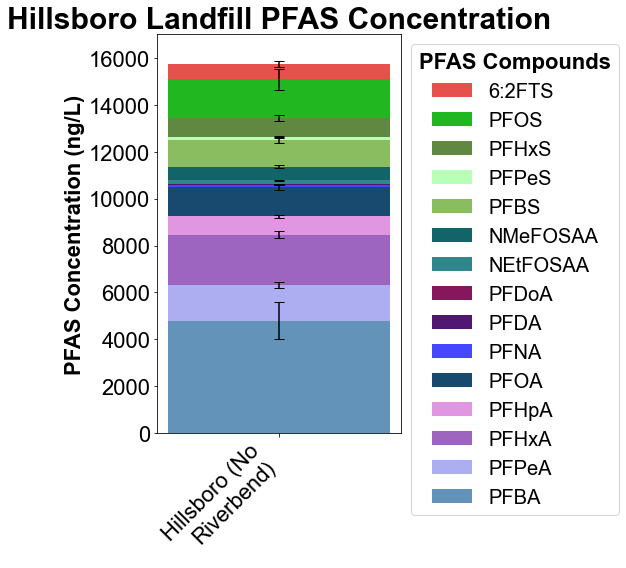

In [179]:
create_stacked_bar_chart_filtered(avg_pivot_table=df_Landfills_Conc, std_dev_pivot_table=df_Landfills_Conc_error, figsize=(8, 8), title='Hillsboro Landfill PFAS Concentration', compound_colors_dict=compound_colors_dict_abbrev,
                                      title_fontsize=30, axis_label_fontsize=22, tick_label_fontsize=22, legend_fontsize=20,ylim=17000)

### Landfill Concentration over Precipitation (2 Months)

In [31]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Conc = pd.read_excel(excel_file_path, sheet_name='Overall Landfill Conc.', usecols='B:S', skiprows=33, nrows=20)

df_Land_Conc=df_Land_Conc.set_index('Date')

#desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
#filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
#df_Land_Conc = df_Land_Conc[filtered_order]

new_index = df_Land_Conc.index.tolist()  # Convert index to a list for easy manipulation
new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
df_Land_Conc.index = new_index

df_Land_Conc=df_Land_Conc.drop(index=['2023-12'])
df_Land_Conc=df_Land_Conc[['Total PFAS']]

df_Land_Conc

Total PFAS
2019-8         18127.1
2019-10        17046.0
2020-12        20005.0
2021-2         14080.0
2021-5         16718.0
2021-8         24610.0
2021-10        11044.0
2022-3         19629.0
2022-4         19361.0
2022-8         19914.0
2022-9         22228.0
2022-12        19921.0
2023-1         17283.5
2023-4         13330.0
2023-9         12338.0
2023-10        25600.0
2024-3         13288.0
2024-3 (2)     14932.0
2024-5         17832.0

In [39]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Precipitation = pd.read_excel(excel_file_path, sheet_name='Landfill Flows', usecols='C:K', skiprows=2, nrows=66)

df_Precipitation=df_Precipitation[['Year-Month','Two preceding months precip']]
df_Precipitation=df_Precipitation.set_index('Year-Month')
df_Precipitation.loc['2024-3 (2)']=10.38
df_Precipitation

Two preceding months precip
Year-Month                             
2019-1                           12.226
2019-2                           11.380
2019-3                            8.620
2019-4                            4.680
2019-5                            5.100
...                                 ...
2024-3                           10.380
2024-4                            6.460
2024-5                            4.300
2024-6                            3.540
2024-3 (2)                       10.380

[67 rows x 1 columns]

In [40]:
# Merge df1 and df2 based on their index
result_df = pd.merge(df_Land_Conc, df_Precipitation, left_index=True, right_index=True,how='inner')
result_df

Total PFAS  Two preceding months precip
2019-8         18127.1                         0.76
2019-10        17046.0                         4.71
2020-12        20005.0                        13.34
2021-2         14080.0                        14.72
2021-5         16718.0                         0.98
2021-8         24610.0                         0.02
2021-10        11044.0                         7.06
2022-3         19629.0                         5.56
2022-4         19361.0                         7.52
2022-8         19914.0                         0.44
2022-9         22228.0                         0.66
2022-12        19921.0                        15.84
2023-1         17283.5                        13.86
2023-4         13330.0                        10.93
2023-9         12338.0                         3.10
2023-10        25600.0                         5.05
2024-3         13288.0                        10.38
2024-3 (2)     14932.0                        10.38
2024-5         17832.0                         4.30

In [41]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                 title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot for two specified columns from a DataFrame with enhanced styling and
    statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(data_df[column_x], data_df[column_y])

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Adding linear regression line to the scatter plot
    line_eq = f"y = {slope:.4f}x + {intercept:.2f}"
    ax.plot(data_df[column_x], intercept + slope * data_df[column_x], 'r')

    # Adding titles and labels with custom fonts
    ax.set_title('Total PFAS Concentration vs Two Preceding Months Precipitation', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Precipitation (in)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('PFAS Concentration (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared, p-value and equation of the line
    text_str = f'{line_eq}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.62, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    #plt.legend()
    plt.tight_layout()
    plt.show()

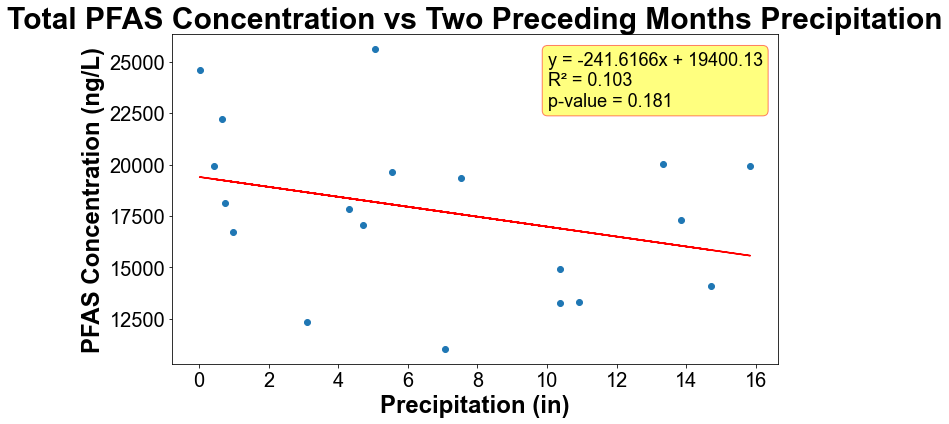

In [42]:
plot_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

In [43]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_residual_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                          title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot of the residuals from a linear regression of two specified columns 
    from a DataFrame with enhanced styling and statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Calculate predicted y values and residuals
    predicted_y = intercept + slope * data_df[column_x]
    residuals = data_df[column_y] - predicted_y

    # Scatter plot of the residuals
    ax.scatter(data_df[column_x], residuals)

    # Adding a horizontal line at zero for residuals
    ax.axhline(y=0, color='red', linestyle='--')

    # Adding titles and labels with custom fonts
    ax.set_title('Residual Plot: PFAS Concentration vs Precipitation', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Precipitation (in)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Residuals (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    text_str = f'y = {slope:.4f}x + {intercept:.2f}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.62, 0.05), xycoords='axes fraction',
                verticalalignment='bottom', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

# Usage example
# plot_residual_scatter(data_df=df, column_x='Precipitation', column_y='PFAS_Concentration')


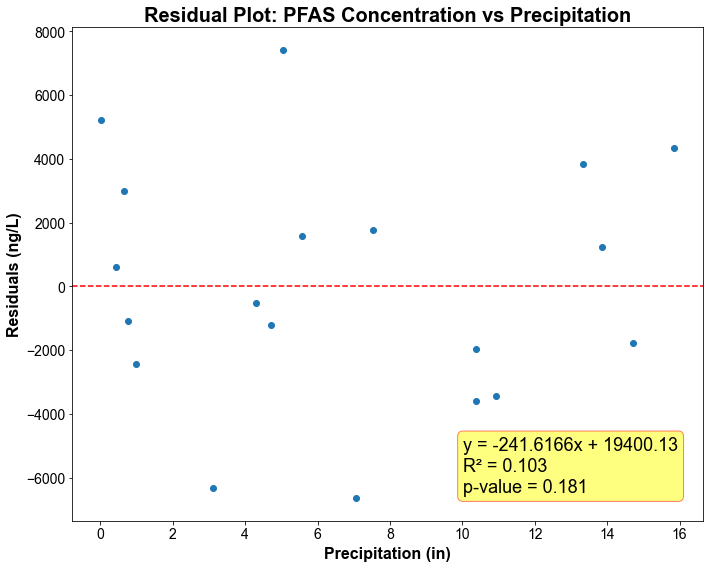

In [44]:
plot_residual_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS')

In [45]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_residual_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                          title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot of the residuals from a linear regression of two specified columns 
    from a DataFrame with enhanced styling and statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Calculate predicted y values and residuals
    predicted_y = intercept + slope * data_df[column_x]
    residuals = data_df[column_y] - predicted_y

    # Plot the residuals against the DataFrame index
    ax.scatter(data_df.index, residuals)  # Using the index of the DataFrame

    # Adding a horizontal line at zero for residuals
    ax.axhline(y=0, color='red', linestyle='--')

    # Adding titles and labels with custom fonts
    ax.set_title('Residual Plot: PFAS Concentration vs Time', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Residuals (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    text_str = f'y = {slope:.4f}x + {intercept:.2f}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting custom x-tick labels if necessary
    ax.set_xticks(data_df.index)
    ax.set_xticklabels(data_df.index, rotation=45, ha='right', fontsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()


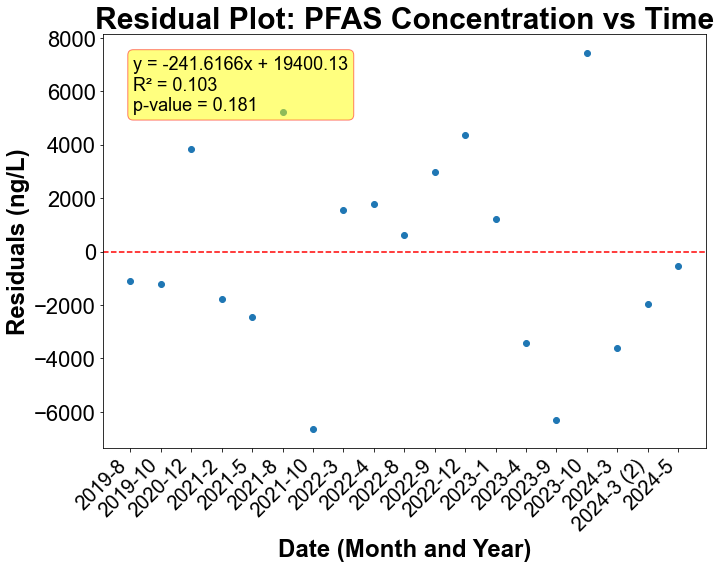

In [46]:
plot_residual_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS',title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

##### Version for Hillsboro Landfill (Not Combined)

In [47]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Land_Conc = pd.read_excel(excel_file_path, sheet_name='HBL Conc', usecols='B:S', skiprows=33, nrows=17)

df_Land_Conc=df_Land_Conc.set_index('Date')

#desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
#filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
#df_Land_Conc = df_Land_Conc[filtered_order]

#new_index = df_Land_Conc.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Conc.index = new_index

#df_Land_Conc=df_Land_Conc.drop(index=['2023-12'])
df_Land_Conc=df_Land_Conc[['Total PFAS']]

df_Land_Conc

Total PFAS
Date               
2019-10     15577.0
2020-12     14066.0
2021-2       2291.9
2021-5      23845.0
2021-8      23423.0
2021-10     23602.0
2022-3      17247.0
2022-4      13484.0
2022-9      17672.0
2022-12     15828.0
2023-1      16222.0
2023-6      13668.0
2023-8      19502.0
2023-10     16190.0
2024-2       9712.0
2024-3      13628.0
2024-5      11891.0

In [48]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Precipitation = pd.read_excel(excel_file_path, sheet_name='Landfill Flows', usecols='C:K', skiprows=2, nrows=66)

df_Precipitation=df_Precipitation[['Year-Month','Two preceding months precip']]
df_Precipitation=df_Precipitation.set_index('Year-Month')

df_Precipitation

Two preceding months precip
Year-Month                             
2019-1                           12.226
2019-2                           11.380
2019-3                            8.620
2019-4                            4.680
2019-5                            5.100
...                                 ...
2024-2                           16.370
2024-3                           10.380
2024-4                            6.460
2024-5                            4.300
2024-6                            3.540

[66 rows x 1 columns]

In [49]:
# Merge df1 and df2 based on their index
result_df = pd.merge(df_Land_Conc, df_Precipitation, left_index=True, right_index=True,how='inner')
result_df

Total PFAS  Two preceding months precip
2019-10     15577.0                         4.71
2020-12     14066.0                        13.34
2021-2       2291.9                        14.72
2021-5      23845.0                         0.98
2021-8      23423.0                         0.02
2021-10     23602.0                         7.06
2022-3      17247.0                         5.56
2022-4      13484.0                         7.52
2022-9      17672.0                         0.66
2022-12     15828.0                        15.84
2023-1      16222.0                        13.86
2023-6      13668.0                         0.90
2023-8      19502.0                         0.85
2023-10     16190.0                         5.05
2024-2       9712.0                        16.37
2024-3      13628.0                        10.38
2024-5      11891.0                         4.30

In [50]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_residual_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                          title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot of the residuals from a linear regression of two specified columns 
    from a DataFrame with enhanced styling and statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Calculate predicted y values and residuals
    predicted_y = intercept + slope * data_df[column_x]
    residuals = data_df[column_y] - predicted_y

    # Scatter plot of the residuals
    ax.scatter(data_df[column_x], residuals)

    # Adding a horizontal line at zero for residuals
    ax.axhline(y=0, color='red', linestyle='--')

    # Adding titles and labels with custom fonts
    ax.set_title('Residual Plot: PFAS Concentration vs Precipitation', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Precipitation (in)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Residuals (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    text_str = f'y = {slope:.4f}x + {intercept:.2f}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.62, 0.05), xycoords='axes fraction',
                verticalalignment='bottom', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()


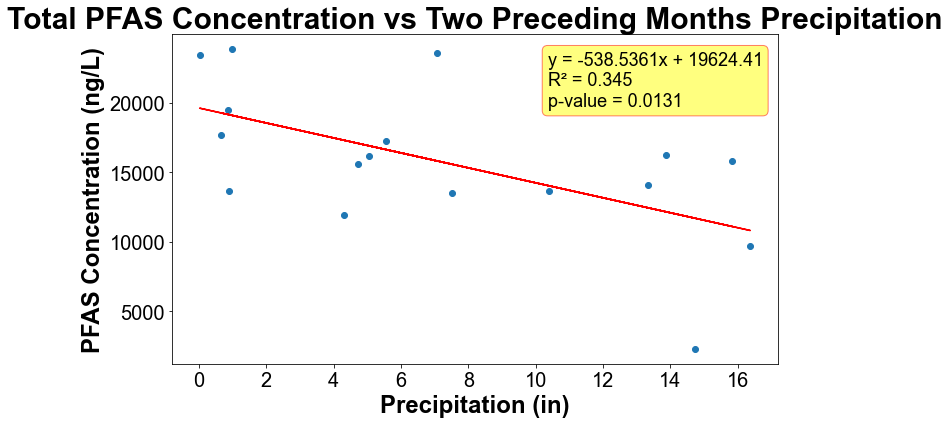

In [51]:
plot_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

In [52]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_residual_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                          title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot of the residuals from a linear regression of two specified columns 
    from a DataFrame with enhanced styling and statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Calculate predicted y values and residuals
    predicted_y = intercept + slope * data_df[column_x]
    residuals = data_df[column_y] - predicted_y

    # Plot the residuals against the DataFrame index
    ax.scatter(data_df.index, residuals)  # Using the index of the DataFrame

    # Adding a horizontal line at zero for residuals
    ax.axhline(y=0, color='red', linestyle='--')

    # Adding titles and labels with custom fonts
    ax.set_title('Residual Plot: PFAS Concentration vs Time', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Residuals (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    text_str = f'y = {slope:.4f}x + {intercept:.2f}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting custom x-tick labels if necessary
    ax.set_xticks(data_df.index)
    ax.set_xticklabels(data_df.index, rotation=45, ha='right', fontsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

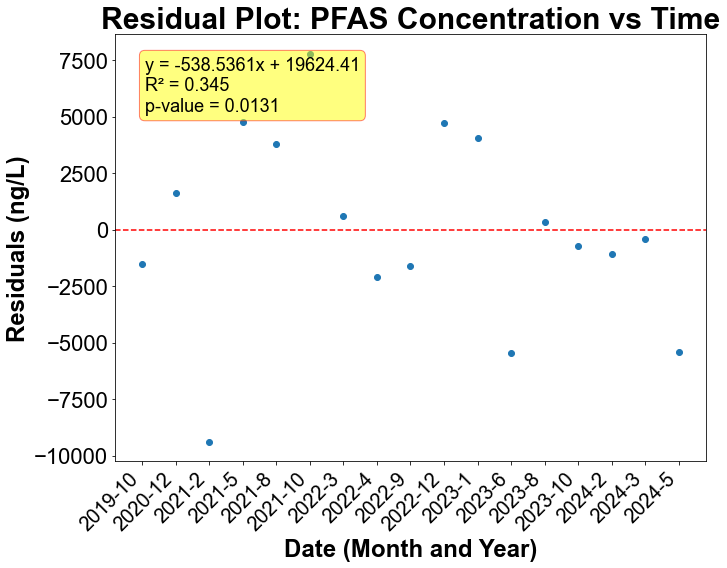

In [53]:
plot_residual_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS',title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

##### Riverbend Version

In [54]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_River_Conc = pd.read_excel(excel_file_path, sheet_name='Riverbend Conc', usecols='B:S', skiprows=33, nrows=14)

df_River_Conc=df_River_Conc.set_index('Date')

#desired_order = df['Abbrev'].tolist()  # Convert to list if not already
# Filter the desired_order to only include columns that exist in df
#filtered_order = [comp for comp in desired_order if comp in df_Land_Conc.columns]
# Reorder columns by indexing df with the desired order
#df_Land_Conc = df_Land_Conc[filtered_order]

#new_index = df_Land_Conc.index.tolist()  # Convert index to a list for easy manipulation
#new_index[18] = '2024-3 (2)'  # Change the index of the second row to 100

# Assign the new index back to the DataFrame
#df_Land_Conc.index = new_index

#df_Land_Conc=df_Land_Conc.drop(index=['2023-12'])
df_River_Conc=df_River_Conc[['Total PFAS']]

df_River_Conc

Total PFAS
Date               
2019-10       17532
2020-12       17815
2021-2        16717
2021-5        20700
2021-8        23050
2021-10       27508
2022-3        19695
2022-4        16134
2022-9        22546
2022-12       23368
2023-1        17841
2023-10       25949
2024-3        14959
2024-5        23273

In [55]:
#Specify where the file is saved use '/' instead of '\'
excel_file_path = 'C:/Users/rodriguezc/Clean Water Services/PFAS Investigations Team - Landfill/DRAFT Landfill PFAS Mass Balance Clean - 9-27-24.xlsx'

# Read the Excel file
# Load the specific range from the Excel sheet into a DataFrame
df_Precipitation = pd.read_excel(excel_file_path, sheet_name='Landfill Flows', usecols='C:K', skiprows=2, nrows=66)

df_Precipitation=df_Precipitation[['Year-Month','Two preceding months precip']]
df_Precipitation=df_Precipitation.set_index('Year-Month')

df_Precipitation

Two preceding months precip
Year-Month                             
2019-1                           12.226
2019-2                           11.380
2019-3                            8.620
2019-4                            4.680
2019-5                            5.100
...                                 ...
2024-2                           16.370
2024-3                           10.380
2024-4                            6.460
2024-5                            4.300
2024-6                            3.540

[66 rows x 1 columns]

In [61]:
# Merge df1 and df2 based on their index
result_df = pd.merge(df_River_Conc, df_Precipitation, left_index=True, right_index=True,how='inner')
result_df

Total PFAS  Two preceding months precip
2019-10       17532                         4.71
2020-12       17815                        13.34
2021-2        16717                        14.72
2021-5        20700                         0.98
2021-8        23050                         0.02
2021-10       27508                         7.06
2022-3        19695                         5.56
2022-4        16134                         7.52
2022-9        22546                         0.66
2022-12       23368                        15.84
2023-1        17841                        13.86
2023-10       25949                         5.05
2024-3        14959                        10.38
2024-5        23273                         4.30

In [62]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_residual_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                          title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot of the residuals from a linear regression of two specified columns 
    from a DataFrame with enhanced styling and statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Calculate predicted y values and residuals
    predicted_y = intercept + slope * data_df[column_x]
    residuals = data_df[column_y] - predicted_y

    # Scatter plot of the residuals
    ax.scatter(data_df[column_x], residuals)

    # Adding a horizontal line at zero for residuals
    ax.axhline(y=0, color='red', linestyle='--')

    # Adding titles and labels with custom fonts
    ax.set_title('Residual Plot: PFAS Concentration vs Precipitation', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Precipitation (in)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Residuals (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    text_str = f'y = {slope:.4f}x + {intercept:.2f}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.62, 0.05), xycoords='axes fraction',
                verticalalignment='bottom', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

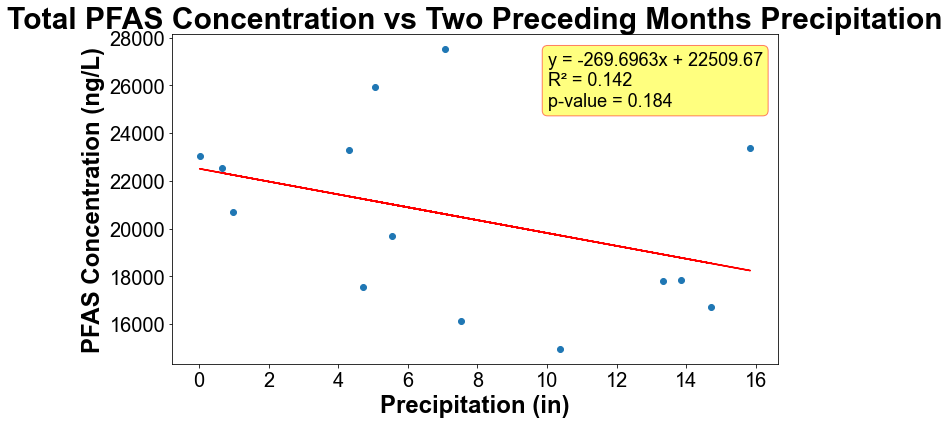

In [63]:
plot_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS', fig_size=(10, 6), 
                 title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)

In [59]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
import pandas as pd

def plot_residual_scatter(data_df, column_x, column_y, fig_size=(10, 8), 
                          title_fontsize=20, axis_label_fontsize=16, tick_label_fontsize=14):
    """
    Create a scatter plot of the residuals from a linear regression of two specified columns 
    from a DataFrame with enhanced styling and statistical annotations.

    Args:
        data_df (pd.DataFrame): The input dataframe.
        column_x (str): The name of the column for the x-axis.
        column_y (str): The name of the column for the y-axis.
        fig_size (tuple): The size of the figure (width, height).
        title_fontsize (int): Font size for the chart title.
        axis_label_fontsize (int): Font size for the axis labels.
        tick_label_fontsize (int): Font size for the tick labels.
    """
    font_bold = FontProperties(family='Arial', weight='bold')
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[column_x], data_df[column_y])
    r_squared = r_value**2

    # Calculate predicted y values and residuals
    predicted_y = intercept + slope * data_df[column_x]
    residuals = data_df[column_y] - predicted_y

    # Plot the residuals against the DataFrame index
    ax.scatter(data_df.index, residuals)  # Using the index of the DataFrame

    # Adding a horizontal line at zero for residuals
    ax.axhline(y=0, color='red', linestyle='--')

    # Adding titles and labels with custom fonts
    ax.set_title('Residual Plot: PFAS Concentration vs Time', fontsize=title_fontsize, fontproperties=font_bold)
    ax.set_xlabel('Date (Month and Year)', fontsize=axis_label_fontsize, fontproperties=font_bold)
    ax.set_ylabel('Residuals (ng/L)', fontsize=axis_label_fontsize, fontproperties=font_bold)

    # Annotation for R-squared and p-value
    text_str = f'y = {slope:.4f}x + {intercept:.2f}\nR² = {r_squared:.3f}\np-value = {p_value:.3g}'
    ax.annotate(text_str, xy=(0.05, 0.95), xycoords='axes fraction',
                verticalalignment='top', horizontalalignment='left', 
                fontsize=18, bbox=dict(boxstyle="round, pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))

    # Setting custom x-tick labels if necessary
    ax.set_xticks(data_df.index)
    ax.set_xticklabels(data_df.index, rotation=45, ha='right', fontsize=tick_label_fontsize)

    plt.tight_layout()
    plt.show()

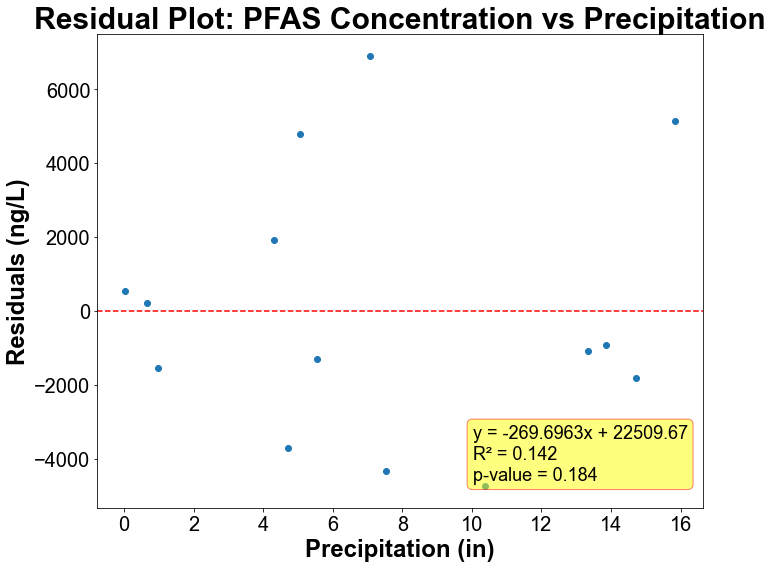

In [64]:
plot_residual_scatter(data_df=result_df, column_x='Two preceding months precip', column_y='Total PFAS',title_fontsize=30, axis_label_fontsize=24, tick_label_fontsize=20)